# From Quality control to Clustering for day 7 samples

package loading

In [1]:
library(ggplot2)
library(cowplot)
library(dplyr)
library(scran)
library(biomaRt)
library(tibble)
library(AnnotationHub)
library(patchwork)
library(SingleR)
library(Seurat)
library(harmony)
library(SeuratData)
library(magrittr)
library(SeuratWrappers)
library(celldex)
library(scuttle)
library(scRNAseq)
library(DoubletFinder)


Attachement du package : ‘dplyr’


Les objets suivants sont masqués depuis ‘package:stats’:

    filter, lag


Les objets suivants sont masqués depuis ‘package:base’:

    intersect, setdiff, setequal, union


Le chargement a nécessité le package : SingleCellExperiment

Le chargement a nécessité le package : SummarizedExperiment

Le chargement a nécessité le package : MatrixGenerics

Le chargement a nécessité le package : matrixStats


Attachement du package : ‘matrixStats’


L'objet suivant est masqué depuis ‘package:dplyr’:

    count



Attachement du package : ‘MatrixGenerics’


Les objets suivants sont masqués depuis ‘package:matrixStats’:

    colAlls, colAnyNAs, colAnys, colAvgsPerRowSet, colCollapse,
    colCounts, colCummaxs, colCummins, colCumprods, colCumsums,
    colDiffs, colIQRDiffs, colIQRs, colLogSumExps, colMadDiffs,
    colMads, colMaxs, colMeans2, colMedians, colMins, colOrderStats,
    colProds, colQuantiles, colRanges, colRanks, colSdDiffs, colSds,
    colSums2, c

Definitions of colors pallet

In [2]:
custom_colors <- list()

colors_dutch <- c(
  '#FFC312','#C4E538','#12CBC4','#FDA7DF','#ED4C67',
  '#F79F1F','#A3CB38','#1289A7','#D980FA','#B53471',
  '#EE5A24','#009432','#0652DD','#9980FA','#833471',
  '#EA2027','#006266','#1B1464','#5758BB','#6F1E51'
)

colors_spanish <- c(
  '#40407a','#706fd3','#f7f1e3','#34ace0','#33d9b2',
  '#2c2c54','#474787','#aaa69d','#227093','#218c74',
  '#ff5252','#ff793f','#d1ccc0','#ffb142','#ffda79',
  '#b33939','#cd6133','#84817a','#cc8e35','#ccae62'
)

custom_colors$discrete <- c(colors_dutch, colors_spanish)

custom_colors$cell_cycle <- setNames(
  c('#45aaf2', '#f1c40f', '#e74c3c', '#7f8c8d'),
  c('G1',      'S',       'G2M',     '-')
)

plot resolution

In [16]:
options(repr.plot.width = 18, repr.plot.height = 17, repr.plot.pointsize = 24)

Loading of the cell ranger matrix

In [3]:
J7_15112017.data<-Read10X("/home/adufour/work/run_cellranger_count/ensembl/J7_15112017_10_26/outs/filtered_feature_bc_matrix")
J7_31082017.data<-Read10X("/home/adufour/work/run_cellranger_count/ensembl/J7_31082017_10_26/outs/filtered_feature_bc_matrix")
J7_3.data<-Read10X("/home/adufour/work/run_cellranger_count/ensembl/J7_3_20210825_10_26/outs/filtered_feature_bc_matrix")
J7_4.data<-Read10X("/home/adufour/work/run_cellranger_count/ensembl/J7_4_20210825_10_26/outs/filtered_feature_bc_matrix")

In [4]:
J7_15112017 <- CreateSeuratObject(counts = J7_15112017.data)
J7_31082017 <- CreateSeuratObject(counts = J7_31082017.data)
J7_3 <- CreateSeuratObject(counts = J7_3.data)
J7_4 <- CreateSeuratObject(counts = J7_4.data)

Annotation of samples

In [5]:
J7_15112017$TIME<-"J7"
J7_31082017$TIME<-"J7"
J7_3$TIME<-"J7"
J7_4$TIME<-"J7"

J7_15112017$EMB<-"B"
J7_31082017$EMB<-"B"
J7_3$EMB<-"B"
J7_4$EMB<-"B"

J7_15112017$SAMP<-"J7-1"
J7_31082017$SAMP<-"J7-2"
J7_3$SAMP<-"J7-3"
J7_4$SAMP<-"J7-4"

# QC : Mitochondrial genes

In [6]:
# Connect to AnnotationHub
ah <- AnnotationHub()

# Access the Ensembl database for organism
ahDb <- query(ah, 
              pattern = c("Sus scrofa", "EnsDb"), 
              ignore.case = TRUE)

snapshotDate(): 2021-05-18



In [7]:
id <- ahDb %>%
  mcols() %>%
  rownames() %>%
  tail(n = 1)

In [8]:
edb <- ah[[id]]

loading from cache

require("ensembldb")



Extract gene-level information from database

In [9]:
annotations <- genes(edb, 
                     return.type = "data.frame") 

Select annotations of interest

In [10]:
annotations <- annotations %>%
  dplyr::select(gene_id, gene_name, gene_biotype, seq_name, description, entrezid)

Extract IDs for mitochondrial genes

In [11]:
mt <- annotations %>%
        dplyr::filter(seq_name == "MT")
mt$gene_name <- ifelse(mt$gene_name == '', mt$gene_id, mt$gene_name)
mt <- mt$gene_name

Count Mt RNA percentage

In [12]:
counts <- GetAssayData(object = J7_15112017, slot = "counts")
J7_15112017[["percent.mt"]] <- Matrix::colSums(counts[which(rownames(counts) %in% mt),], na.rm = T)/Matrix::colSums(counts, na.rm = T)
counts <- GetAssayData(object = J7_31082017, slot = "counts")
J7_31082017[["percent.mt"]] <- Matrix::colSums(counts[which(rownames(counts) %in% mt),], na.rm = T)/Matrix::colSums(counts, na.rm = T)
counts <- GetAssayData(object = J7_3, slot = "counts")
J7_3[["percent.mt"]] <- Matrix::colSums(counts[which(rownames(counts) %in% mt),], na.rm = T)/Matrix::colSums(counts, na.rm = T)
counts <- GetAssayData(object = J7_4, slot = "counts")
J7_4[["percent.mt"]] <- Matrix::colSums(counts[which(rownames(counts) %in% mt),], na.rm = T)/Matrix::colSums(counts, na.rm = T)

In [13]:
J7_15112017
J7_31082017
J7_3
J7_4

An object of class Seurat 
21304 features across 1249 samples within 1 assay 
Active assay: RNA (21304 features, 0 variable features)

An object of class Seurat 
21304 features across 1212 samples within 1 assay 
Active assay: RNA (21304 features, 0 variable features)

An object of class Seurat 
21304 features across 1492 samples within 1 assay 
Active assay: RNA (21304 features, 0 variable features)

An object of class Seurat 
21304 features across 2124 samples within 1 assay 
Active assay: RNA (21304 features, 0 variable features)

Visualization of the number of transcript, genes and the percentage of mt RNA per cells

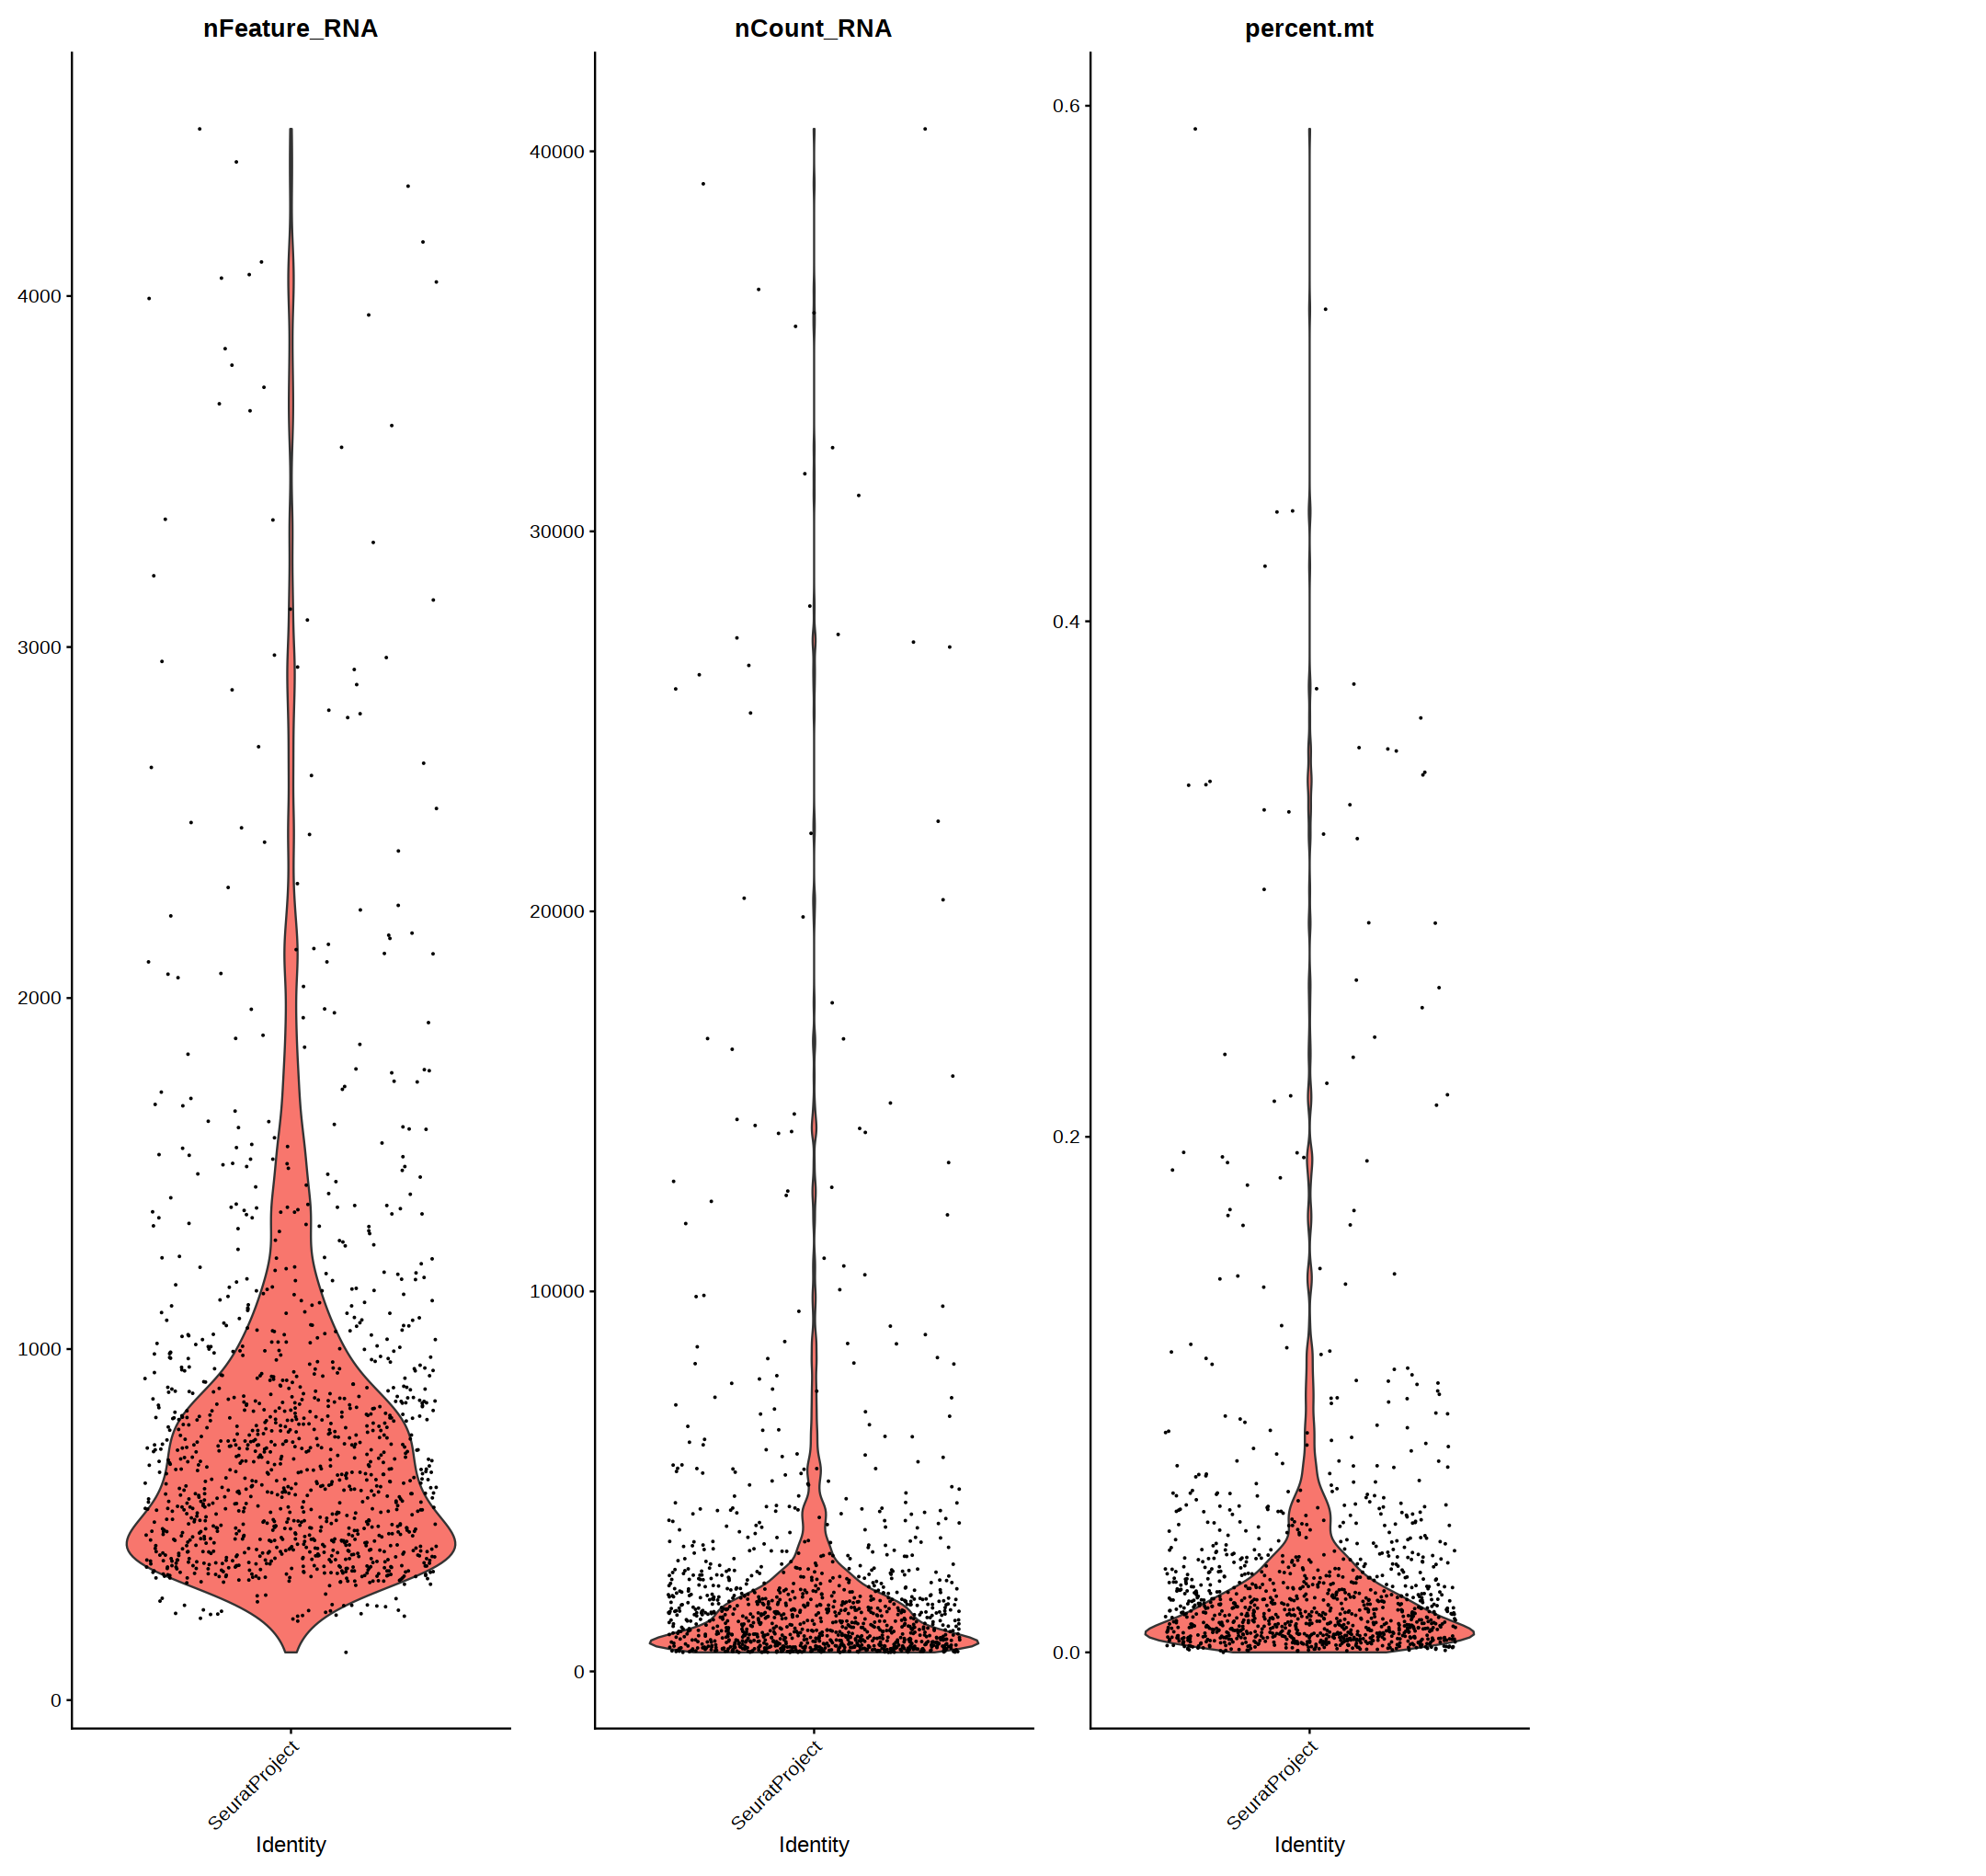

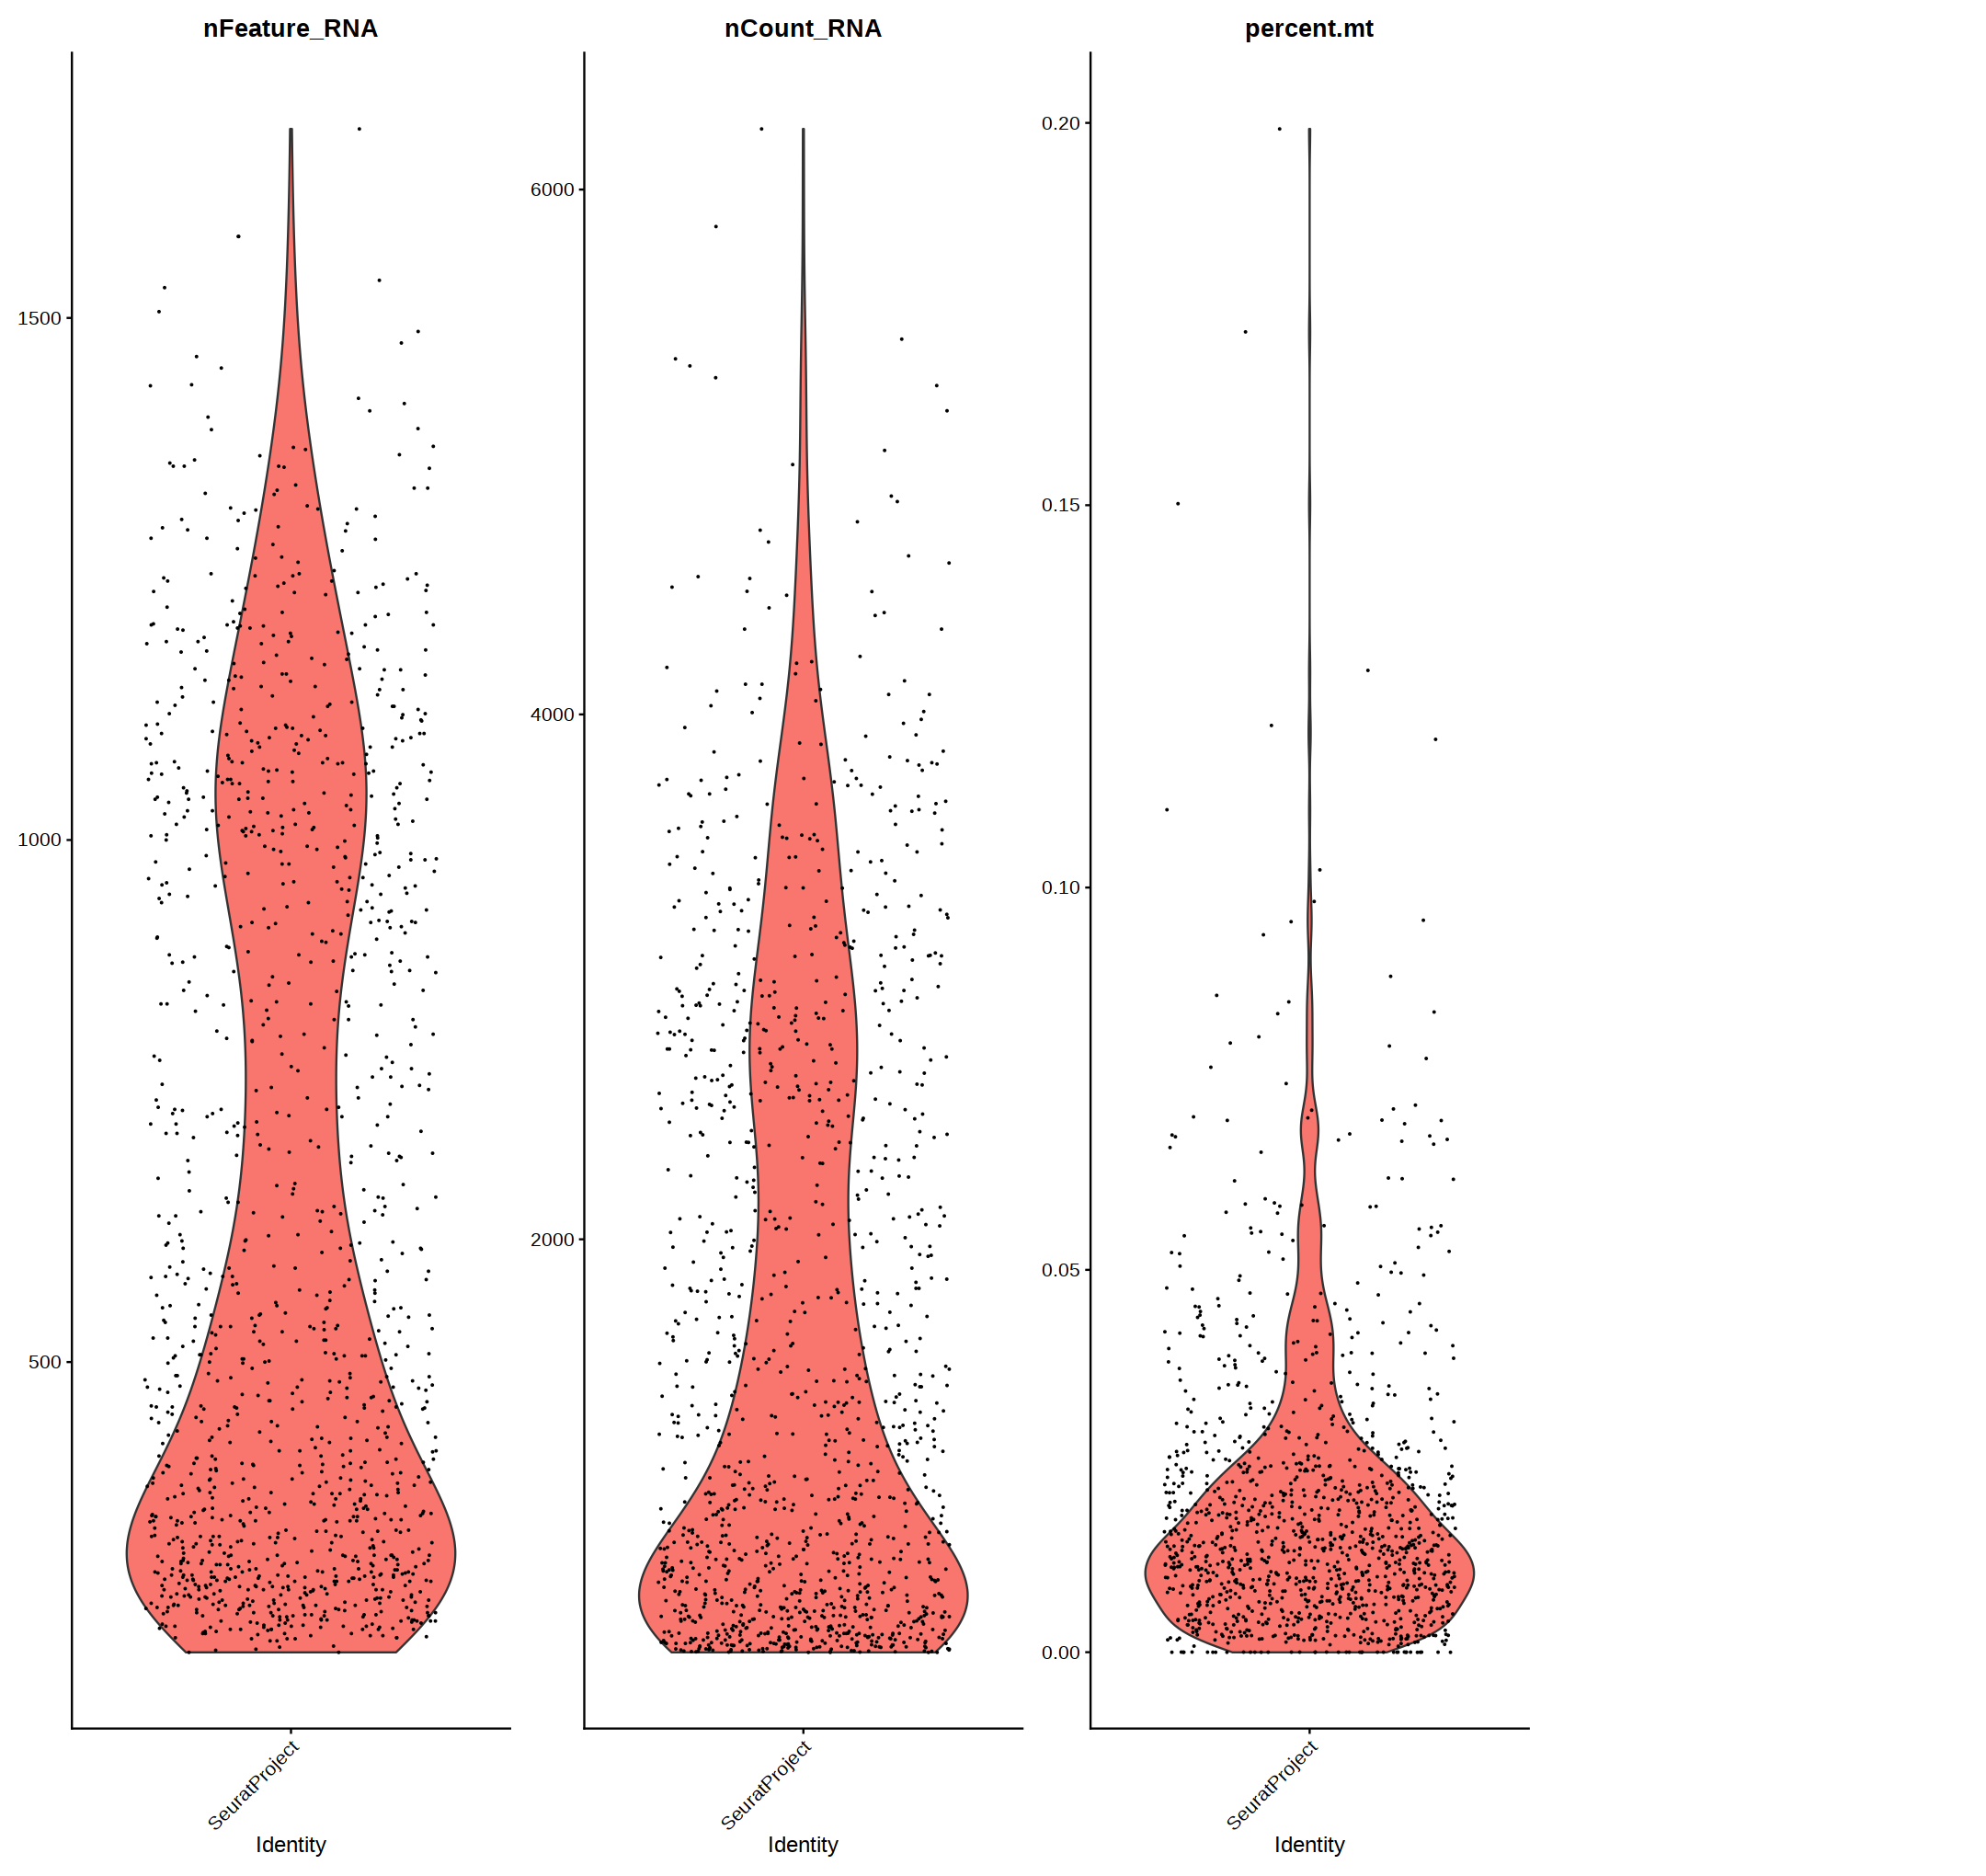

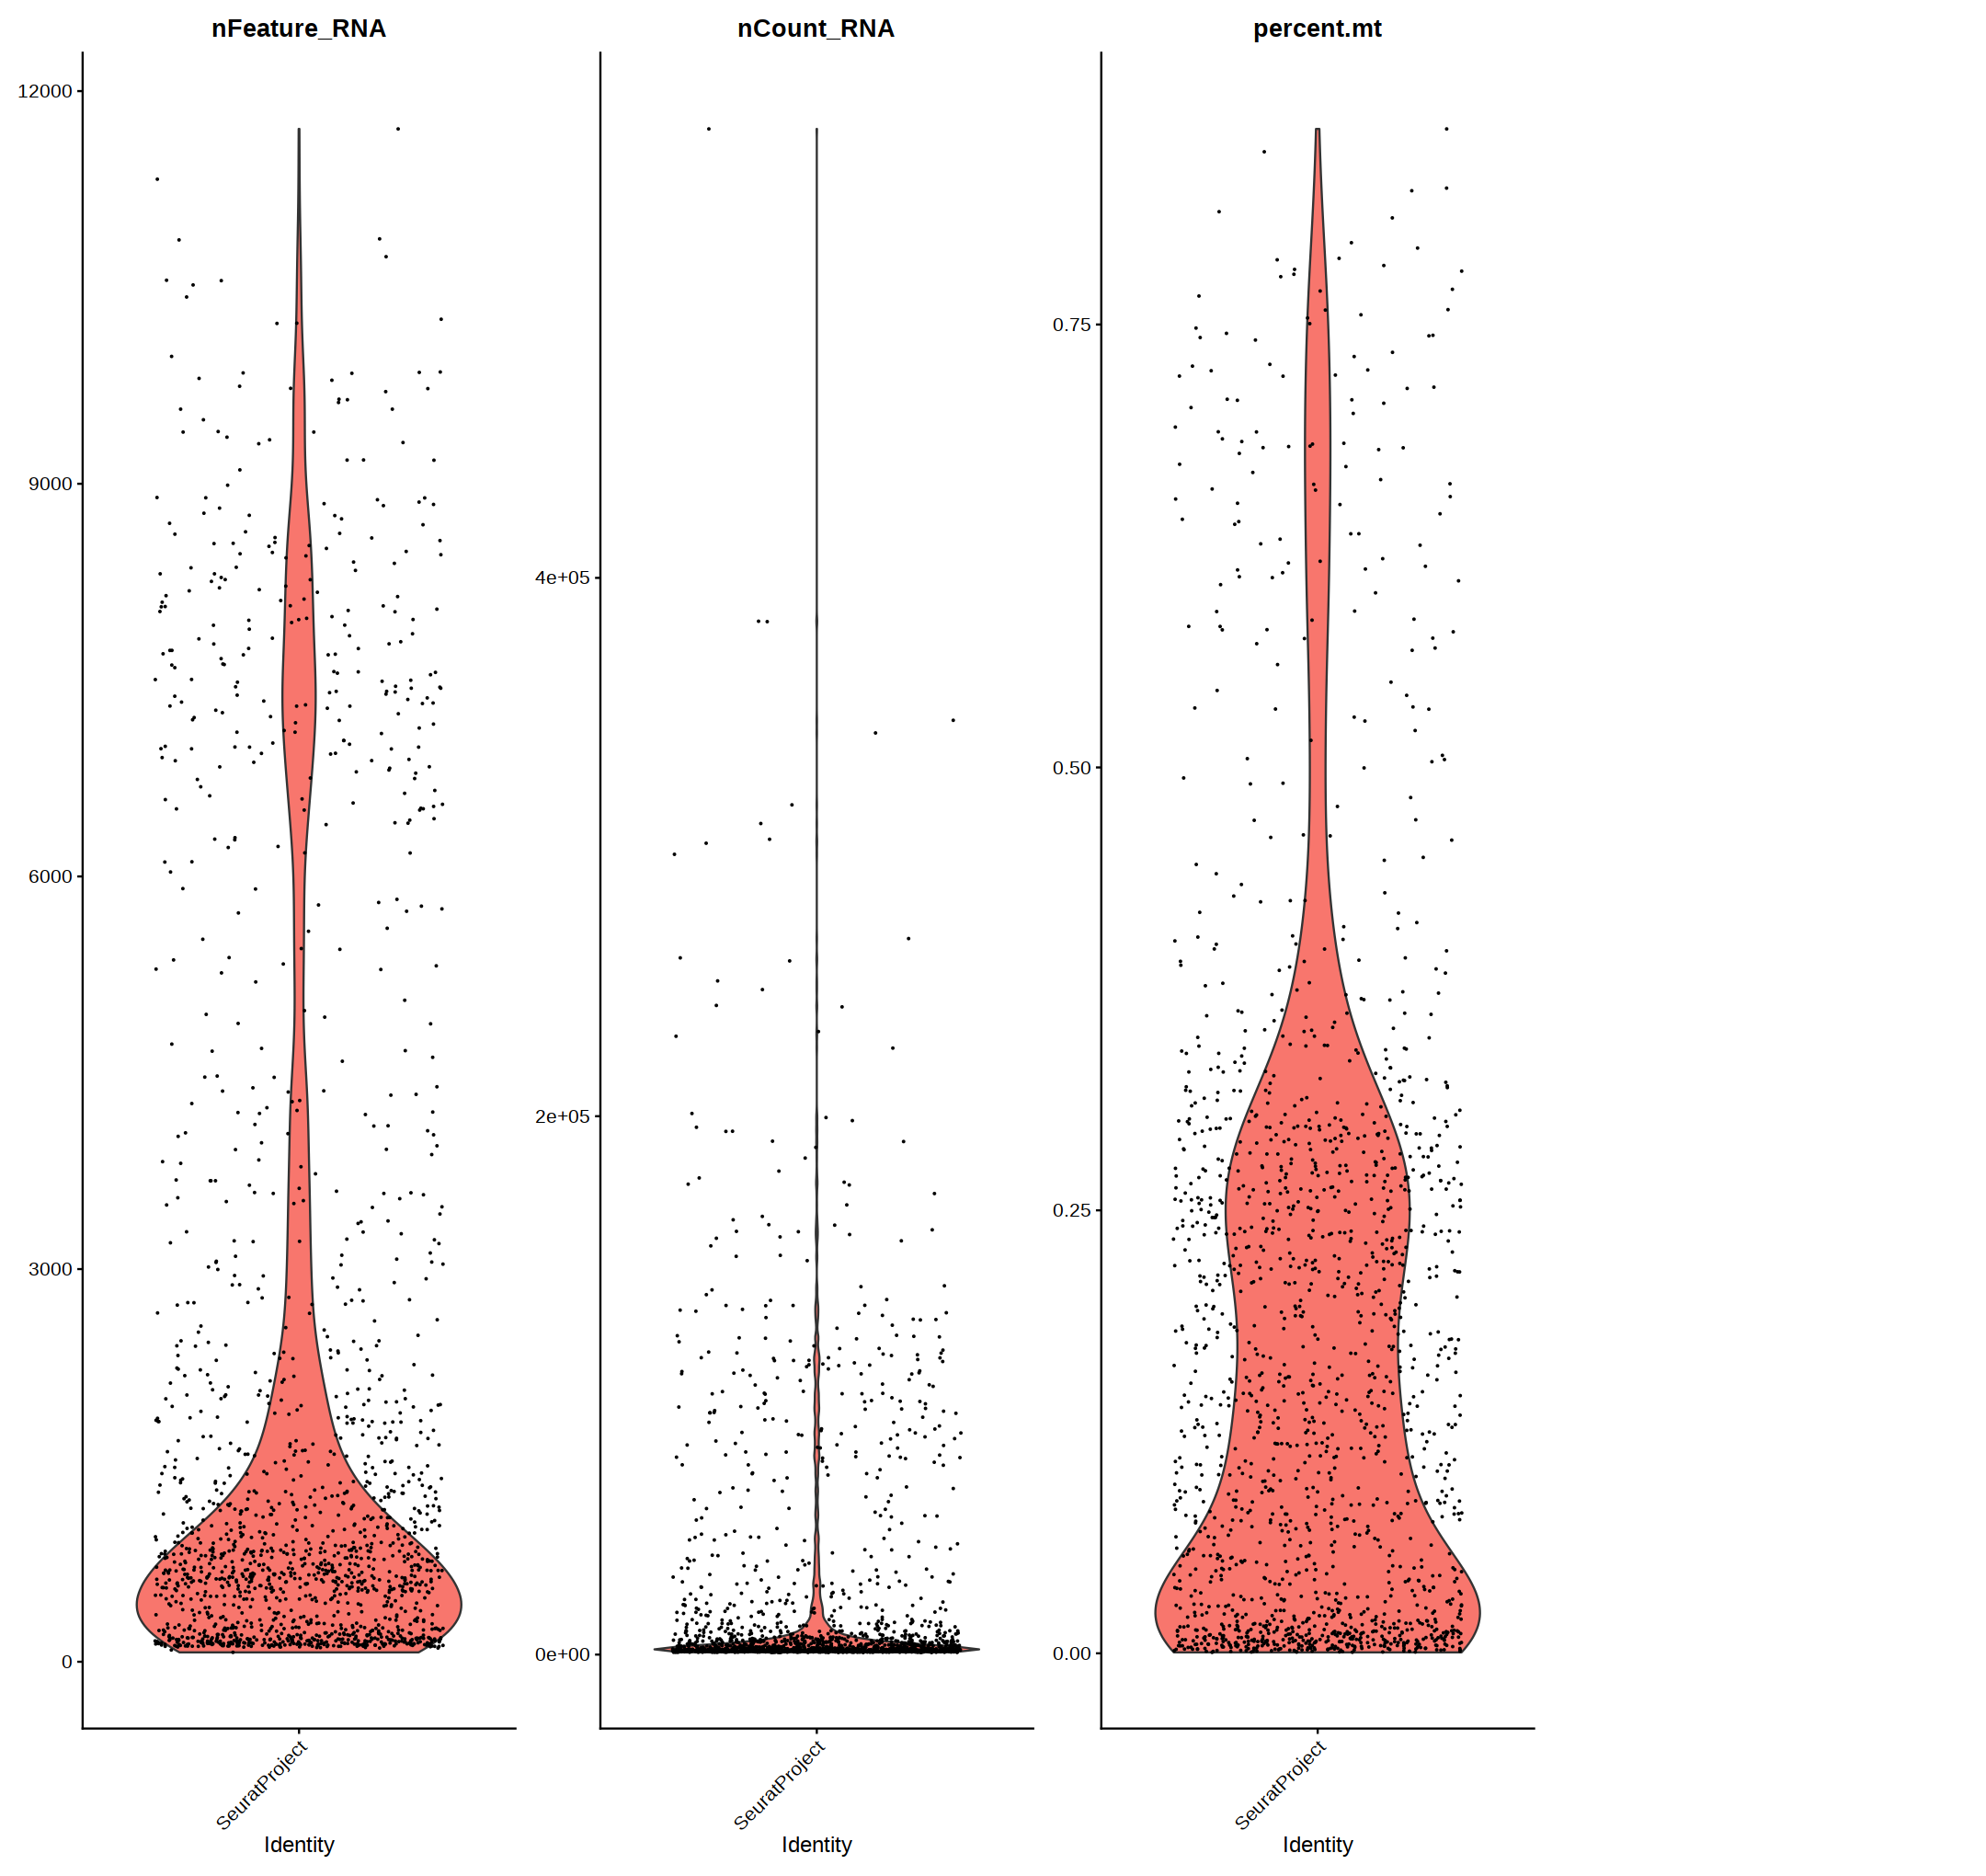

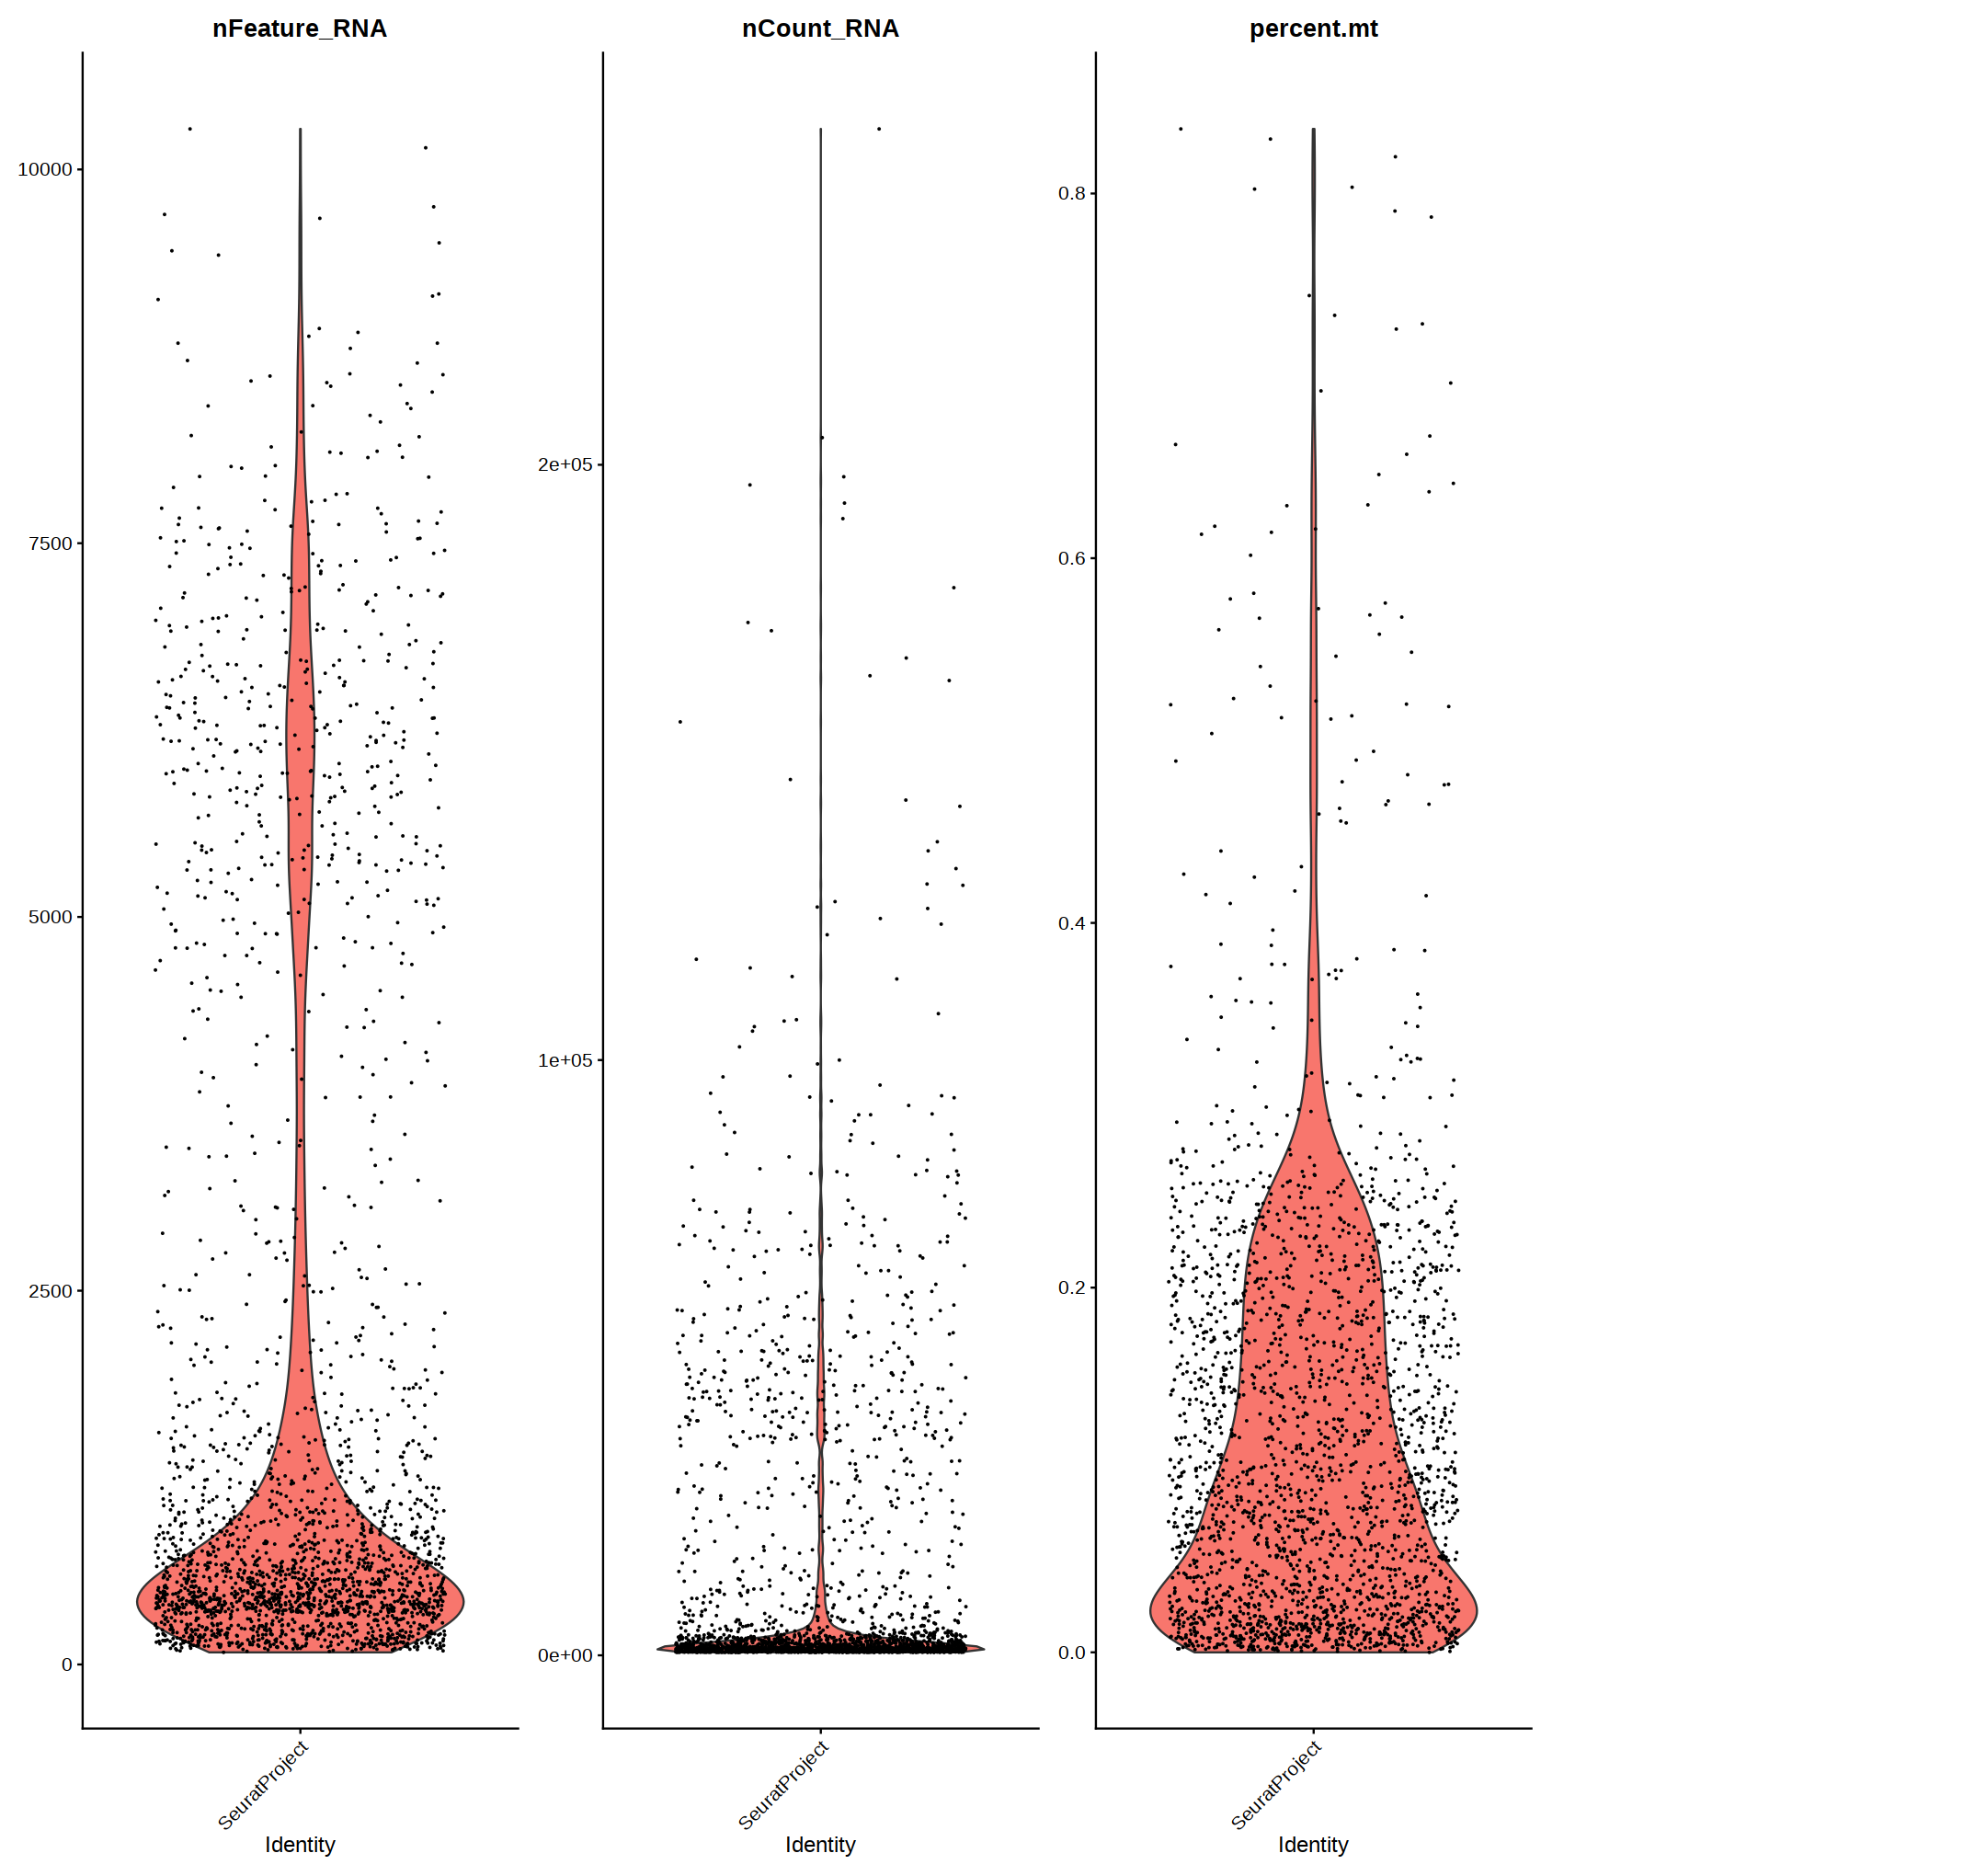

In [16]:
VlnPlot(J7_15112017, features = c("nFeature_RNA","nCount_RNA","percent.mt"),ncol=4)
VlnPlot(J7_31082017, features = c("nFeature_RNA","nCount_RNA","percent.mt"),ncol=4)
VlnPlot(J7_3, features = c("nFeature_RNA","nCount_RNA","percent.mt"),ncol=4)
VlnPlot(J7_4, features = c("nFeature_RNA","nCount_RNA","percent.mt"),ncol=4)

Visualize the ratio between the percentage of mitochondrial RNA and the number of transcript

In [14]:
scatter_J7_15112017 <- FeatureScatter(J7_15112017, feature1 = "nCount_RNA", feature2 = "percent.mt")
scatter_J7_31082017 <- FeatureScatter(J7_31082017, feature1 = "nCount_RNA", feature2 = "percent.mt")
scatter_J7_3 <- FeatureScatter(J7_3, feature1 = "nCount_RNA", feature2 = "percent.mt")
scatter_J7_4 <- FeatureScatter(J7_4, feature1 = "nCount_RNA", feature2 = "percent.mt")

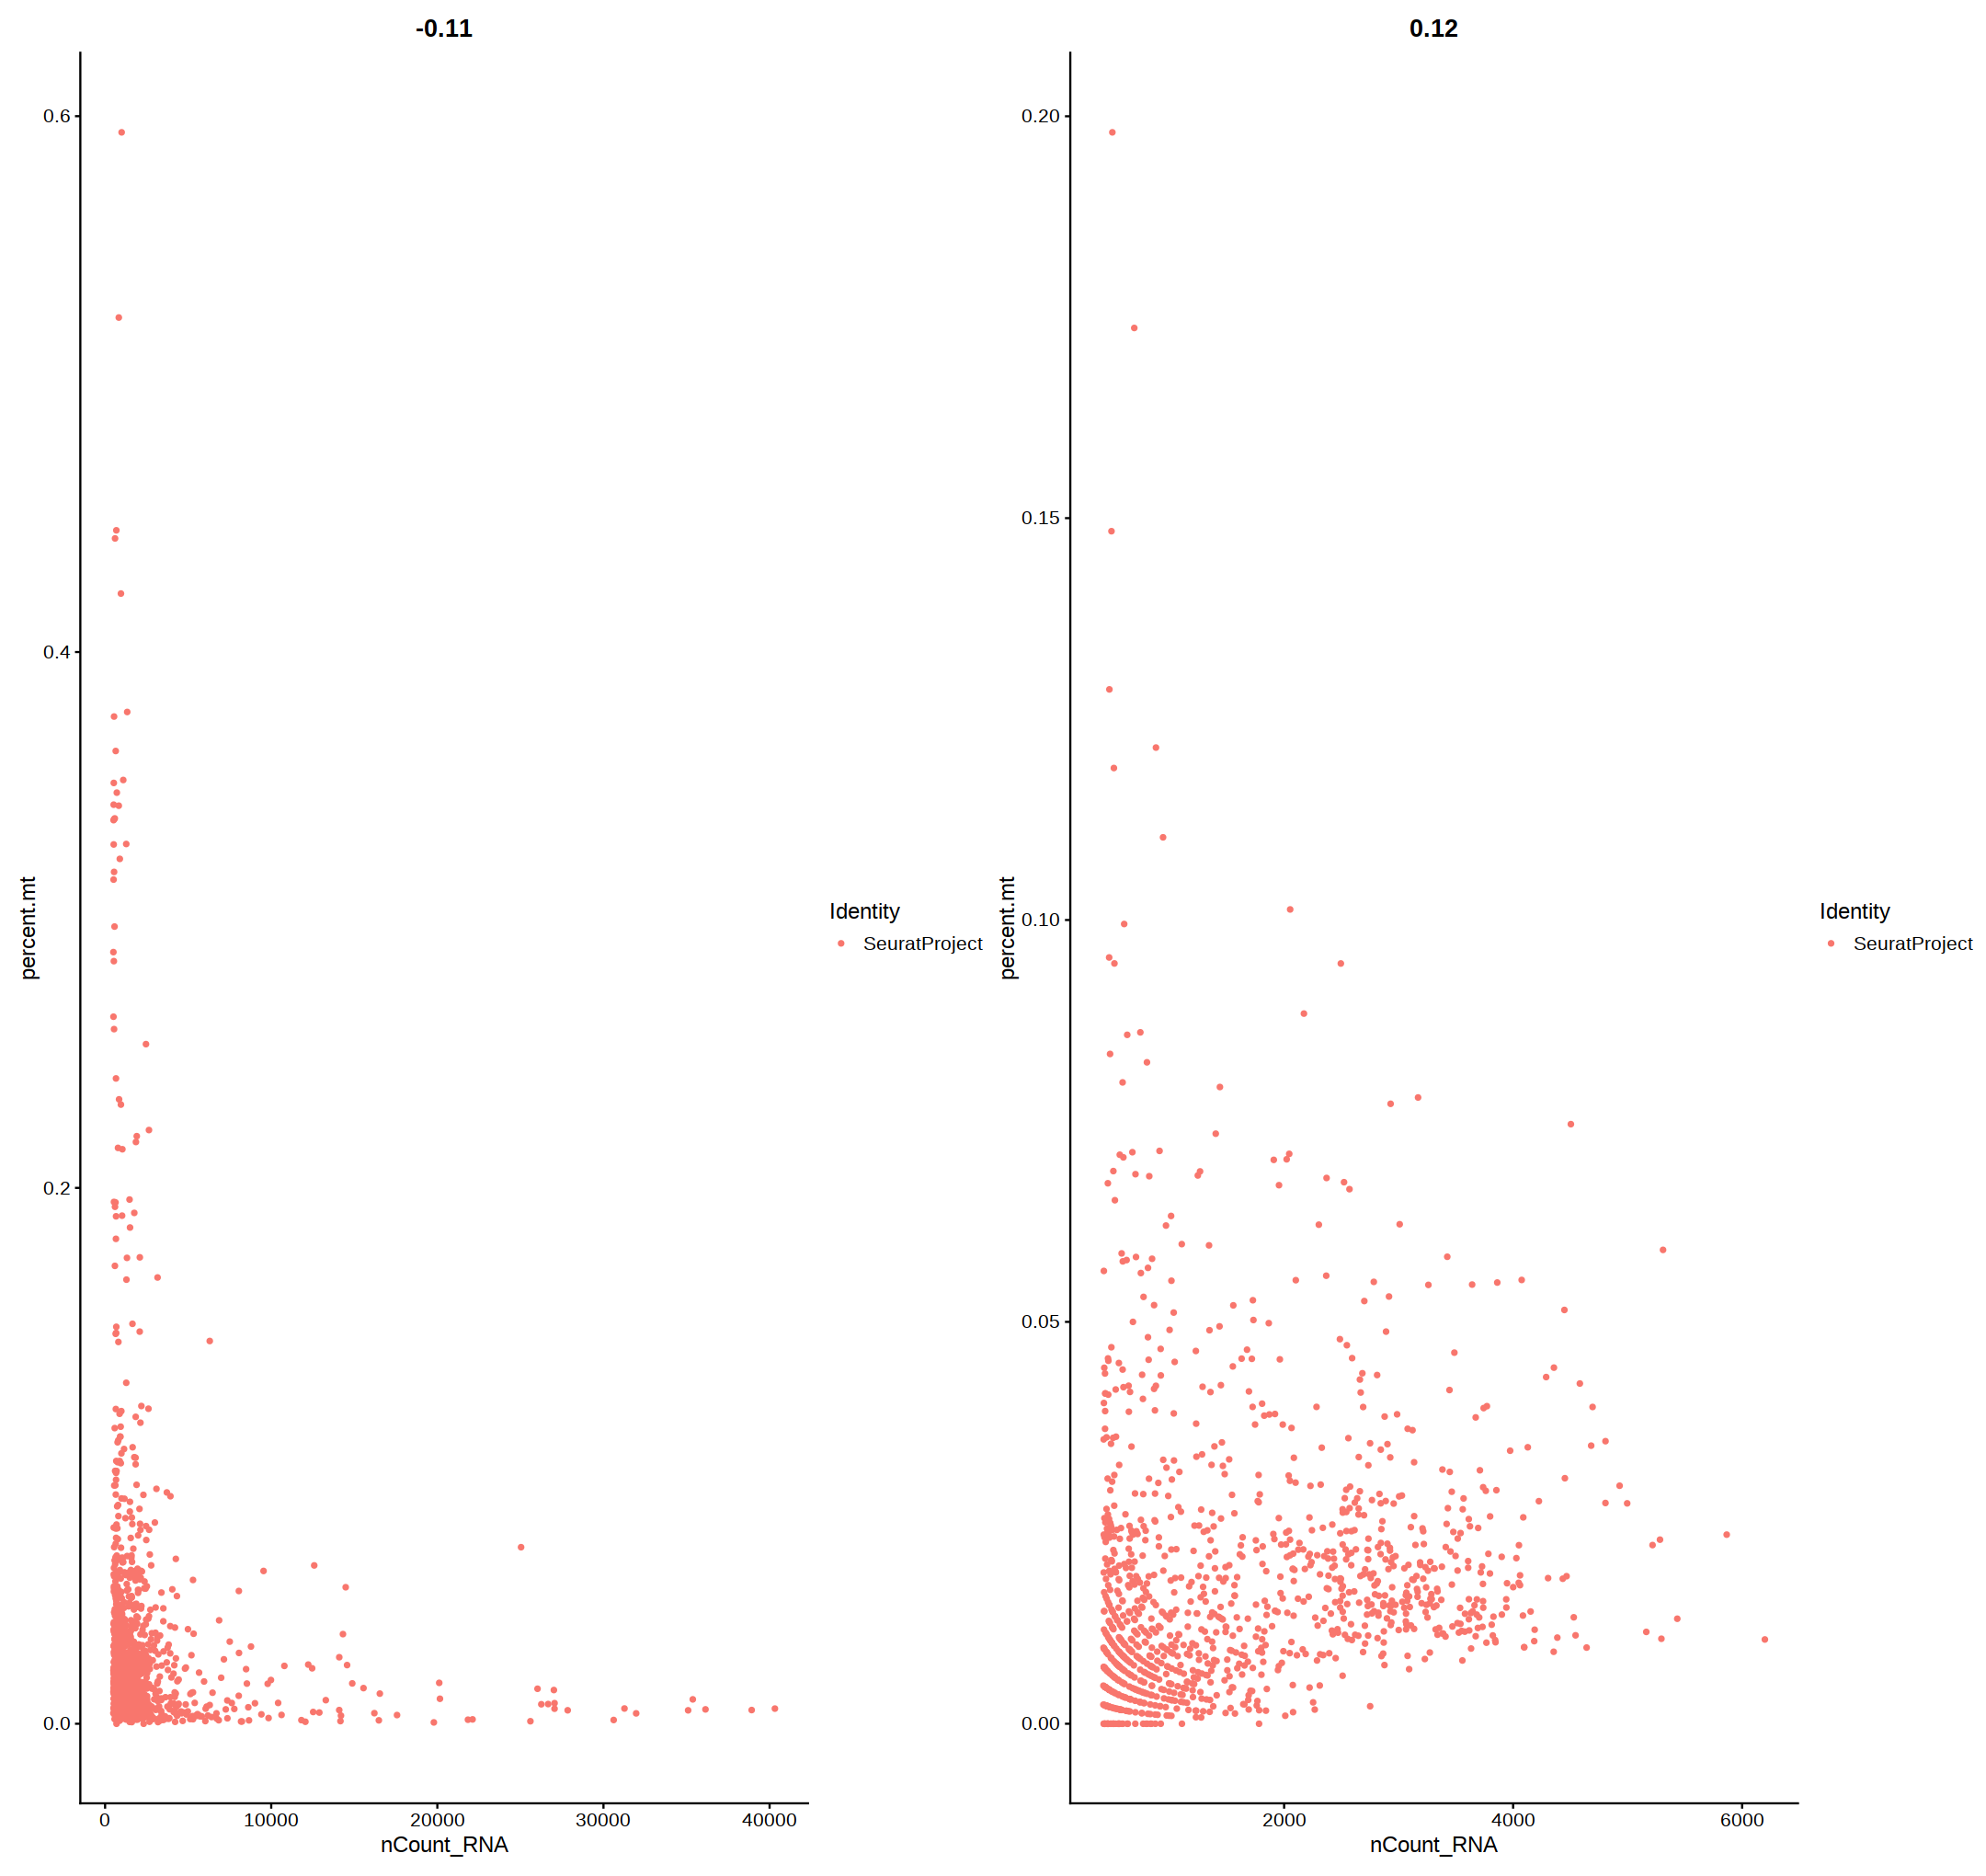

In [17]:
scatter_J7_15112017 + scatter_J7_31082017

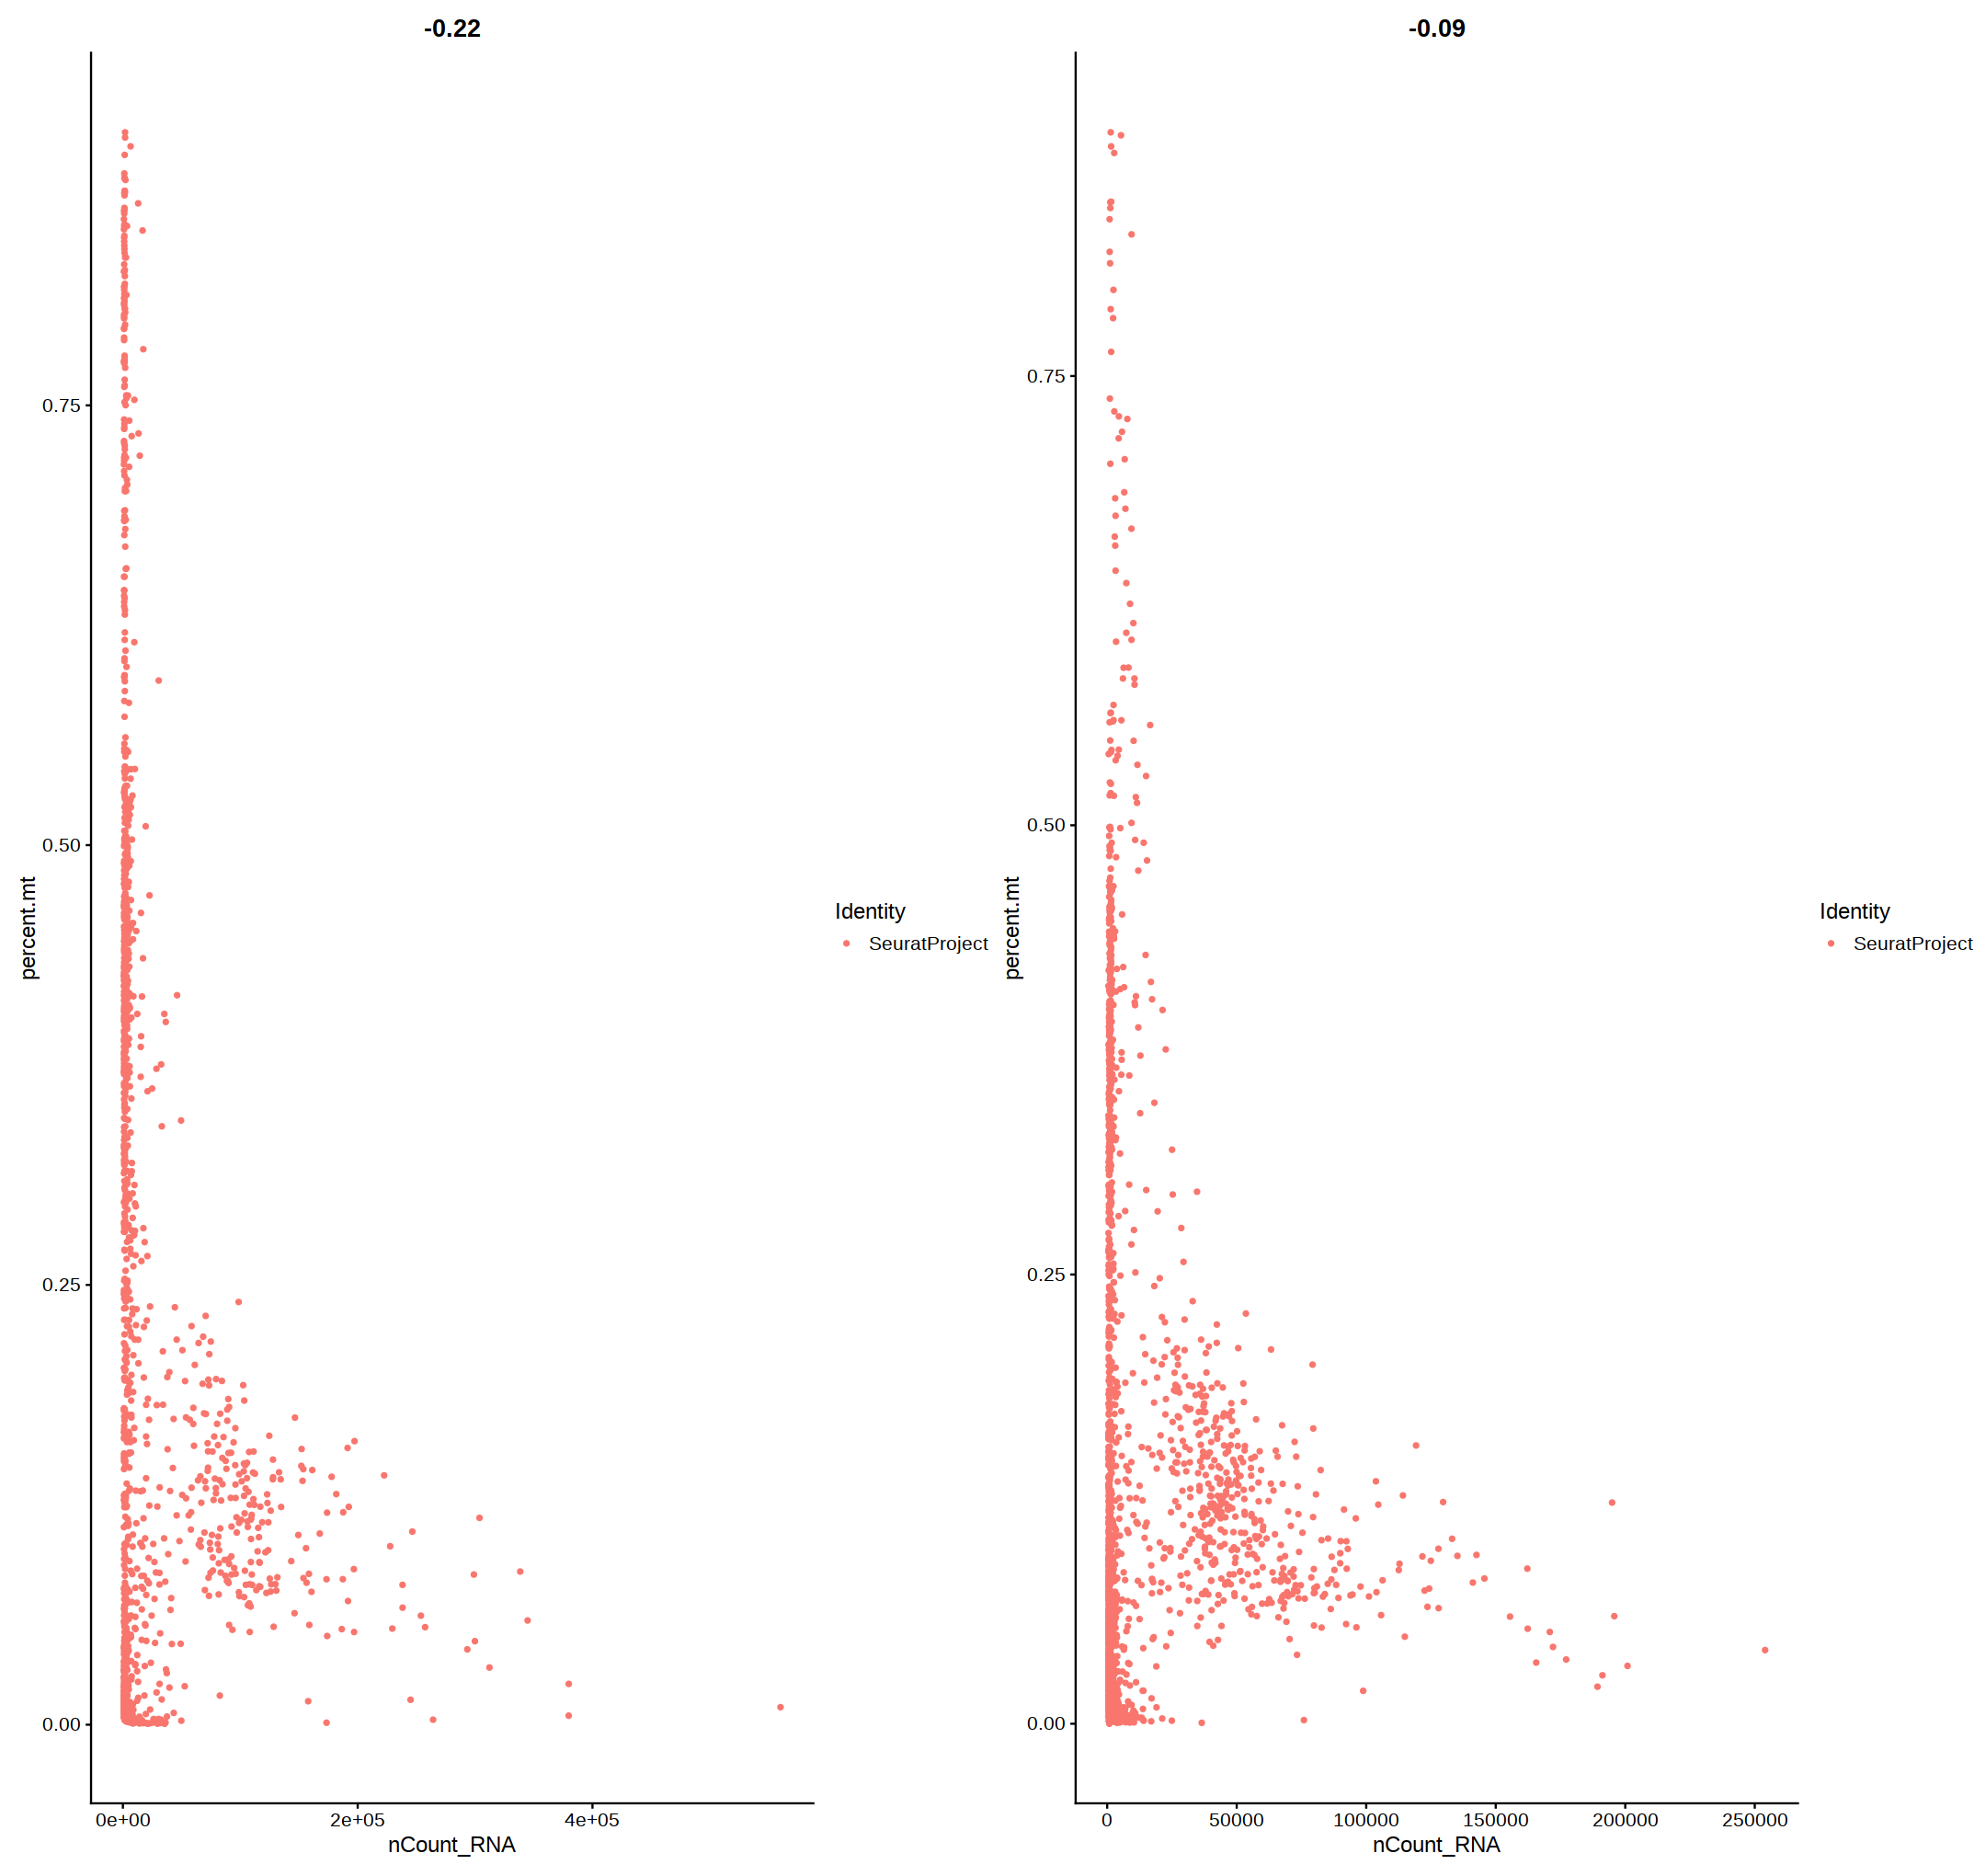

In [18]:
scatter_J7_3 + scatter_J7_4

In [19]:
embryo <- merge(x = J7_15112017, y = c(J7_31082017, J7_3, J7_4))

Warning message in CheckDuplicateCellNames(object.list = objects):
"Some cell names are duplicated across objects provided. Renaming to enforce unique cell names."


In [20]:
embryo <- NormalizeData(embryo) %>% FindVariableFeatures() %>% ScaleData() %>% RunPCA(verbose = FALSE)
embryo.integrated <- RunHarmony(embryo, group.by.vars = "SAMP")

Centering and scaling data matrix

Harmony 1/10

Harmony 2/10

Harmony 3/10

Harmony 4/10

Harmony 5/10

Harmony 6/10

Harmony 7/10

Harmony converged after 7 iterations

Warning message:
"Invalid name supplied, making object name syntactically valid. New object name is Seurat..ProjectDim.RNA.harmony; see ?make.names for more details on syntax validity"


# Doublet generation with doubletFinder

Generating artifical doublet

Le chargement a nécessité le package : fields

Le chargement a nécessité le package : spam

Le chargement a nécessité le package : dotCall64

Le chargement a nécessité le package : grid

Spam version 2.7-0 (2021-06-25) is loaded.
Type 'help( Spam)' or 'demo( spam)' for a short introduction 
and overview of this package.
Help for individual functions is also obtained by adding the
suffix '.spam' to the function name, e.g. 'help( chol.spam)'.


Attachement du package : 'spam'


L'objet suivant est masqué depuis 'package:AnnotationHub':

    display


L'objet suivant est masqué depuis 'package:stats4':

    mle


Les objets suivants sont masqués depuis 'package:base':

    backsolve, forwardsolve


Le chargement a nécessité le package : viridis

Le chargement a nécessité le package : viridisLite


Try help(fields) to get started.



[1] "Creating artificial doublets for pN = 5%"
[1] "Creating Seurat object..."
[1] "Normalizing Seurat object..."
[1] "Finding variable genes..."
[1] "Scaling data..."


Centering and scaling data matrix



[1] "Running PCA..."
[1] "Calculating PC distance matrix..."
[1] "Defining neighborhoods..."
[1] "Computing pANN across all pK..."
[1] "pK = 0.005..."
[1] "pK = 0.01..."
[1] "pK = 0.02..."
[1] "pK = 0.03..."
[1] "pK = 0.04..."
[1] "pK = 0.05..."
[1] "pK = 0.06..."
[1] "pK = 0.07..."
[1] "pK = 0.08..."
[1] "pK = 0.09..."
[1] "pK = 0.1..."
[1] "pK = 0.11..."
[1] "pK = 0.12..."
[1] "pK = 0.13..."
[1] "pK = 0.14..."
[1] "pK = 0.15..."
[1] "pK = 0.16..."
[1] "pK = 0.17..."
[1] "pK = 0.18..."
[1] "pK = 0.19..."
[1] "pK = 0.2..."
[1] "pK = 0.21..."
[1] "pK = 0.22..."
[1] "pK = 0.23..."
[1] "pK = 0.24..."
[1] "pK = 0.25..."
[1] "pK = 0.26..."
[1] "pK = 0.27..."
[1] "pK = 0.28..."
[1] "pK = 0.29..."
[1] "pK = 0.3..."
[1] "Creating artificial doublets for pN = 10%"
[1] "Creating Seurat object..."
[1] "Normalizing Seurat object..."
[1] "Finding variable genes..."
[1] "Scaling data..."


Centering and scaling data matrix



[1] "Running PCA..."
[1] "Calculating PC distance matrix..."
[1] "Defining neighborhoods..."
[1] "Computing pANN across all pK..."
[1] "pK = 0.005..."
[1] "pK = 0.01..."
[1] "pK = 0.02..."
[1] "pK = 0.03..."
[1] "pK = 0.04..."
[1] "pK = 0.05..."
[1] "pK = 0.06..."
[1] "pK = 0.07..."
[1] "pK = 0.08..."
[1] "pK = 0.09..."
[1] "pK = 0.1..."
[1] "pK = 0.11..."
[1] "pK = 0.12..."
[1] "pK = 0.13..."
[1] "pK = 0.14..."
[1] "pK = 0.15..."
[1] "pK = 0.16..."
[1] "pK = 0.17..."
[1] "pK = 0.18..."
[1] "pK = 0.19..."
[1] "pK = 0.2..."
[1] "pK = 0.21..."
[1] "pK = 0.22..."
[1] "pK = 0.23..."
[1] "pK = 0.24..."
[1] "pK = 0.25..."
[1] "pK = 0.26..."
[1] "pK = 0.27..."
[1] "pK = 0.28..."
[1] "pK = 0.29..."
[1] "pK = 0.3..."
[1] "Creating artificial doublets for pN = 15%"
[1] "Creating Seurat object..."
[1] "Normalizing Seurat object..."
[1] "Finding variable genes..."
[1] "Scaling data..."


Centering and scaling data matrix



[1] "Running PCA..."
[1] "Calculating PC distance matrix..."
[1] "Defining neighborhoods..."
[1] "Computing pANN across all pK..."
[1] "pK = 0.005..."
[1] "pK = 0.01..."
[1] "pK = 0.02..."
[1] "pK = 0.03..."
[1] "pK = 0.04..."
[1] "pK = 0.05..."
[1] "pK = 0.06..."
[1] "pK = 0.07..."
[1] "pK = 0.08..."
[1] "pK = 0.09..."
[1] "pK = 0.1..."
[1] "pK = 0.11..."
[1] "pK = 0.12..."
[1] "pK = 0.13..."
[1] "pK = 0.14..."
[1] "pK = 0.15..."
[1] "pK = 0.16..."
[1] "pK = 0.17..."
[1] "pK = 0.18..."
[1] "pK = 0.19..."
[1] "pK = 0.2..."
[1] "pK = 0.21..."
[1] "pK = 0.22..."
[1] "pK = 0.23..."
[1] "pK = 0.24..."
[1] "pK = 0.25..."
[1] "pK = 0.26..."
[1] "pK = 0.27..."
[1] "pK = 0.28..."
[1] "pK = 0.29..."
[1] "pK = 0.3..."
[1] "Creating artificial doublets for pN = 20%"
[1] "Creating Seurat object..."
[1] "Normalizing Seurat object..."
[1] "Finding variable genes..."
[1] "Scaling data..."


Centering and scaling data matrix



[1] "Running PCA..."
[1] "Calculating PC distance matrix..."
[1] "Defining neighborhoods..."
[1] "Computing pANN across all pK..."
[1] "pK = 0.005..."
[1] "pK = 0.01..."
[1] "pK = 0.02..."
[1] "pK = 0.03..."
[1] "pK = 0.04..."
[1] "pK = 0.05..."
[1] "pK = 0.06..."
[1] "pK = 0.07..."
[1] "pK = 0.08..."
[1] "pK = 0.09..."
[1] "pK = 0.1..."
[1] "pK = 0.11..."
[1] "pK = 0.12..."
[1] "pK = 0.13..."
[1] "pK = 0.14..."
[1] "pK = 0.15..."
[1] "pK = 0.16..."
[1] "pK = 0.17..."
[1] "pK = 0.18..."
[1] "pK = 0.19..."
[1] "pK = 0.2..."
[1] "pK = 0.21..."
[1] "pK = 0.22..."
[1] "pK = 0.23..."
[1] "pK = 0.24..."
[1] "pK = 0.25..."
[1] "pK = 0.26..."
[1] "pK = 0.27..."
[1] "pK = 0.28..."
[1] "pK = 0.29..."
[1] "pK = 0.3..."
[1] "Creating artificial doublets for pN = 25%"
[1] "Creating Seurat object..."
[1] "Normalizing Seurat object..."
[1] "Finding variable genes..."
[1] "Scaling data..."


Centering and scaling data matrix



[1] "Running PCA..."
[1] "Calculating PC distance matrix..."
[1] "Defining neighborhoods..."
[1] "Computing pANN across all pK..."
[1] "pK = 0.005..."
[1] "pK = 0.01..."
[1] "pK = 0.02..."
[1] "pK = 0.03..."
[1] "pK = 0.04..."
[1] "pK = 0.05..."
[1] "pK = 0.06..."
[1] "pK = 0.07..."
[1] "pK = 0.08..."
[1] "pK = 0.09..."
[1] "pK = 0.1..."
[1] "pK = 0.11..."
[1] "pK = 0.12..."
[1] "pK = 0.13..."
[1] "pK = 0.14..."
[1] "pK = 0.15..."
[1] "pK = 0.16..."
[1] "pK = 0.17..."
[1] "pK = 0.18..."
[1] "pK = 0.19..."
[1] "pK = 0.2..."
[1] "pK = 0.21..."
[1] "pK = 0.22..."
[1] "pK = 0.23..."
[1] "pK = 0.24..."
[1] "pK = 0.25..."
[1] "pK = 0.26..."
[1] "pK = 0.27..."
[1] "pK = 0.28..."
[1] "pK = 0.29..."
[1] "pK = 0.3..."
[1] "Creating artificial doublets for pN = 30%"
[1] "Creating Seurat object..."
[1] "Normalizing Seurat object..."
[1] "Finding variable genes..."
[1] "Scaling data..."


Centering and scaling data matrix



[1] "Running PCA..."
[1] "Calculating PC distance matrix..."
[1] "Defining neighborhoods..."
[1] "Computing pANN across all pK..."
[1] "pK = 0.005..."
[1] "pK = 0.01..."
[1] "pK = 0.02..."
[1] "pK = 0.03..."
[1] "pK = 0.04..."
[1] "pK = 0.05..."
[1] "pK = 0.06..."
[1] "pK = 0.07..."
[1] "pK = 0.08..."
[1] "pK = 0.09..."
[1] "pK = 0.1..."
[1] "pK = 0.11..."
[1] "pK = 0.12..."
[1] "pK = 0.13..."
[1] "pK = 0.14..."
[1] "pK = 0.15..."
[1] "pK = 0.16..."
[1] "pK = 0.17..."
[1] "pK = 0.18..."
[1] "pK = 0.19..."
[1] "pK = 0.2..."
[1] "pK = 0.21..."
[1] "pK = 0.22..."
[1] "pK = 0.23..."
[1] "pK = 0.24..."
[1] "pK = 0.25..."
[1] "pK = 0.26..."
[1] "pK = 0.27..."
[1] "pK = 0.28..."
[1] "pK = 0.29..."
[1] "pK = 0.3..."


Le chargement a nécessité le package : KernSmooth

KernSmooth 2.23 loaded
Copyright M. P. Wand 1997-2009

Le chargement a nécessité le package : ROCR



NULL


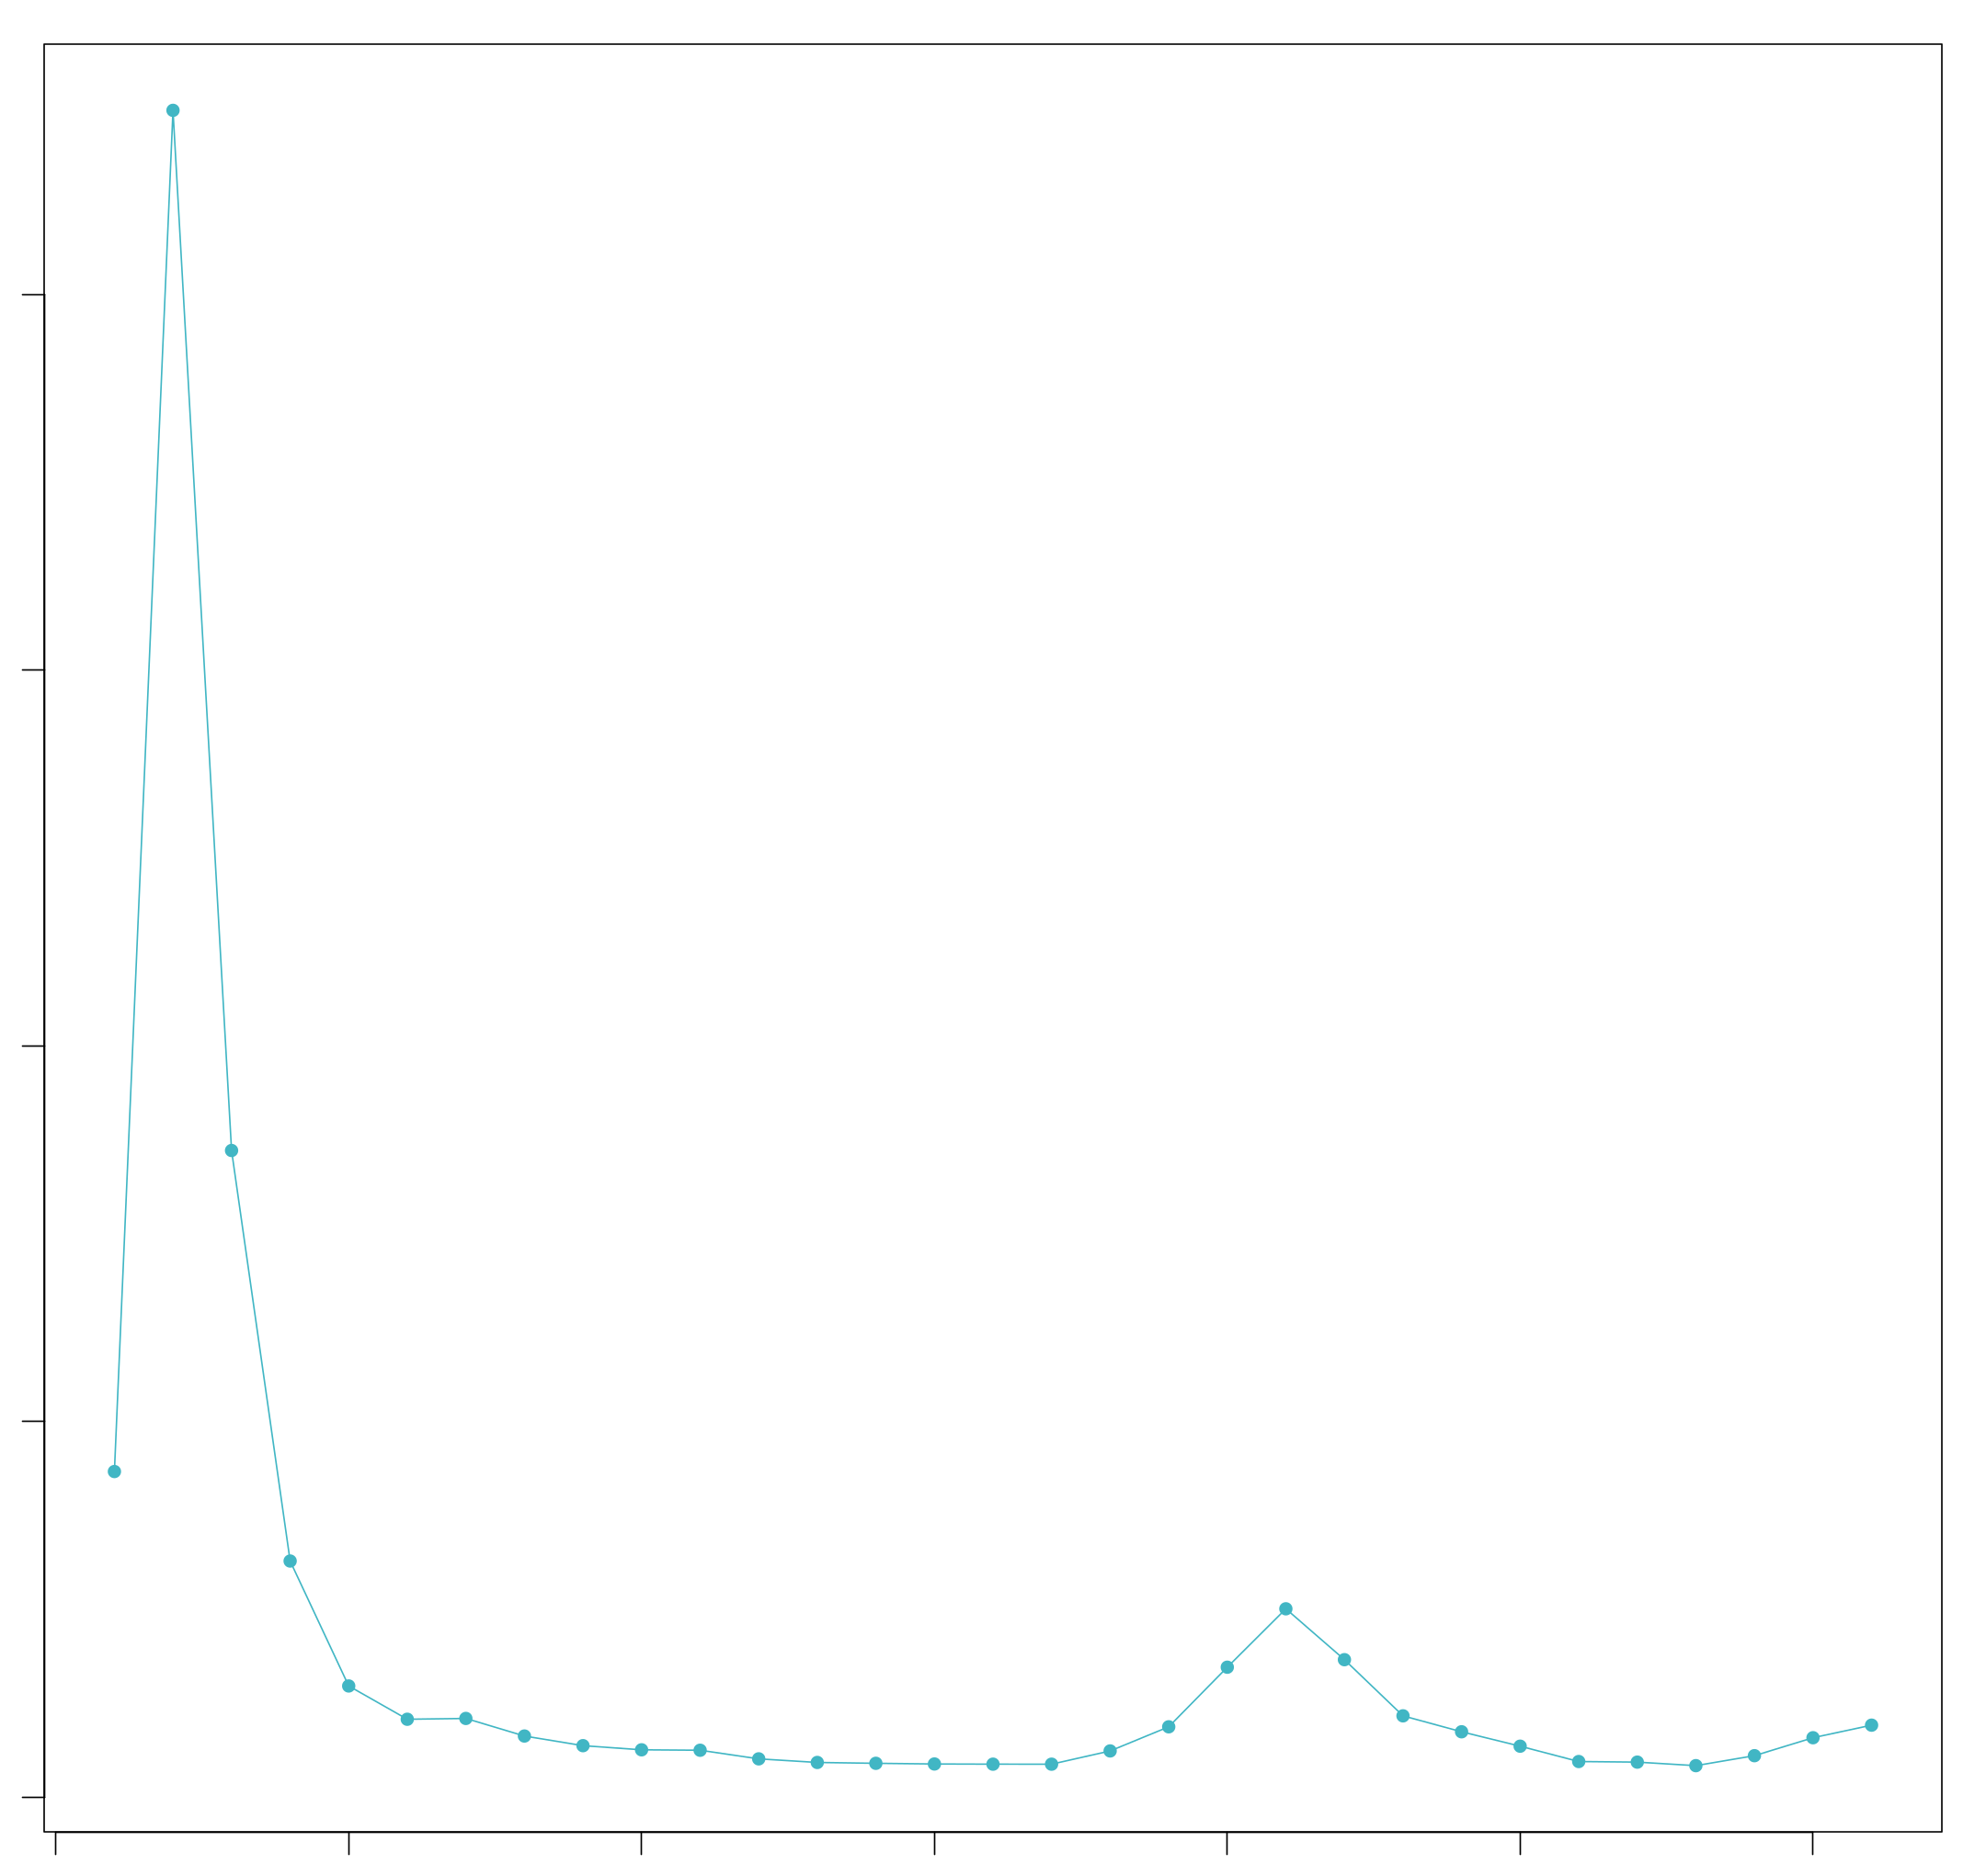

In [22]:
sweep.res.list <- paramSweep_v3(embryo.integrated, PCs = 1:20, sct = FALSE)
sweep.stats <- summarizeSweep(sweep.res.list, GT = FALSE)
bcmvn <- find.pK(sweep.stats)

Add clustering information

In [23]:
annotations <- embryo.integrated@meta.data$seurat.cluster
homotypic.prop <- modelHomotypic(annotations)

Assuming 5% doublet formation rate

In [24]:
nExp_poi <- round(0.05*nrow(embryo.integrated@meta.data))
nExp_poi.adj <- round(nExp_poi*(1-homotypic.prop))

In [25]:
embryo.integrated <- doubletFinder_v3(embryo.integrated, PCs = 1:20, pN = 0.25, pK = 0.09, nExp = nExp_poi, reuse.pANN = FALSE, sct = FALSE)

[1] "Creating 2026 artificial doublets..."
[1] "Creating Seurat object..."
[1] "Normalizing Seurat object..."
[1] "Finding variable genes..."
[1] "Scaling data..."


Centering and scaling data matrix



[1] "Running PCA..."
[1] "Calculating PC distance matrix..."
[1] "Computing pANN..."
[1] "Classifying doublets.."


In [26]:
pann <- grep("pANN", colnames(embryo.integrated@meta.data), value=TRUE)

In [27]:
embryo.integrated <- doubletFinder_v3(embryo.integrated, PCs = 1:20, pN = 0.25, pK = 0.09, nExp = nExp_poi.adj, reuse.pANN = pann, sct = FALSE)

In [28]:
dfclassif <- grep("DF.classifications_", colnames(embryo.integrated@meta.data), value=TRUE)

Visualization fo doublet classification

Warning message:
"The default method for RunUMAP has changed from calling Python UMAP via reticulate to the R-native UWOT using the cosine metric
To use Python UMAP via reticulate, set umap.method to 'umap-learn' and metric to 'correlation'
This message will be shown once per session"
14:53:46 UMAP embedding parameters a = 0.9922 b = 1.112

Found more than one class "dist" in cache; using the first, from namespace 'BiocGenerics'

Also defined by 'spam'

14:53:46 Read 6077 rows and found 20 numeric columns

14:53:46 Using Annoy for neighbor search, n_neighbors = 30

Found more than one class "dist" in cache; using the first, from namespace 'BiocGenerics'

Also defined by 'spam'

14:53:46 Building Annoy index with metric = cosine, n_trees = 50

0%   10   20   30   40   50   60   70   80   90   100%

[----|----|----|----|----|----|----|----|----|----|

*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
|

14:53:47 Writing NN index file to t

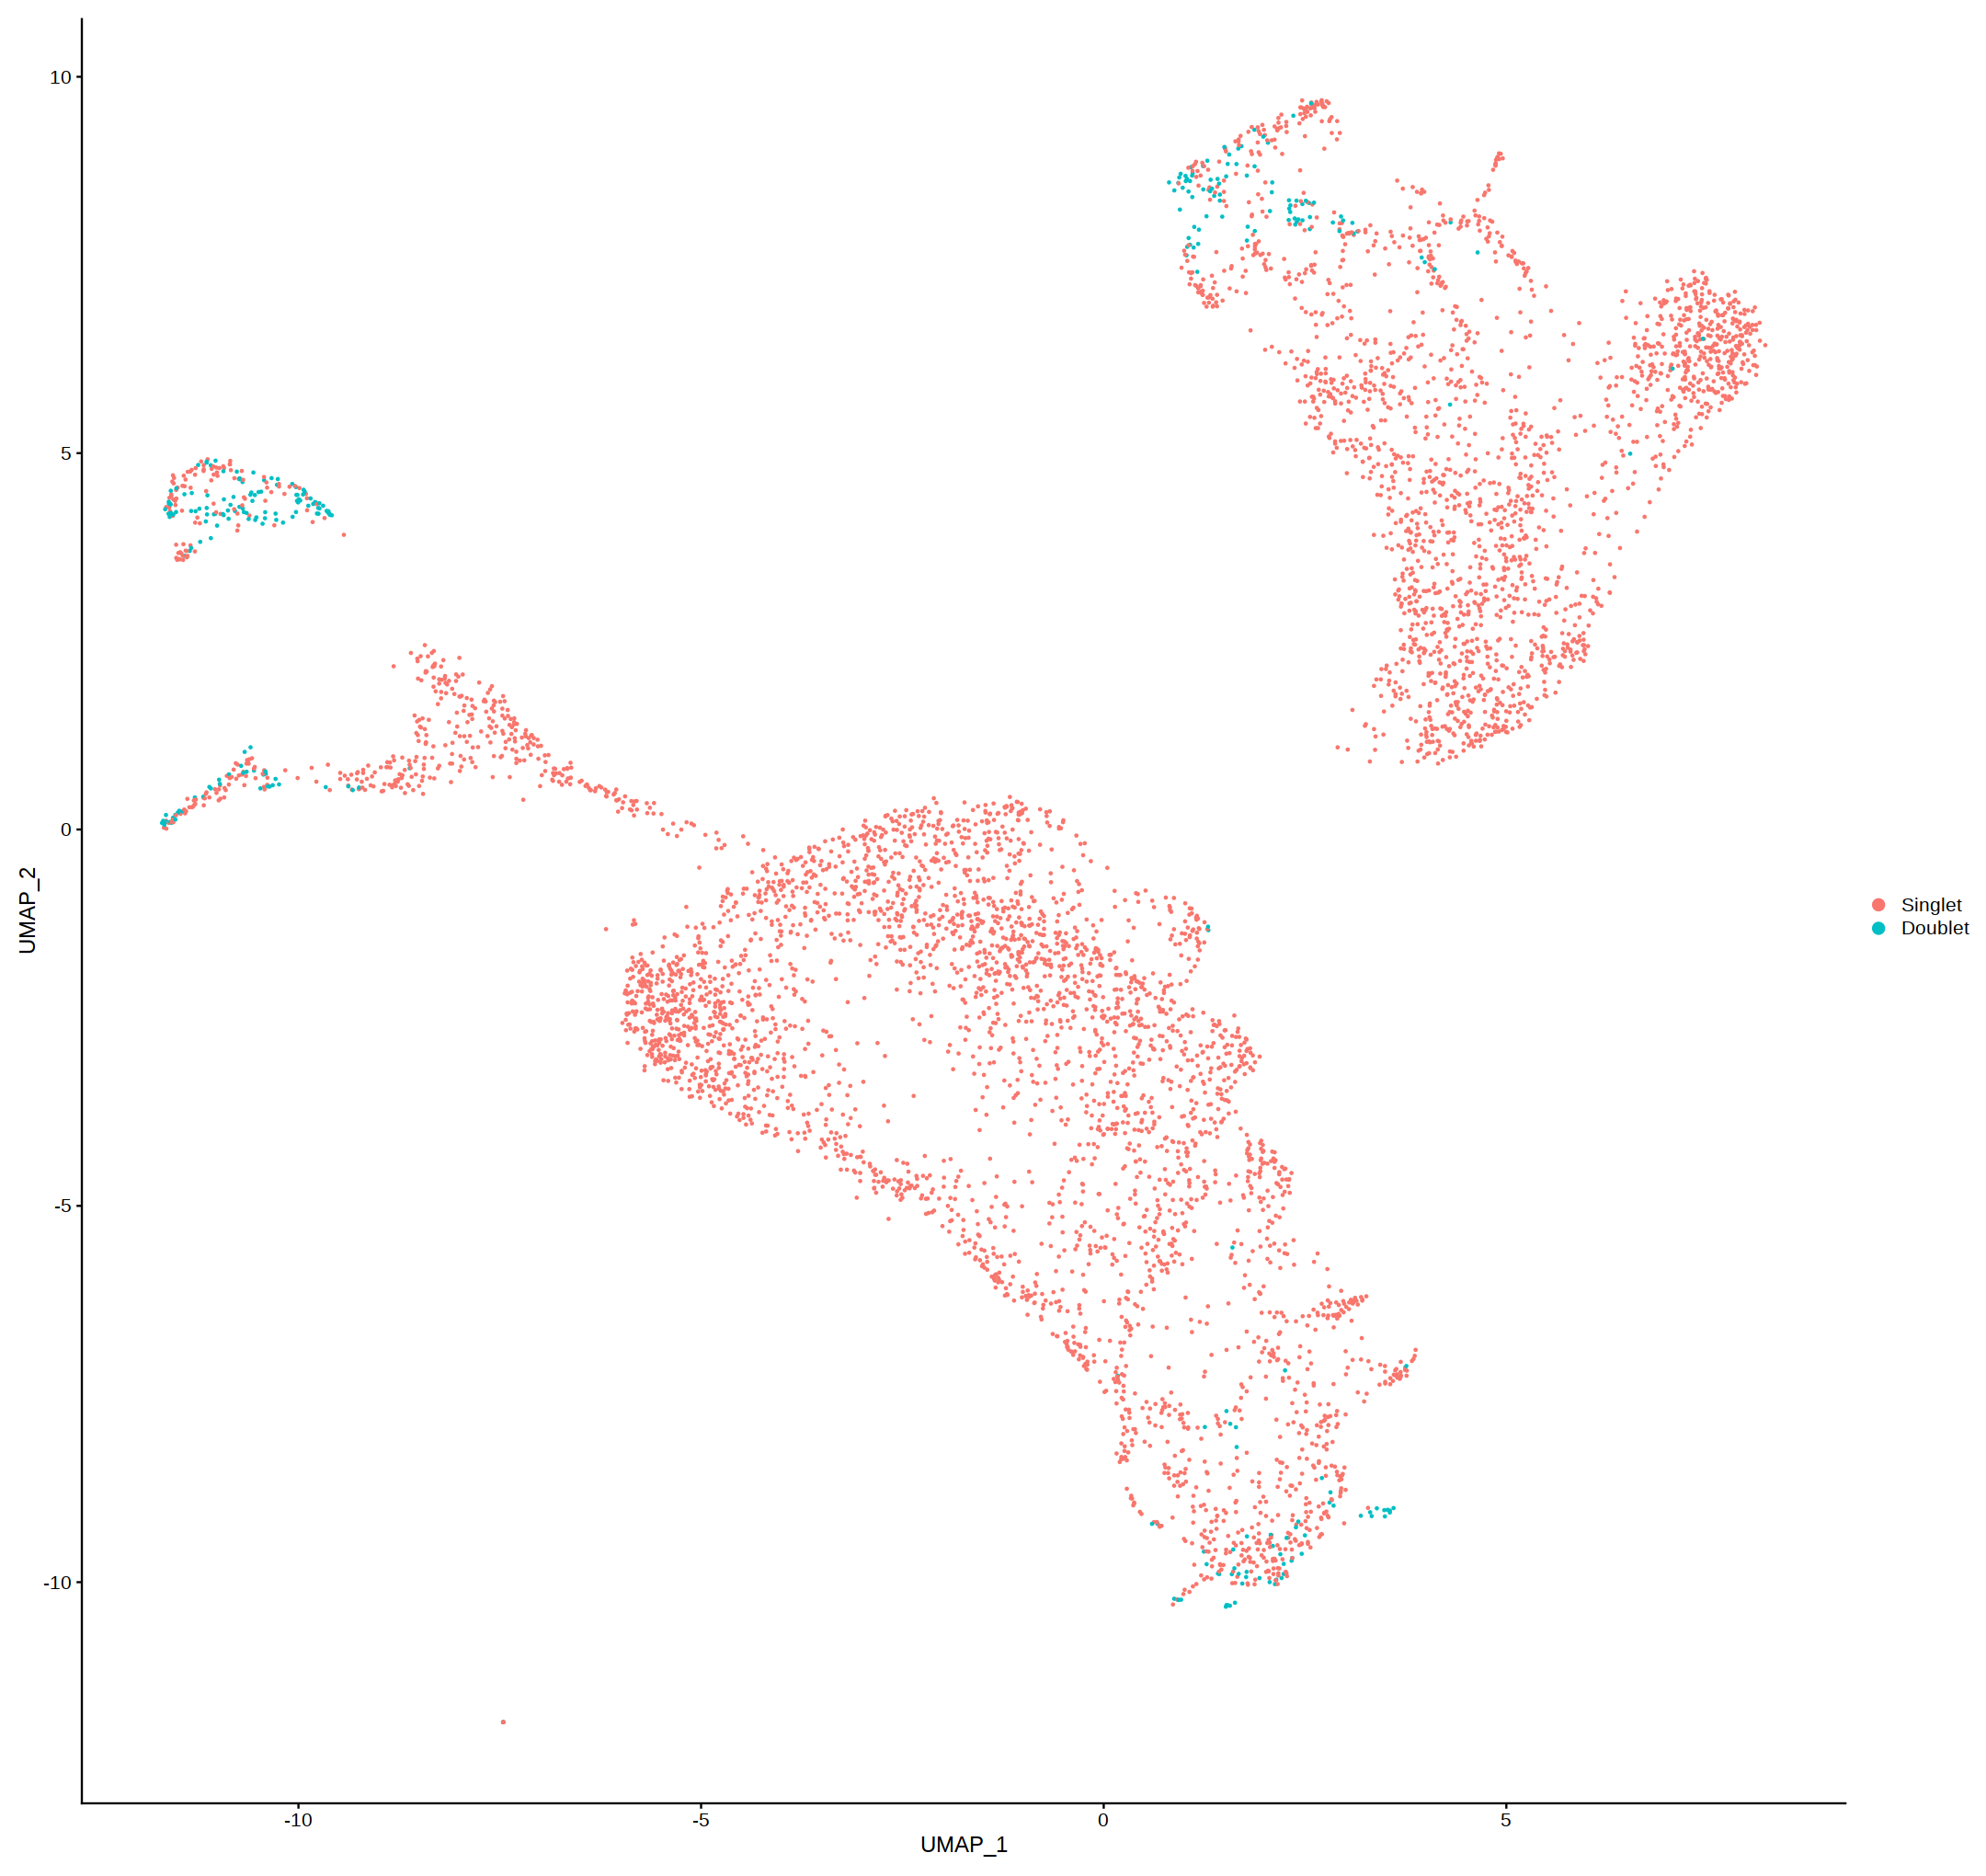

In [31]:
Idents(embryo.integrated) <- dfclassif
embryo.integrated <- RunUMAP(embryo.integrated, dims = 1:20)
DimPlot(embryo.integrated)

Saving plot

In [32]:
plot_umap_doublet_classification <- bind_cols(embryo.integrated@meta.data, as.data.frame(embryo.integrated@reductions$umap@cell.embeddings)) %>%
  ggplot(aes(UMAP_1, UMAP_2, color = get(eval(paste0(dfclassif))))) +
  geom_point(size = 0.2) +
  theme_bw() +
  scale_color_manual(values = c("#c0392b","#3498db")) +
  labs(color = 'Doublet Finder Classification') +
  guides(colour = guide_legend(override.aes = list(size = 2))) +
  theme(legend.position = 'right') +
  coord_fixed() +
  annotate(
    geom = 'text', x = Inf, y = -Inf,
    label = paste0('n = ', format(nrow(embryo.integrated@meta.data), big.mark = ',', trim = TRUE)),
    vjust = -1.5, hjust = 1.25, color = 'black', size = 2.5
  )

ggsave(
  '/home/adufour/work/notebook/seurat/plots/J7/dbfinder_J7.png',
  plot_umap_doublet_classification,
  height = 12,
  width = 14
)

Median calculation for plotting

In [33]:
median_nCount <- median(embryo.integrated@meta.data$nCount)
median_nFeature <- median(embryo.integrated@meta.data$nFeature)
median_percent_MT <- median(embryo.integrated@meta.data$percent.mt)

In [34]:
transcript_per_samples <- ggplot(embryo.integrated@meta.data, aes(x = SAMP, y = nCount_RNA, fill = SAMP)) +
  geom_violin(draw_quantiles = c(0.5), scale = 'area', trim = FALSE) +
  geom_hline(yintercept = median_nCount, color = 'black') +
  geom_hline(yintercept = 10000, color = 'red') +
  theme_bw() +
  scale_fill_manual(values = custom_colors$discrete) +
  scale_x_discrete(limits = levels(c("J7-1","J7-2","J7-3","J7-4"))) +
  scale_y_log10(labels = scales::comma) +
  labs(title = 'Number of transcripts', subtitle = 'log-scale') +
  theme(
    axis.title = element_blank(),
    panel.grid.major.y = element_blank(),
    panel.grid.minor.y = element_blank(),
    legend.position = 'none'
  ) +
  coord_flip()

genes_by_samples <- ggplot(embryo.integrated@meta.data, aes(x = SAMP, y = nFeature_RNA, fill = SAMP)) +
  geom_violin(draw_quantiles = c(0.5), scale = 'area', trim = FALSE) +
  geom_hline(yintercept = median_nFeature, color = 'black') +
  theme_bw() +
  scale_fill_manual(values = custom_colors$discrete) +
  scale_x_discrete(limits = levels(c("J7-1","J7-2","J7-3","J7-4"))) +
  scale_y_log10(labels = scales::comma) +
  labs(title = 'Number of expressed genes', subtitle = 'log-scale') +
  theme(
    axis.title = element_blank(),
    panel.grid.major.y = element_blank(),
    panel.grid.minor.y = element_blank(),
    legend.position = 'none'
  ) +
  coord_flip()

mitonchondrial_per_sample <- ggplot(embryo.integrated@meta.data, aes(x = SAMP, y = percent.mt*100, fill = SAMP)) +
  geom_violin(draw_quantiles = c(0.5), scale = 'area', trim = FALSE) +
  geom_hline(yintercept = median_percent_MT, color = 'black') +
  geom_hline(yintercept = 20, color = 'red') +
  theme_bw() +
  scale_fill_manual(values = custom_colors$discrete) +
  scale_x_discrete(limits = levels(c("J7-1","J7-2","J7-3","J7-4"))) +
  scale_y_continuous(labels = scales::percent_format(scale = 1)) +
  labs(title = 'Percent MT transcripts', subtitle = 'linear scale') +
  theme(
    axis.title = element_blank(),
    panel.grid.major.y = element_blank(),
    panel.grid.minor.y = element_blank(),
    legend.position = 'none'
  ) +
  coord_flip()

ggsave(
  '/home/adufour/work/notebook/seurat/plots/J7/qc_histogram_nCount_nFeature_percentMT_thresholds_J7.png',
  transcript_per_samples + genes_by_samples + mitonchondrial_per_sample + plot_layout(ncol = 3),
  height = 7, width = 10
)

Warning message in regularize.values(x, y, ties, missing(ties), na.rm = na.rm):
"collapsing to unique 'x' values"


Filtering data based on quality controls metrics

In [35]:
embryo.integrated <- subset(embryo.integrated, subset = nFeature_RNA > 300 & nCount_RNA < 10000 & percent.mt < 10)

Warning message:
"Transformation introduced infinite values in continuous x-axis"
Warning message:
"Removed 2932 rows containing missing values (geom_point)."


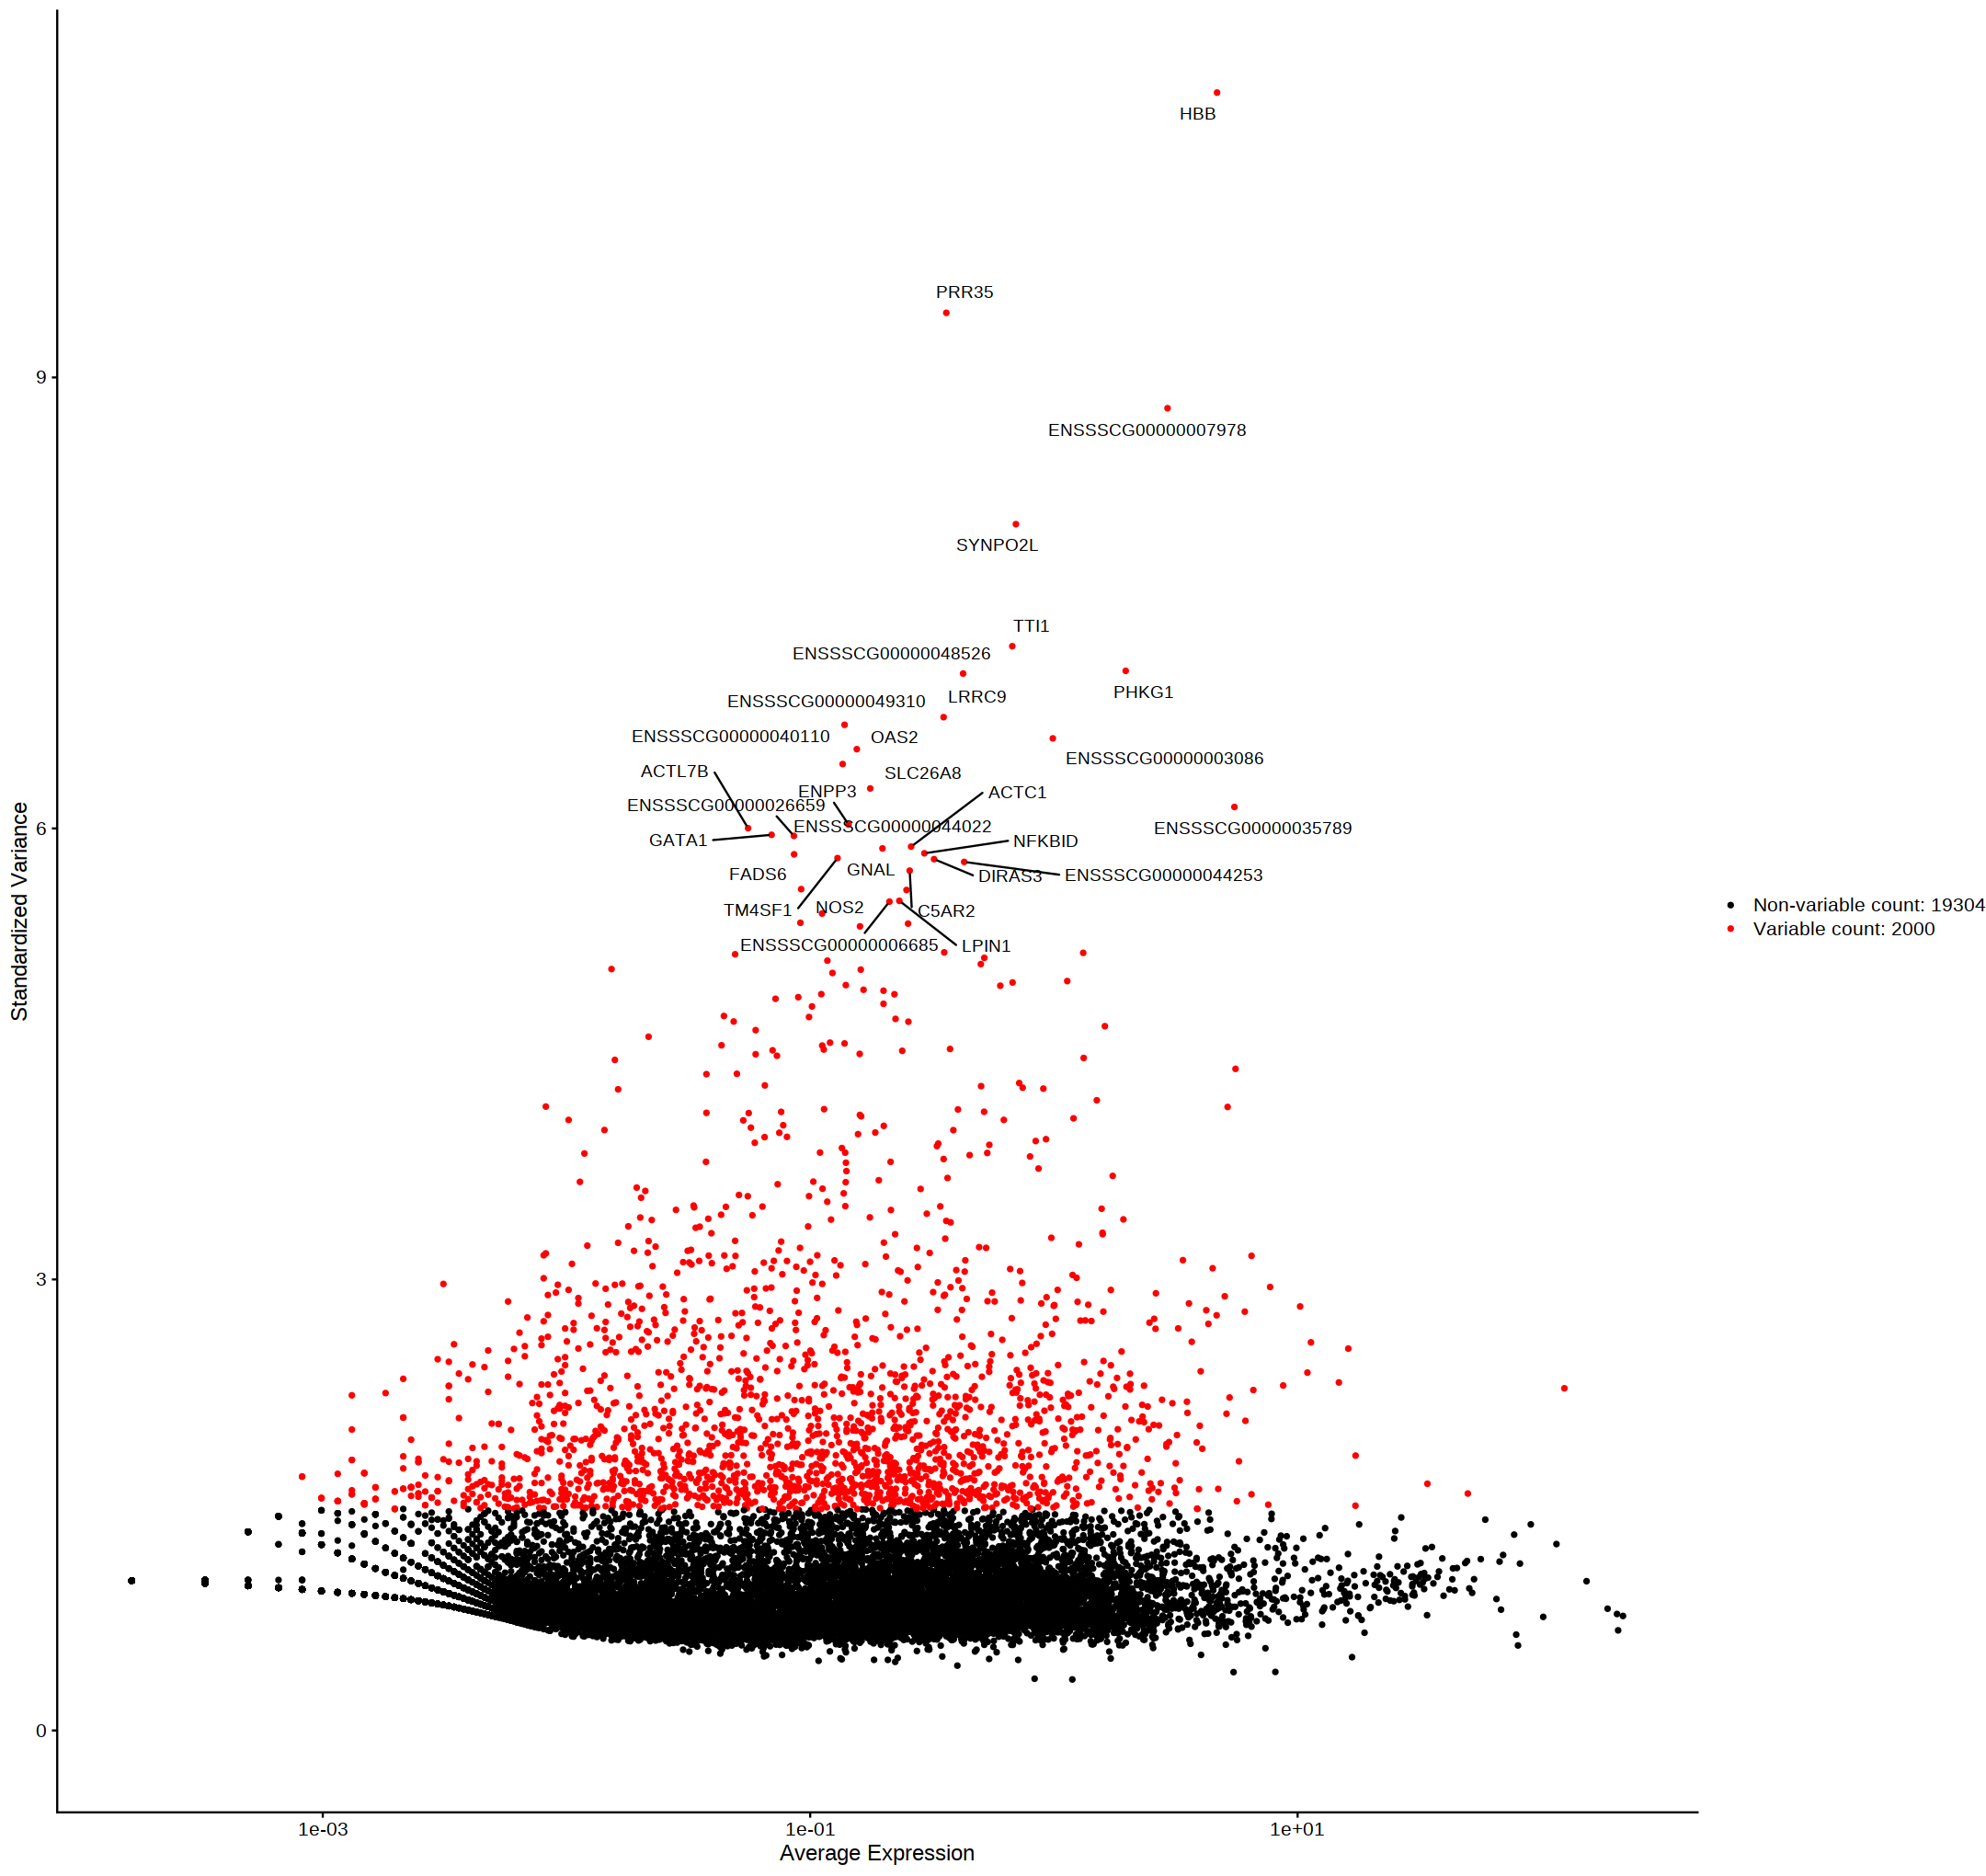

In [36]:
topfeature <- head(VariableFeatures(embryo.integrated), 30)
plotfeature <- VariableFeaturePlot(embryo.integrated)
LabelPoints(plot = plotfeature, points = topfeature, repel = TRUE, xnudge = 0, ynudge = 0, max.overlaps = 30)

In [37]:
embryo.integrated

An object of class Seurat 
21304 features across 4228 samples within 1 assay 
Active assay: RNA (21304 features, 2000 variable features)
 3 dimensional reductions calculated: pca, harmony, umap

# Visualization fo the different principal composant

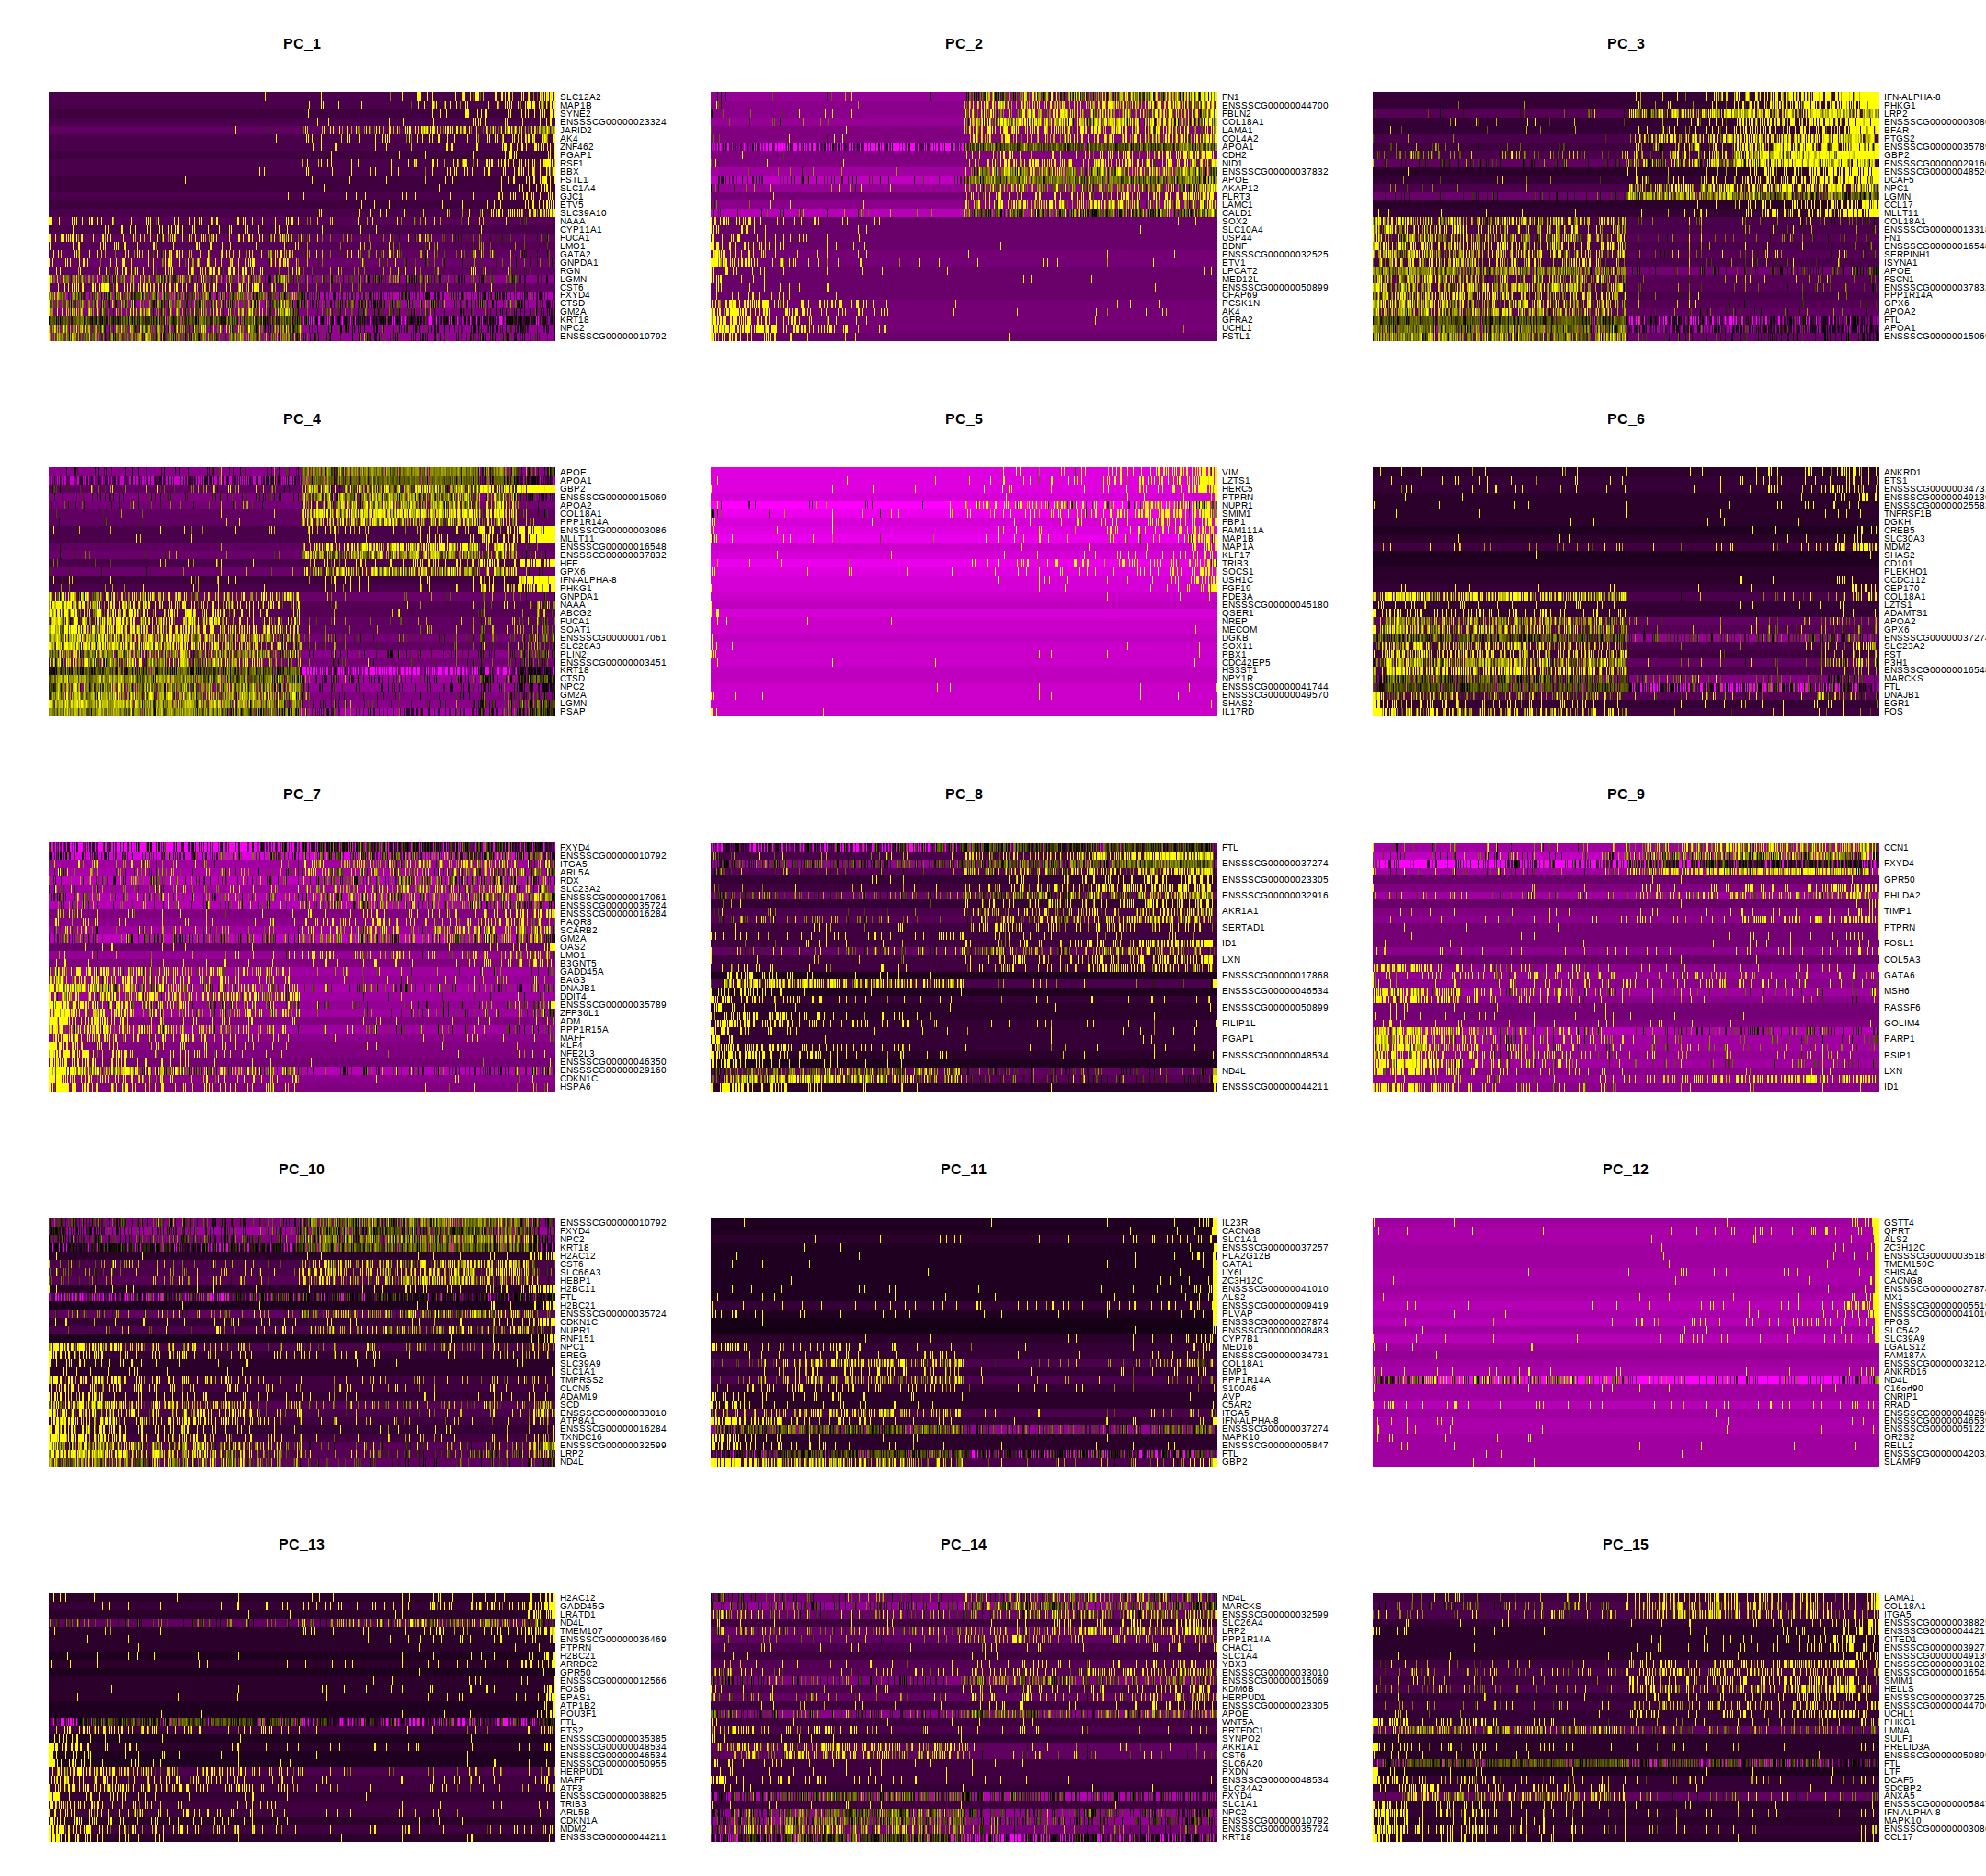

In [38]:
DimHeatmap(embryo.integrated, dims = 1:15, cells = 1000, balanced = TRUE)

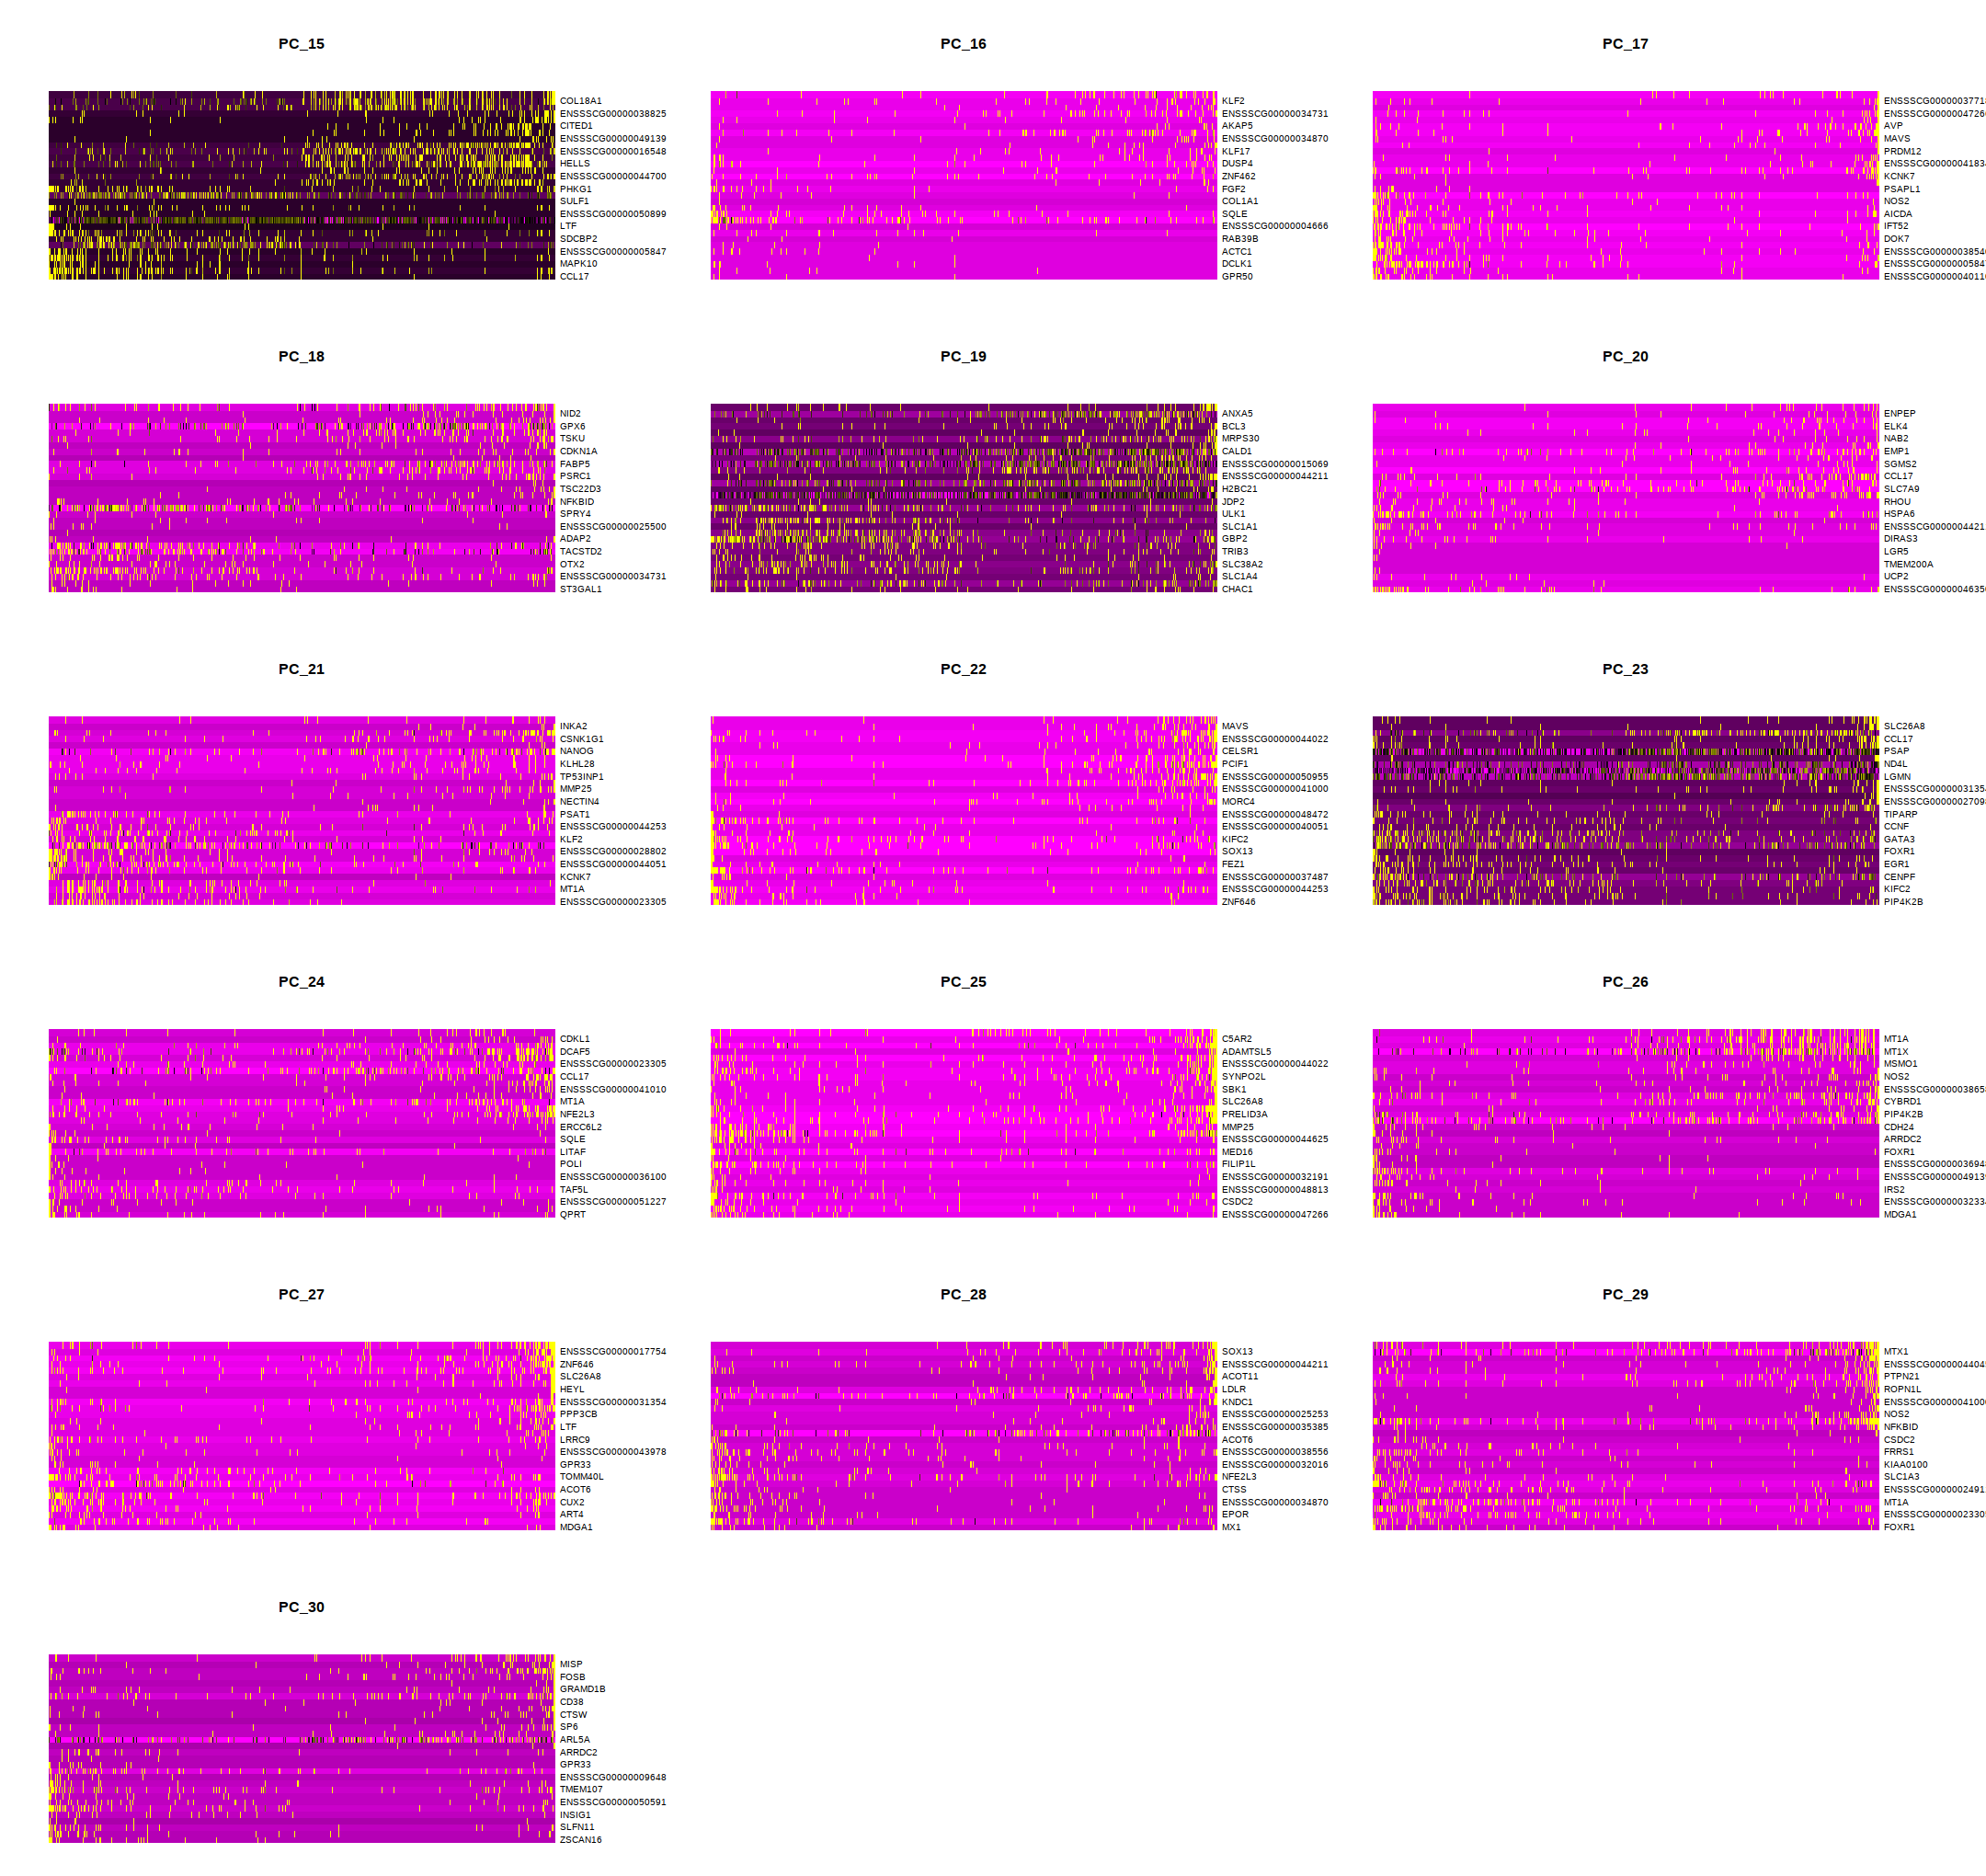

In [39]:
DimHeatmap(embryo.integrated, dims = 15:30, cells = 1000, balanced = TRUE)

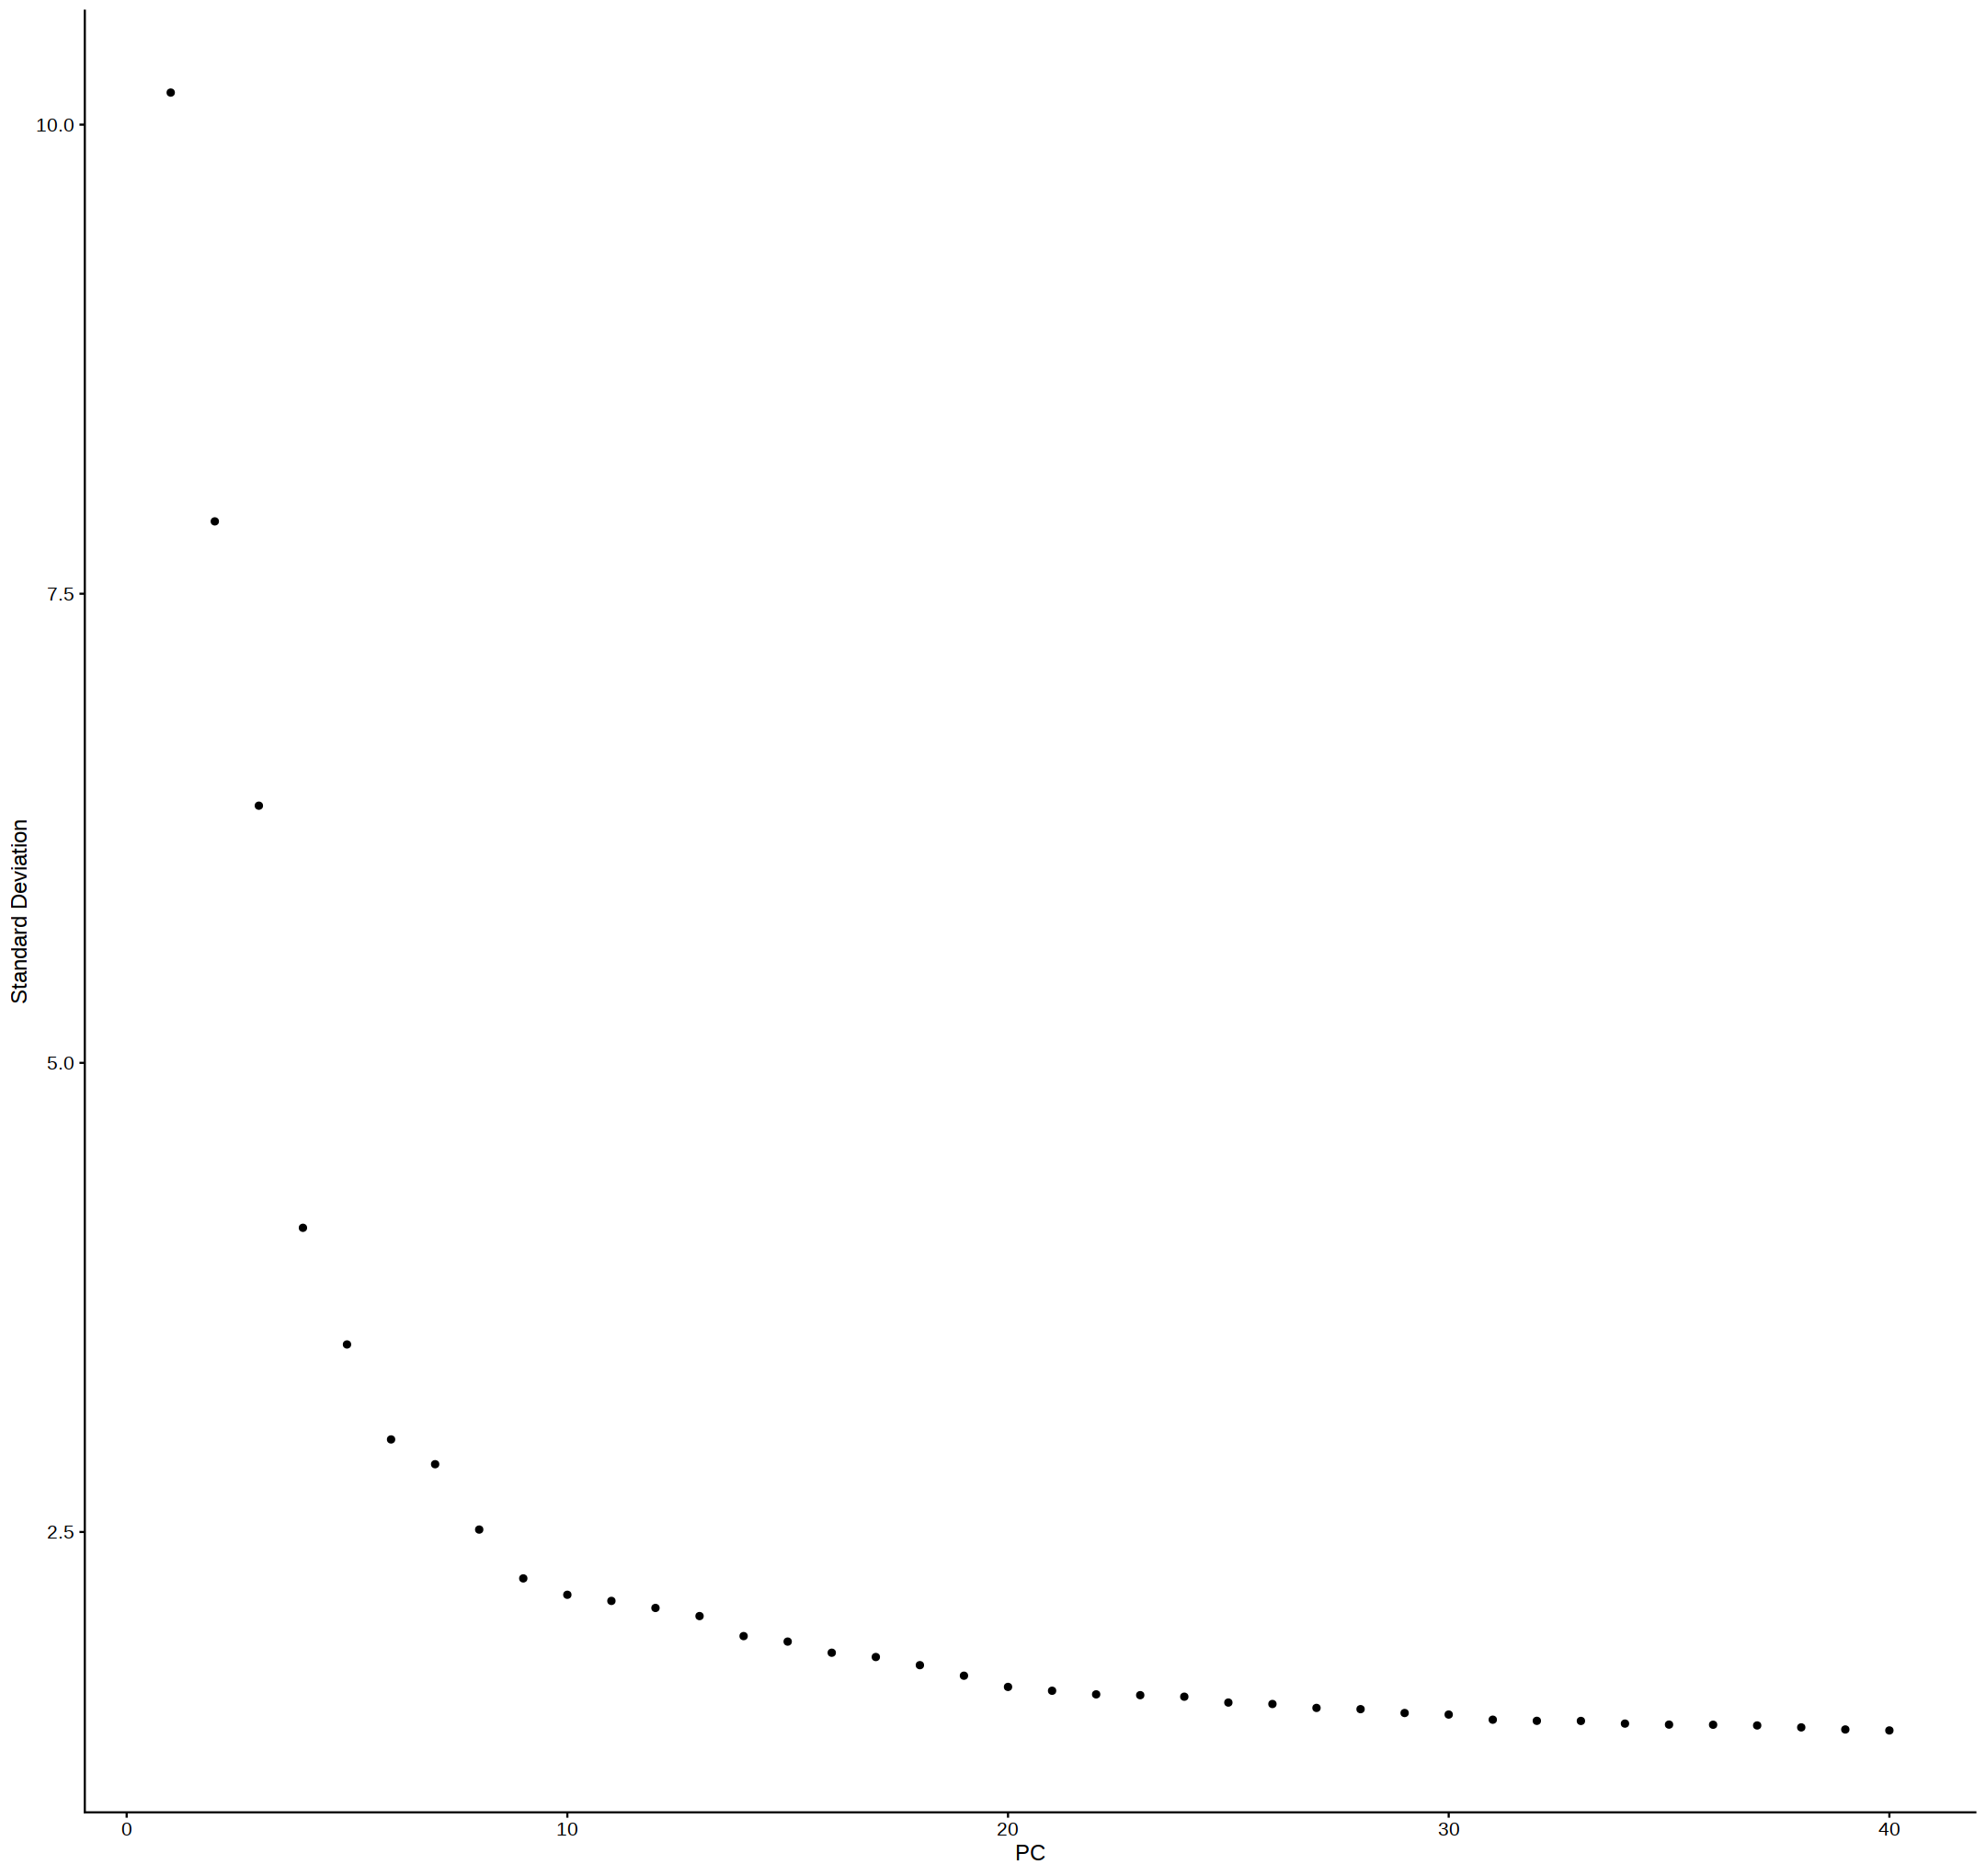

In [40]:
ElbowPlot(embryo.integrated, ndims = 40)

# Vizualization and clustering

In [41]:
embryo.integrated <- RunUMAP(embryo.integrated, reduction = "harmony", dims = 1:20)

15:02:21 UMAP embedding parameters a = 0.9922 b = 1.112

Found more than one class "dist" in cache; using the first, from namespace 'BiocGenerics'

Also defined by 'spam'

15:02:21 Read 4228 rows and found 20 numeric columns

15:02:21 Using Annoy for neighbor search, n_neighbors = 30

Found more than one class "dist" in cache; using the first, from namespace 'BiocGenerics'

Also defined by 'spam'

15:02:21 Building Annoy index with metric = cosine, n_trees = 50

0%   10   20   30   40   50   60   70   80   90   100%

[----|----|----|----|----|----|----|----|----|----|

*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
|

15:02:22 Writing NN index file to temp file /tmp/RtmpTtJ8BJ/file36dde324871

15:02:22 Searching Annoy index using 1 thread, search_k = 3000

15:02:23 Annoy recall = 100%

15:02:24 Commencing smooth kNN distance calibration using 1 thread

15:02:26 Initializing from normalized Laplacian + noise

15:02:26 Commencing optim

In [42]:
embryo.integrated <- FindNeighbors(embryo.integrated, reduction = "harmony", dims = 1:20)

Computing nearest neighbor graph

Computing SNN



In [43]:
embryo.integrated <- FindClusters(embryo.integrated, resolution = 0.05)

Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 4228
Number of edges: 196973

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.9740
Number of communities: 4
Elapsed time: 0 seconds


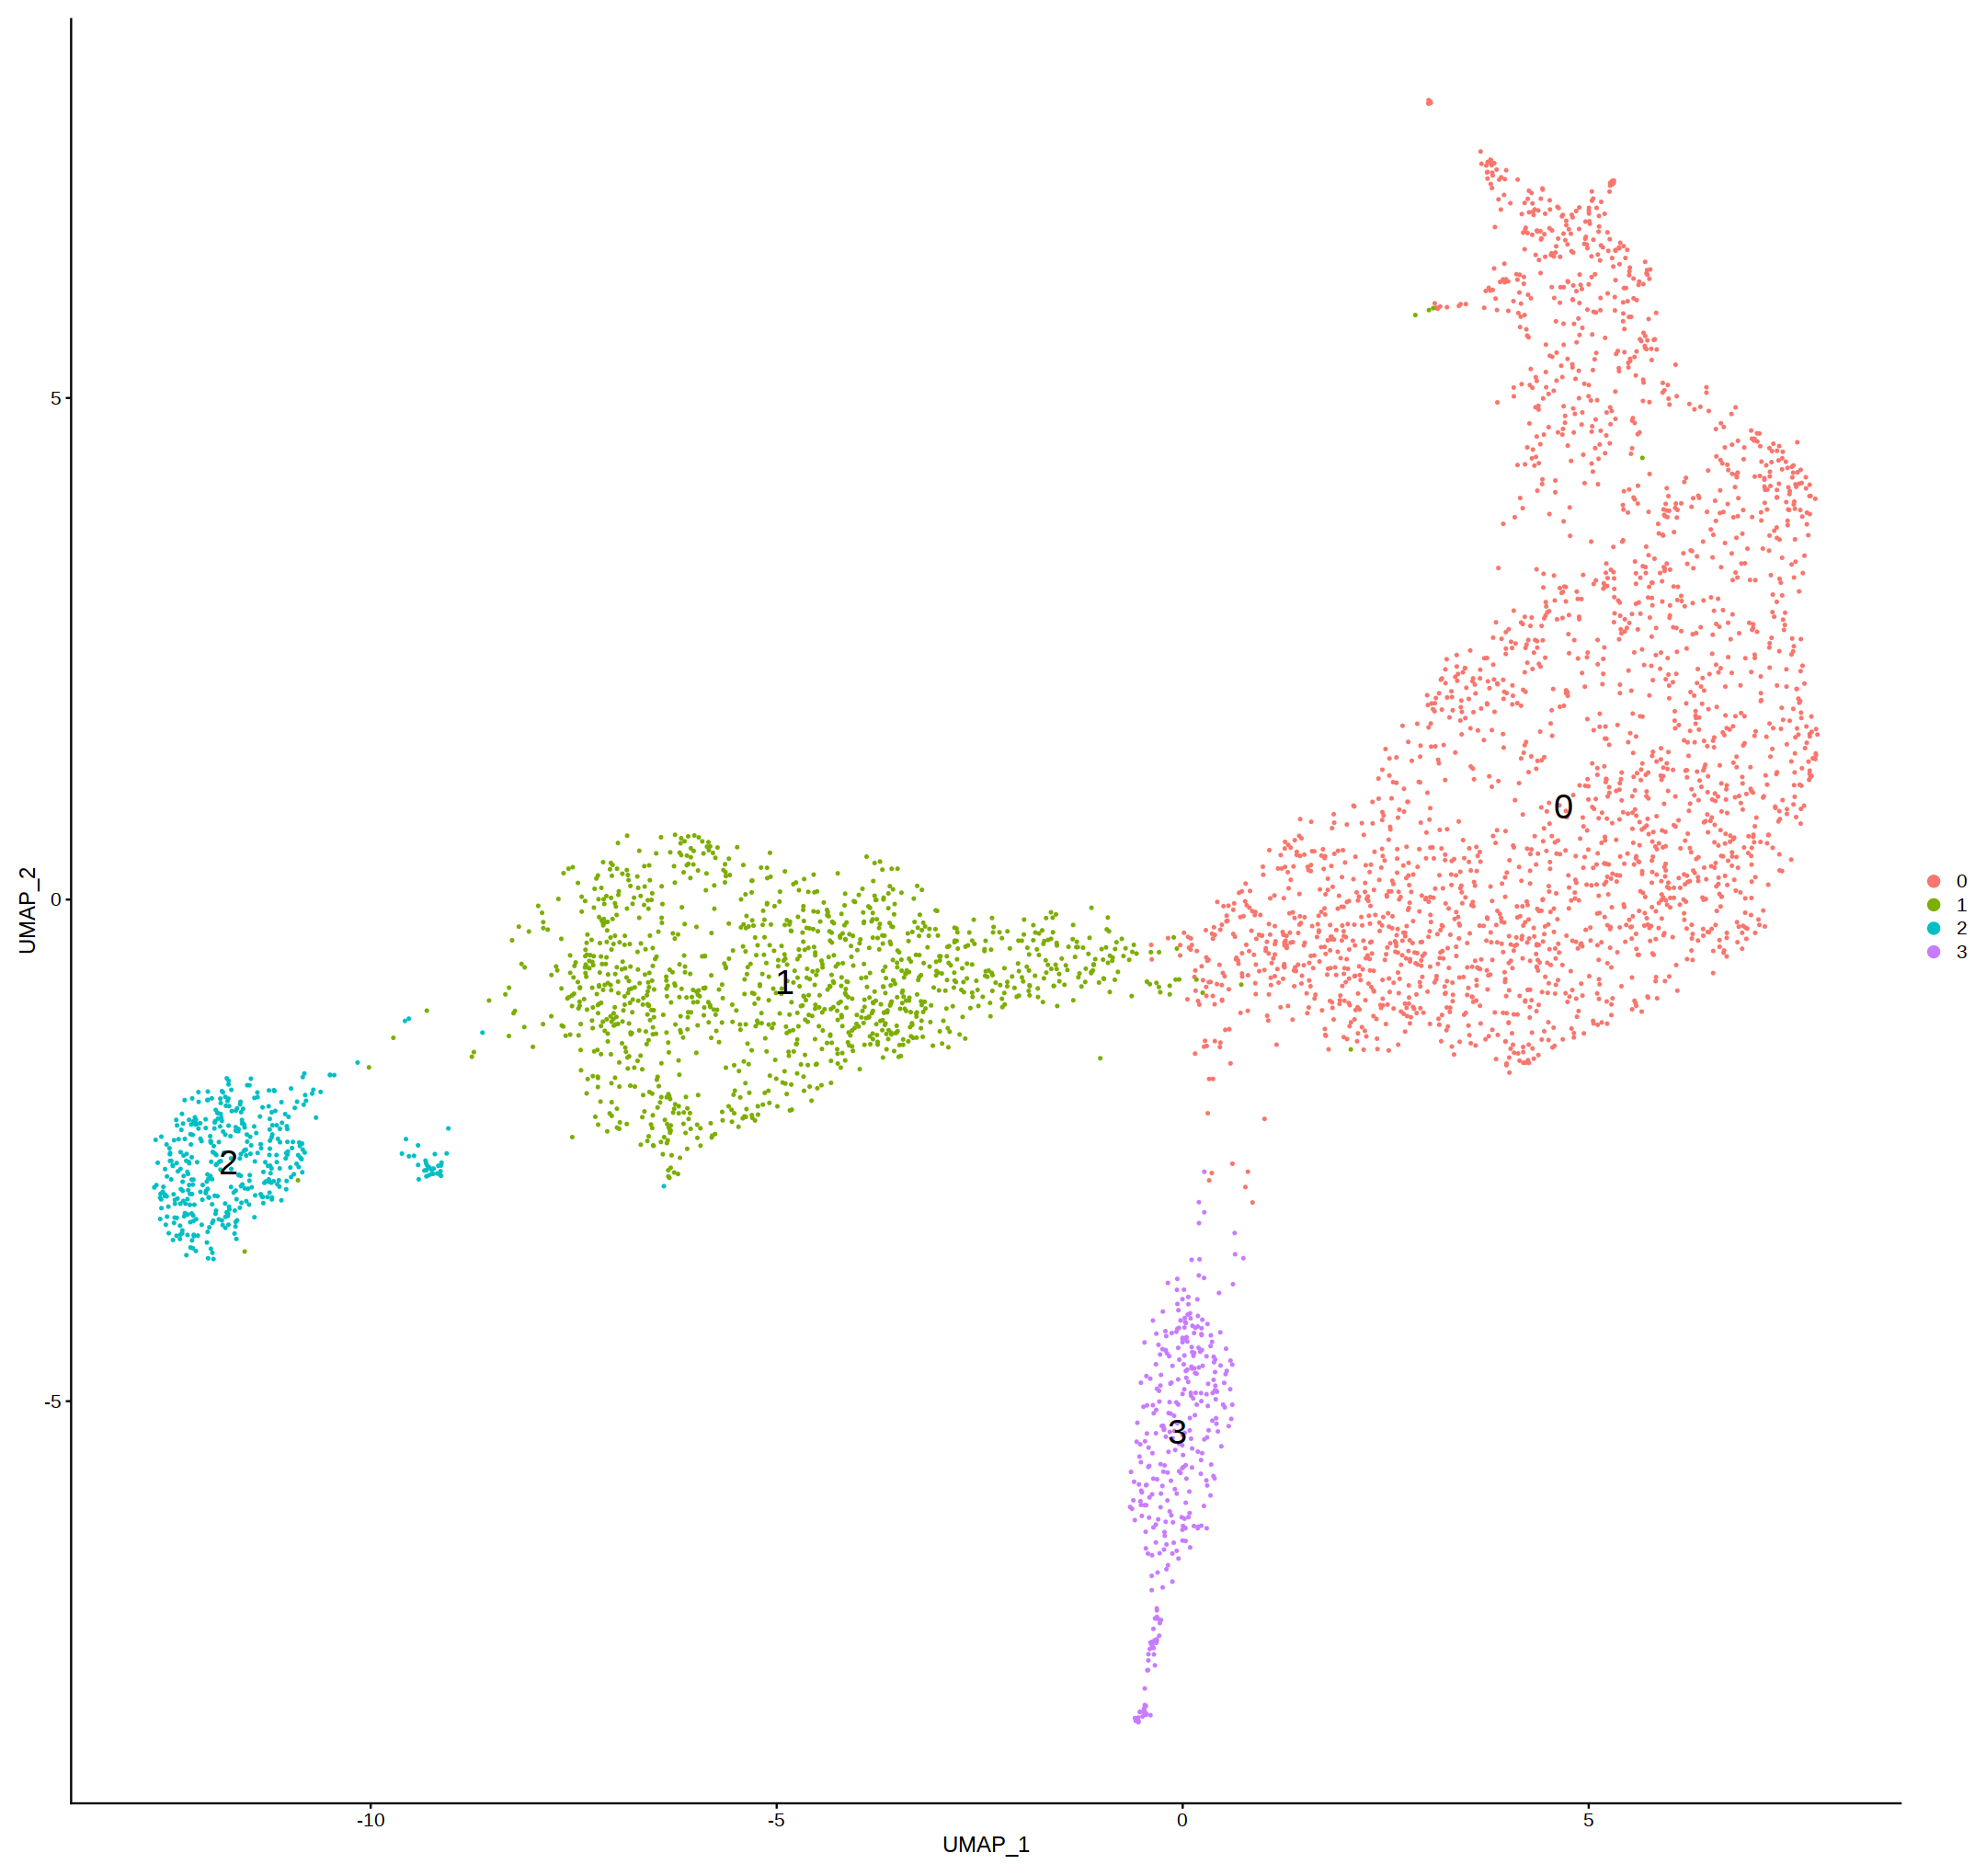

In [45]:
DimPlot(embryo.integrated, reduction = "umap", label = TRUE, label.size = 8)

Vizualization samples

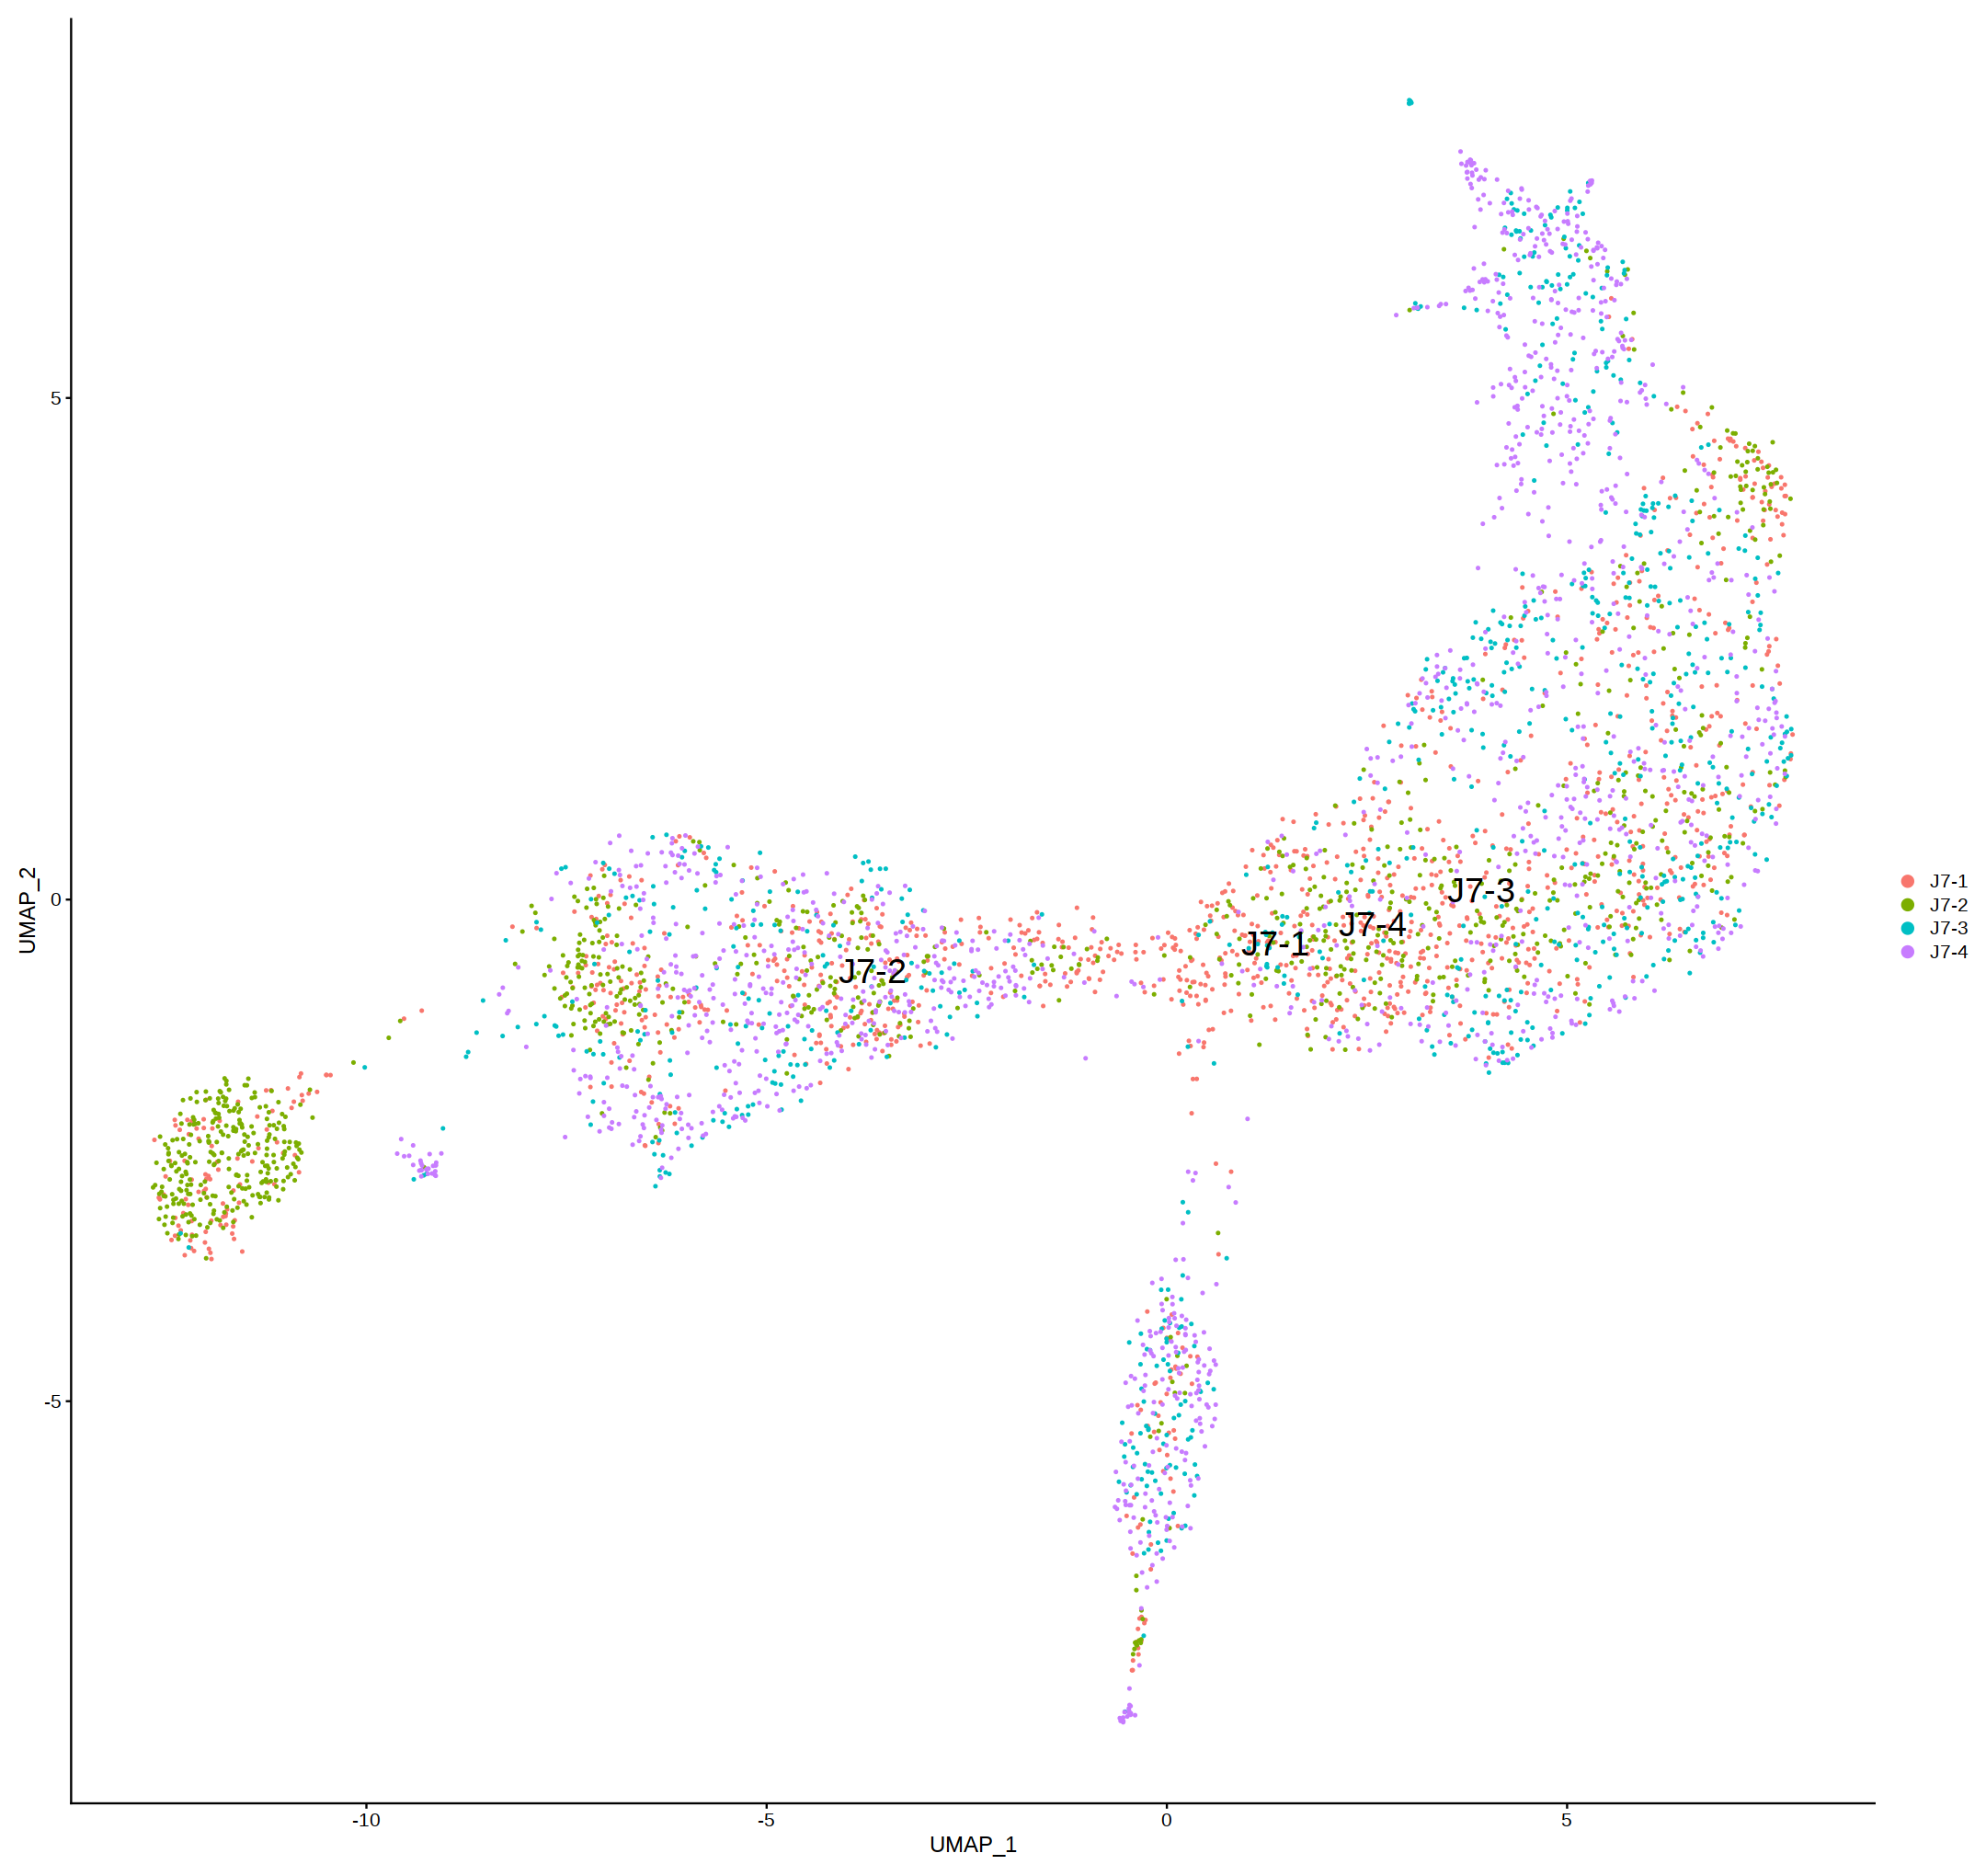

In [46]:
Idents(object = embryo.integrated) <- "SAMP"
DimPlot(embryo.integrated, reduction = "umap", label = TRUE, label.size = 8)

In [47]:
table(embryo.integrated@meta.data$seurat_clusters, embryo.integrated@meta.data$SAMP)

   
    J7-1 J7-2 J7-3 J7-4
  0  694  402  494  710
  1  328  260  182  423
  2   94  274    8   26
  3   55   26   83  169

# Cell cycle scoring

In [48]:
s.genes <- cc.genes$s.genes
g2m.genes <- cc.genes$g2m.genes
embryo.integrated <- CellCycleScoring(embryo.integrated, s.features = s.genes, g2m.features = g2m.genes, set.ident = TRUE)

Warning message:
"The following features are not present in the object: PRIM1, MLF1IP, UBR7, RRM2, not searching for symbol synonyms"
Warning message:
"The following features are not present in the object: NUSAP1, CKS1B, MKI67, TACC3, FAM64A, ANP32E, HN1, AURKA, not searching for symbol synonyms"


Visualization

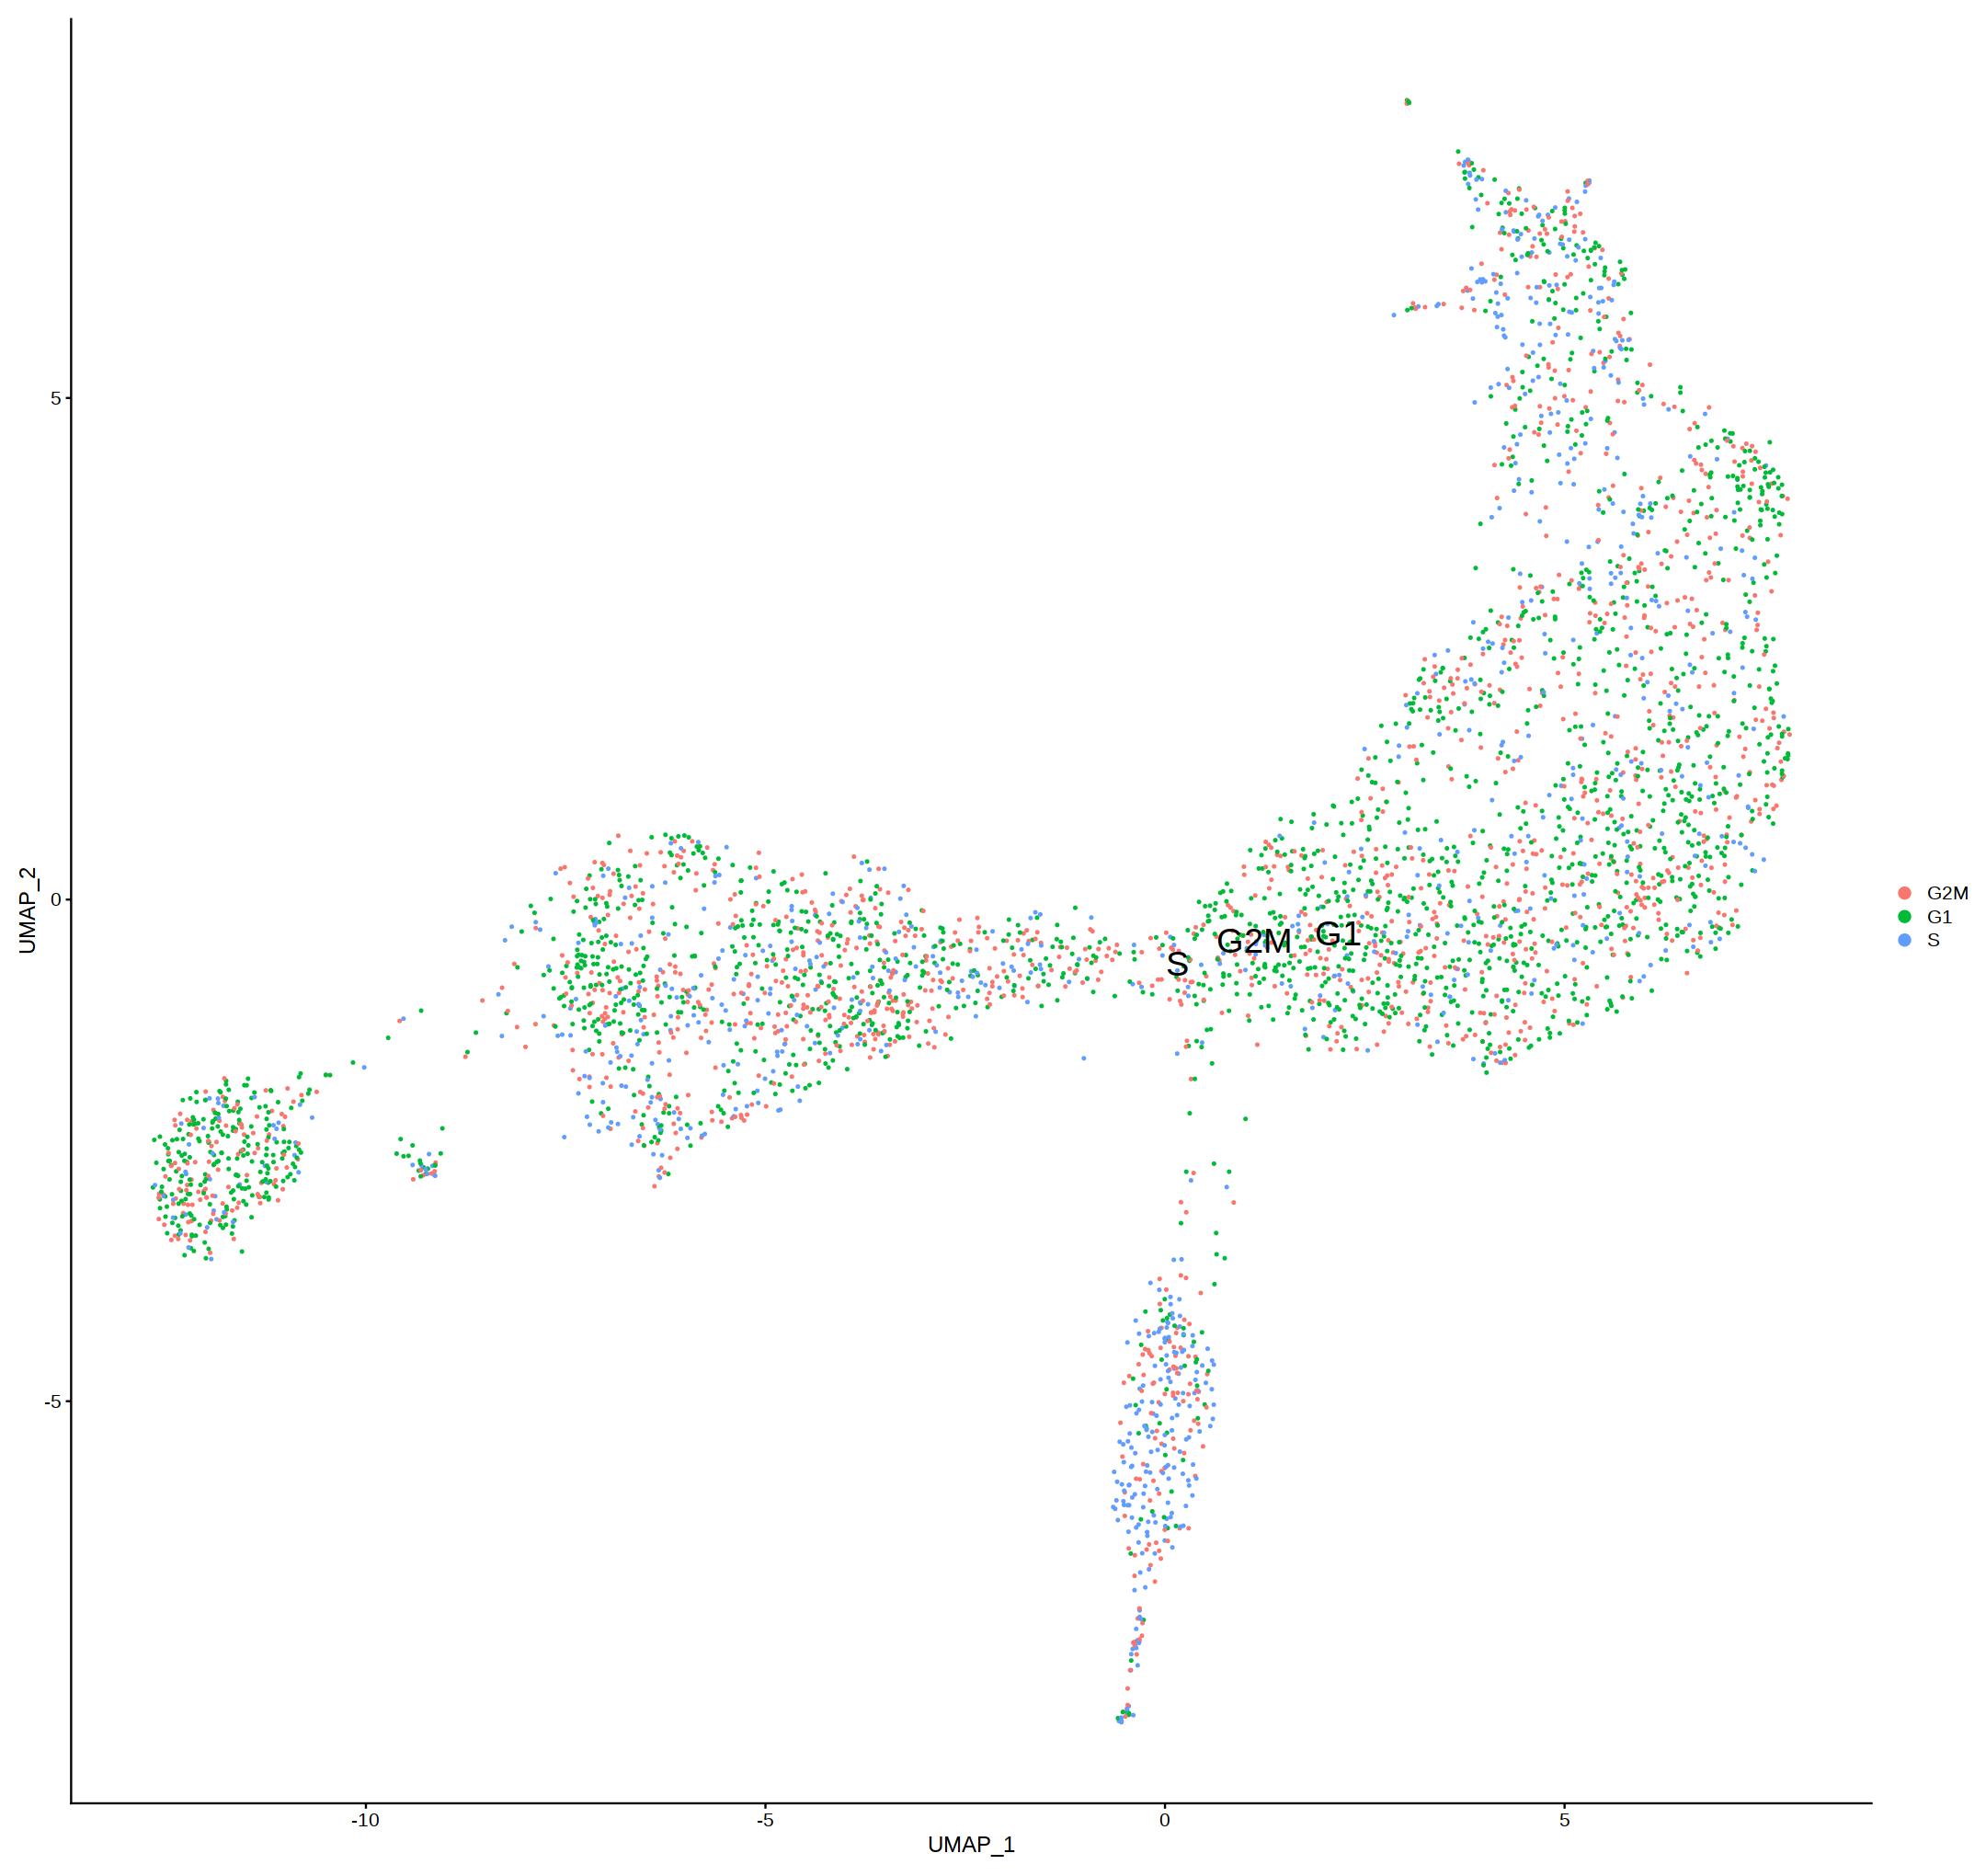

In [49]:
Idents(object = embryo.integrated) <- "Phase"
DimPlot(embryo.integrated, reduction = "umap", label = TRUE, label.size = 8)

In [50]:
embryo.integrated.regress <- ScaleData(embryo.integrated, vars.to.regress = c("S.Score", "G2M.Score"), features = rownames(embryo.integrated))

Regressing out S.Score, G2M.Score

Centering and scaling data matrix



In [51]:
embryo.integrated.regress <-  FindVariableFeatures(embryo.integrated.regress) %>% RunPCA()

PC_ 1 
Positive:  ENSSSCG00000001543, UPP1, ENSSSCG00000015069, APOA2, ENSSSCG00000001393, S100A10, CDC26, ENSSSCG00000037142, ENSSSCG00000022820, ENSSSCG00000022176 
	   GPX6, MARCKS, TMSB4X, ENSSSCG00000037274, APOA1, TPT1, SMS, ENSSSCG00000037832, CBX1, ISYNA1 
	   LXN, RSPO3, ENSSSCG00000031023, SMIM1, UCHL1, SOD1, KRT8, PSIP1, MT1A, MKRN1 
Negative:  HTT, IFN-ALPHA-8, ENSSSCG00000035789, ENSSSCG00000032599, GBP2, PHKG1, IGF2R, ENSSSCG00000003086, BFAR, ENSSSCG00000029160 
	   MCCD1, DCAF5, NUFIP2, ARHGEF39, GGCX, LRRC43, LRP2, CLCN7, ENSSSCG00000033010, ENSSSCG00000048526 
	   MLLT11, RRBP1, UVRAG, TAF1D, TET2, PTGS2, NFE2L3, CCL17, VEGFA, JMJD6 
PC_ 2 
Positive:  APOE, APOA1, COL18A1, ENSSSCG00000015069, FN1, SLC20A1, ENSSSCG00000037832, ENSSSCG00000037274, ENSSSCG00000016548, SERPINH1 
	   GPX6, APOA2, LAMA1, ENSSSCG00000044700, ENSSSCG00000022925, FBLN2, S100A10, LAMC1, COL4A2, AKAP12 
	   FST, NID1, SPINT2, CALD1, MARCKS, P3H1, RSPO3, CCN1, ISYNA1, ENSSSCG00000044051 
Negative

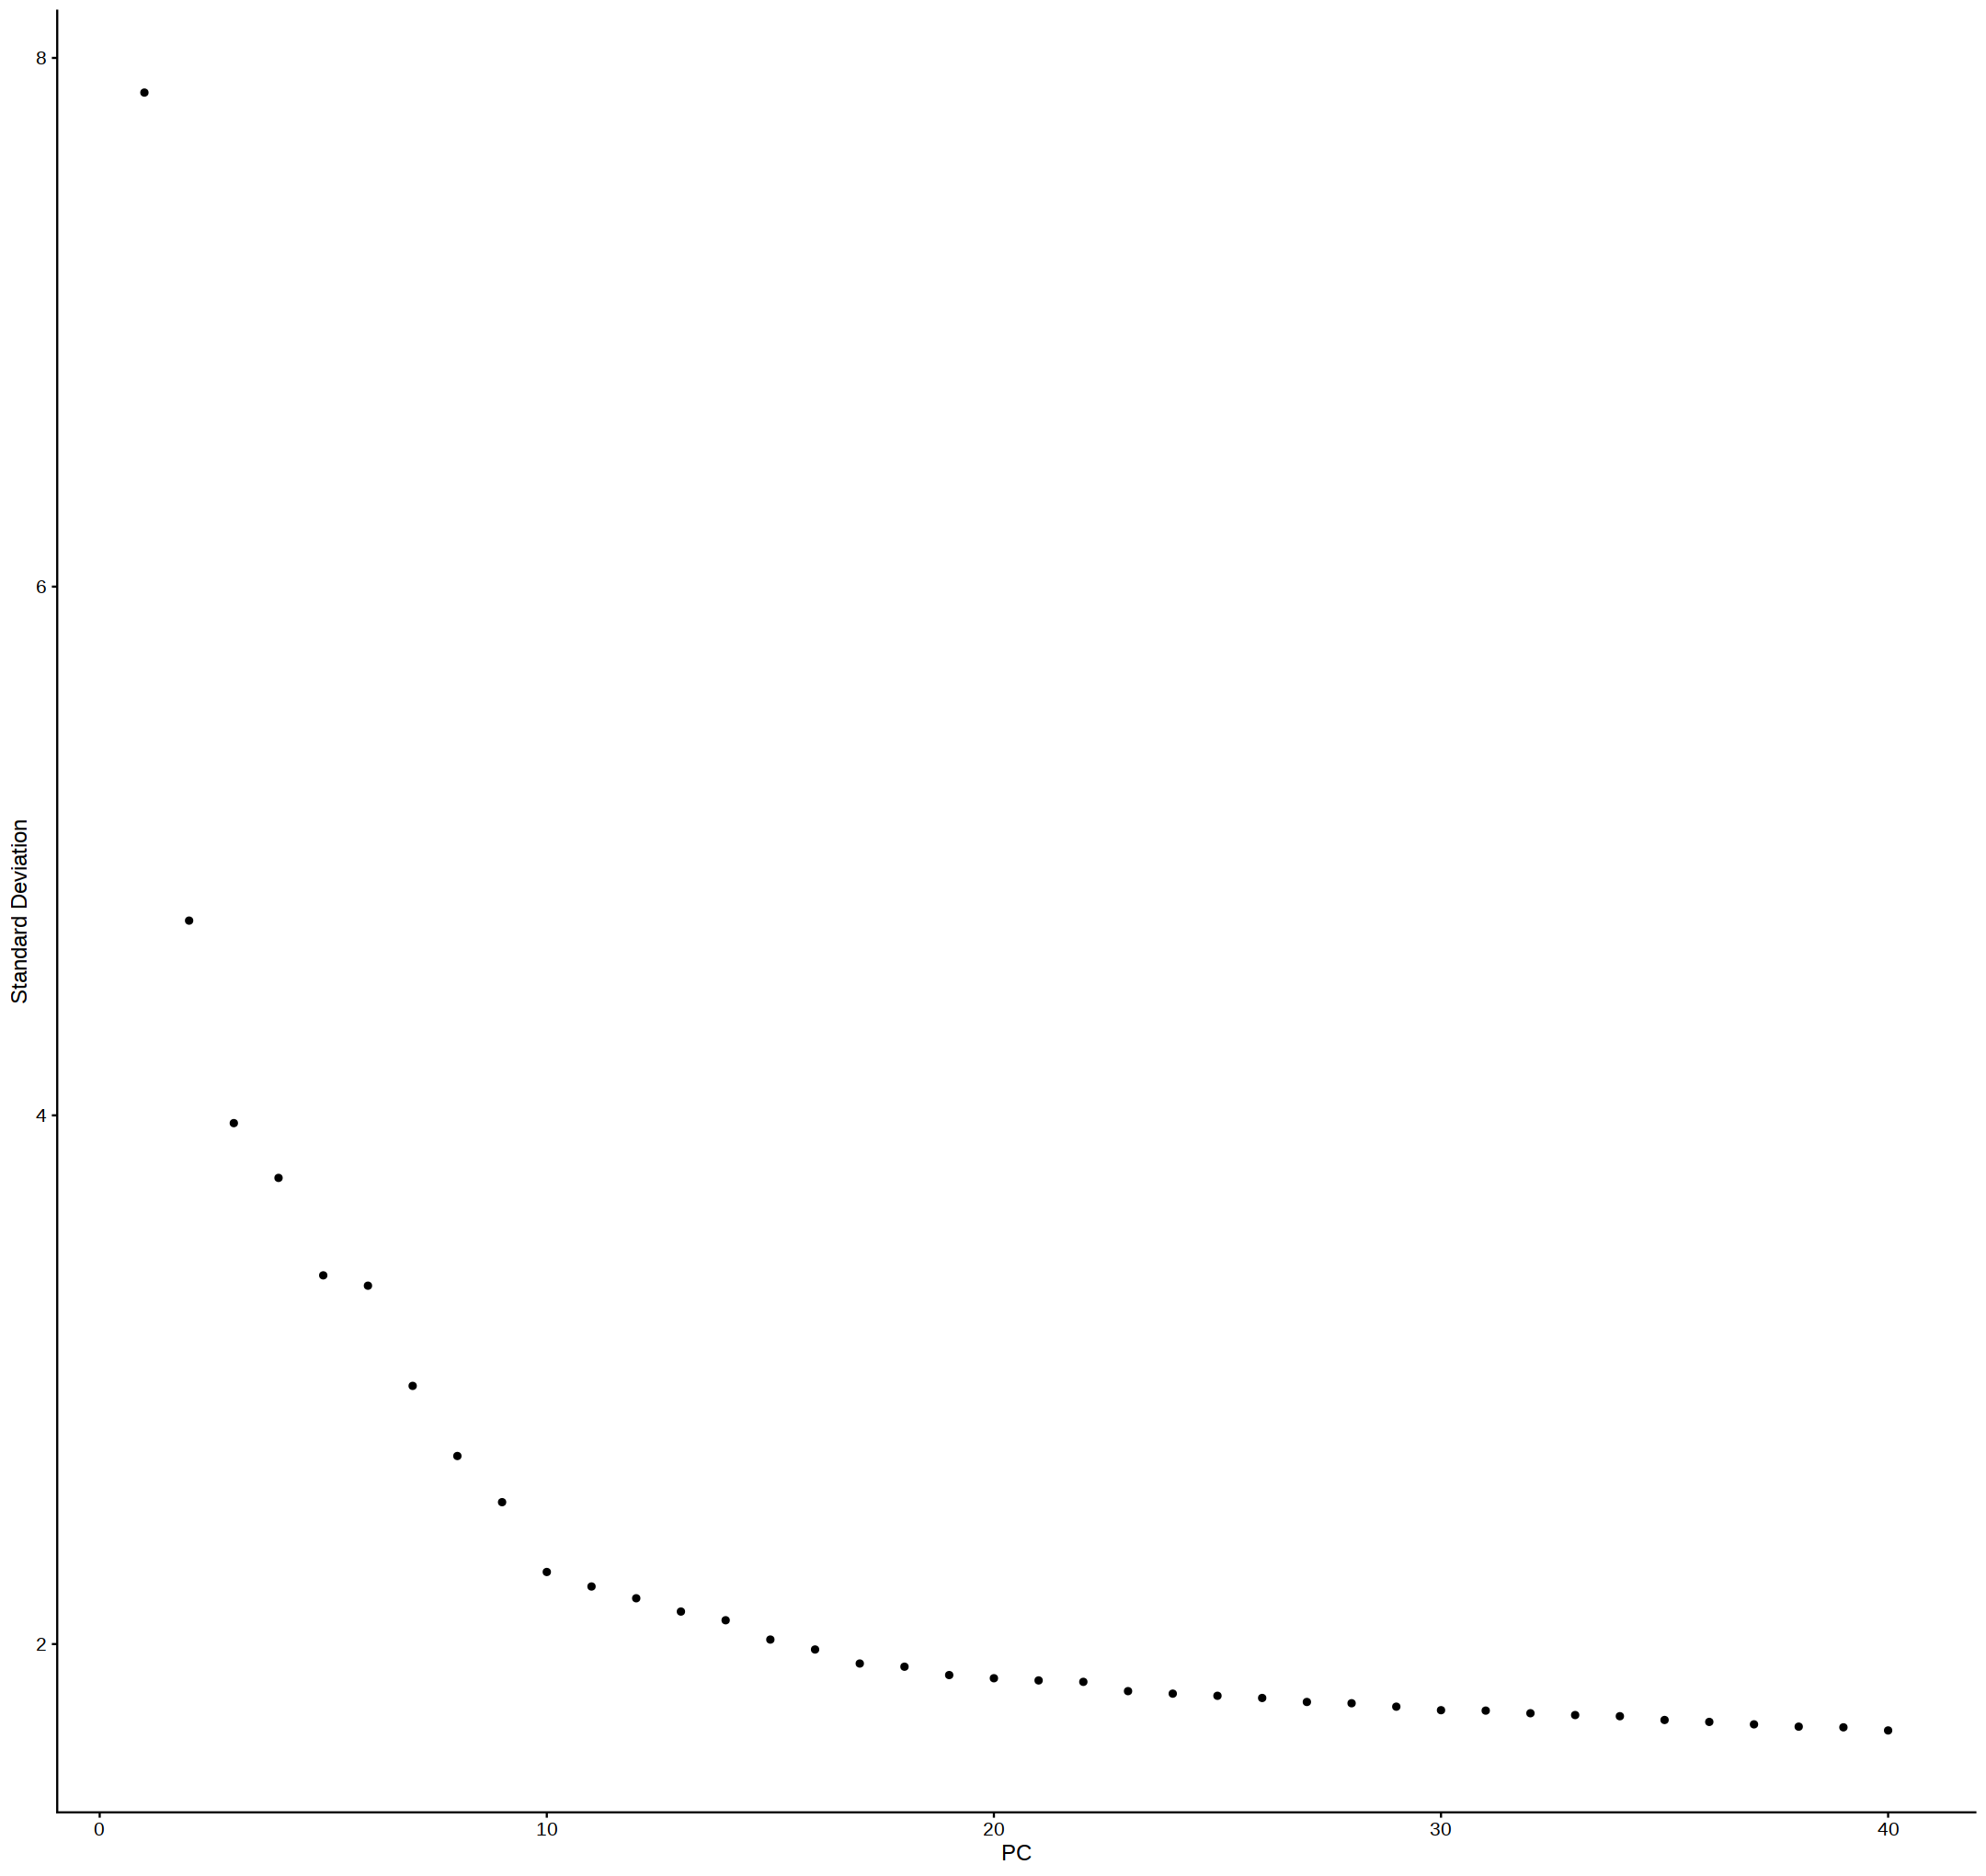

In [52]:
ElbowPlot(embryo.integrated.regress, ndims = 40)

In [58]:
embryo.integrated.regress <- RunUMAP(embryo.integrated.regress, reduction = "harmony", dims = 1:20)

15:18:21 UMAP embedding parameters a = 0.9922 b = 1.112

Found more than one class "dist" in cache; using the first, from namespace 'BiocGenerics'

Also defined by 'spam'

15:18:21 Read 4228 rows and found 20 numeric columns

15:18:21 Using Annoy for neighbor search, n_neighbors = 30

Found more than one class "dist" in cache; using the first, from namespace 'BiocGenerics'

Also defined by 'spam'

15:18:21 Building Annoy index with metric = cosine, n_trees = 50

0%   10   20   30   40   50   60   70   80   90   100%

[----|----|----|----|----|----|----|----|----|----|

*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
|

15:18:22 Writing NN index file to temp file /tmp/RtmpTtJ8BJ/file36dd6f0abd30

15:18:22 Searching Annoy index using 1 thread, search_k = 3000

15:18:23 Annoy recall = 100%

15:18:24 Commencing smooth kNN distance calibration using 1 thread

15:18:26 Initializing from normalized Laplacian + noise

15:18:26 Commencing opti

In [59]:
embryo.integrated.regress <- FindNeighbors(embryo.integrated.regress, reduction = "harmony", dims = 1:20)

Computing nearest neighbor graph

Computing SNN



In [60]:
embryo.integrated.regress <- FindClusters(embryo.integrated.regress, resolution = 0.08)

Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 4228
Number of edges: 196973

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.9638
Number of communities: 5
Elapsed time: 0 seconds


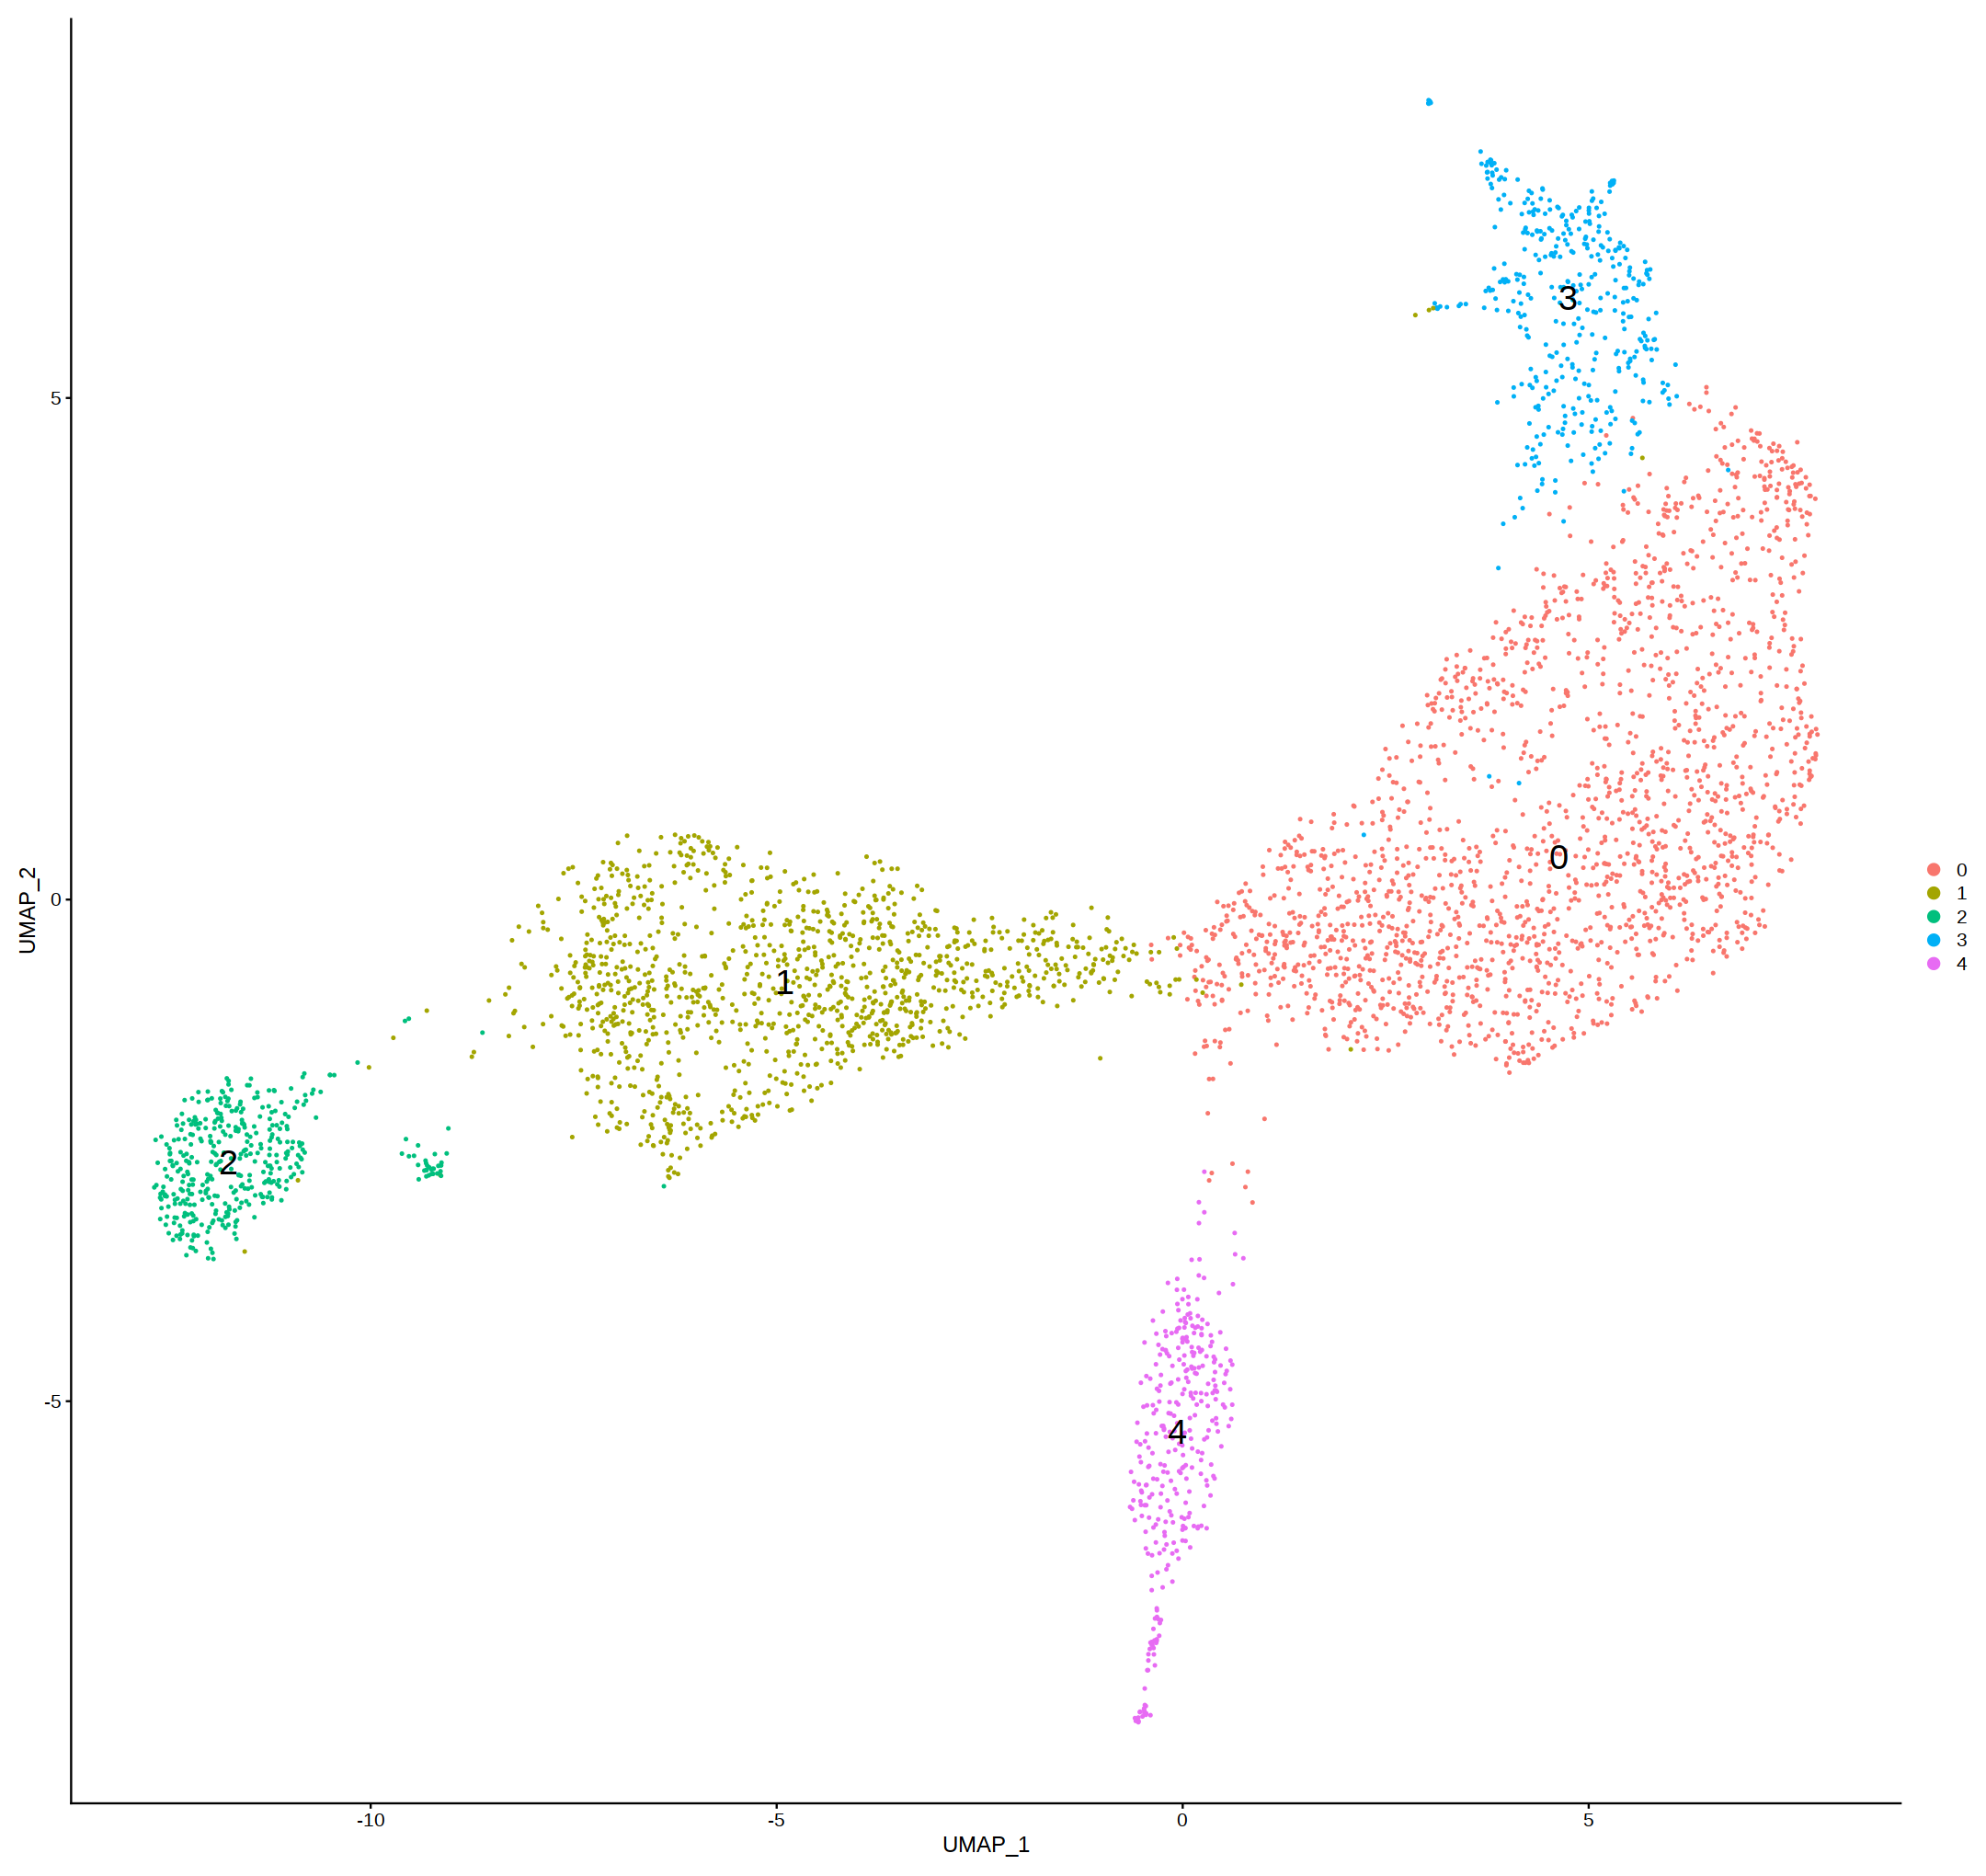

In [61]:
Idents(object = embryo.integrated.regress) <- "seurat_clusters"
DimPlot(embryo.integrated.regress, reduction = "umap", label = TRUE, label.size = 8)

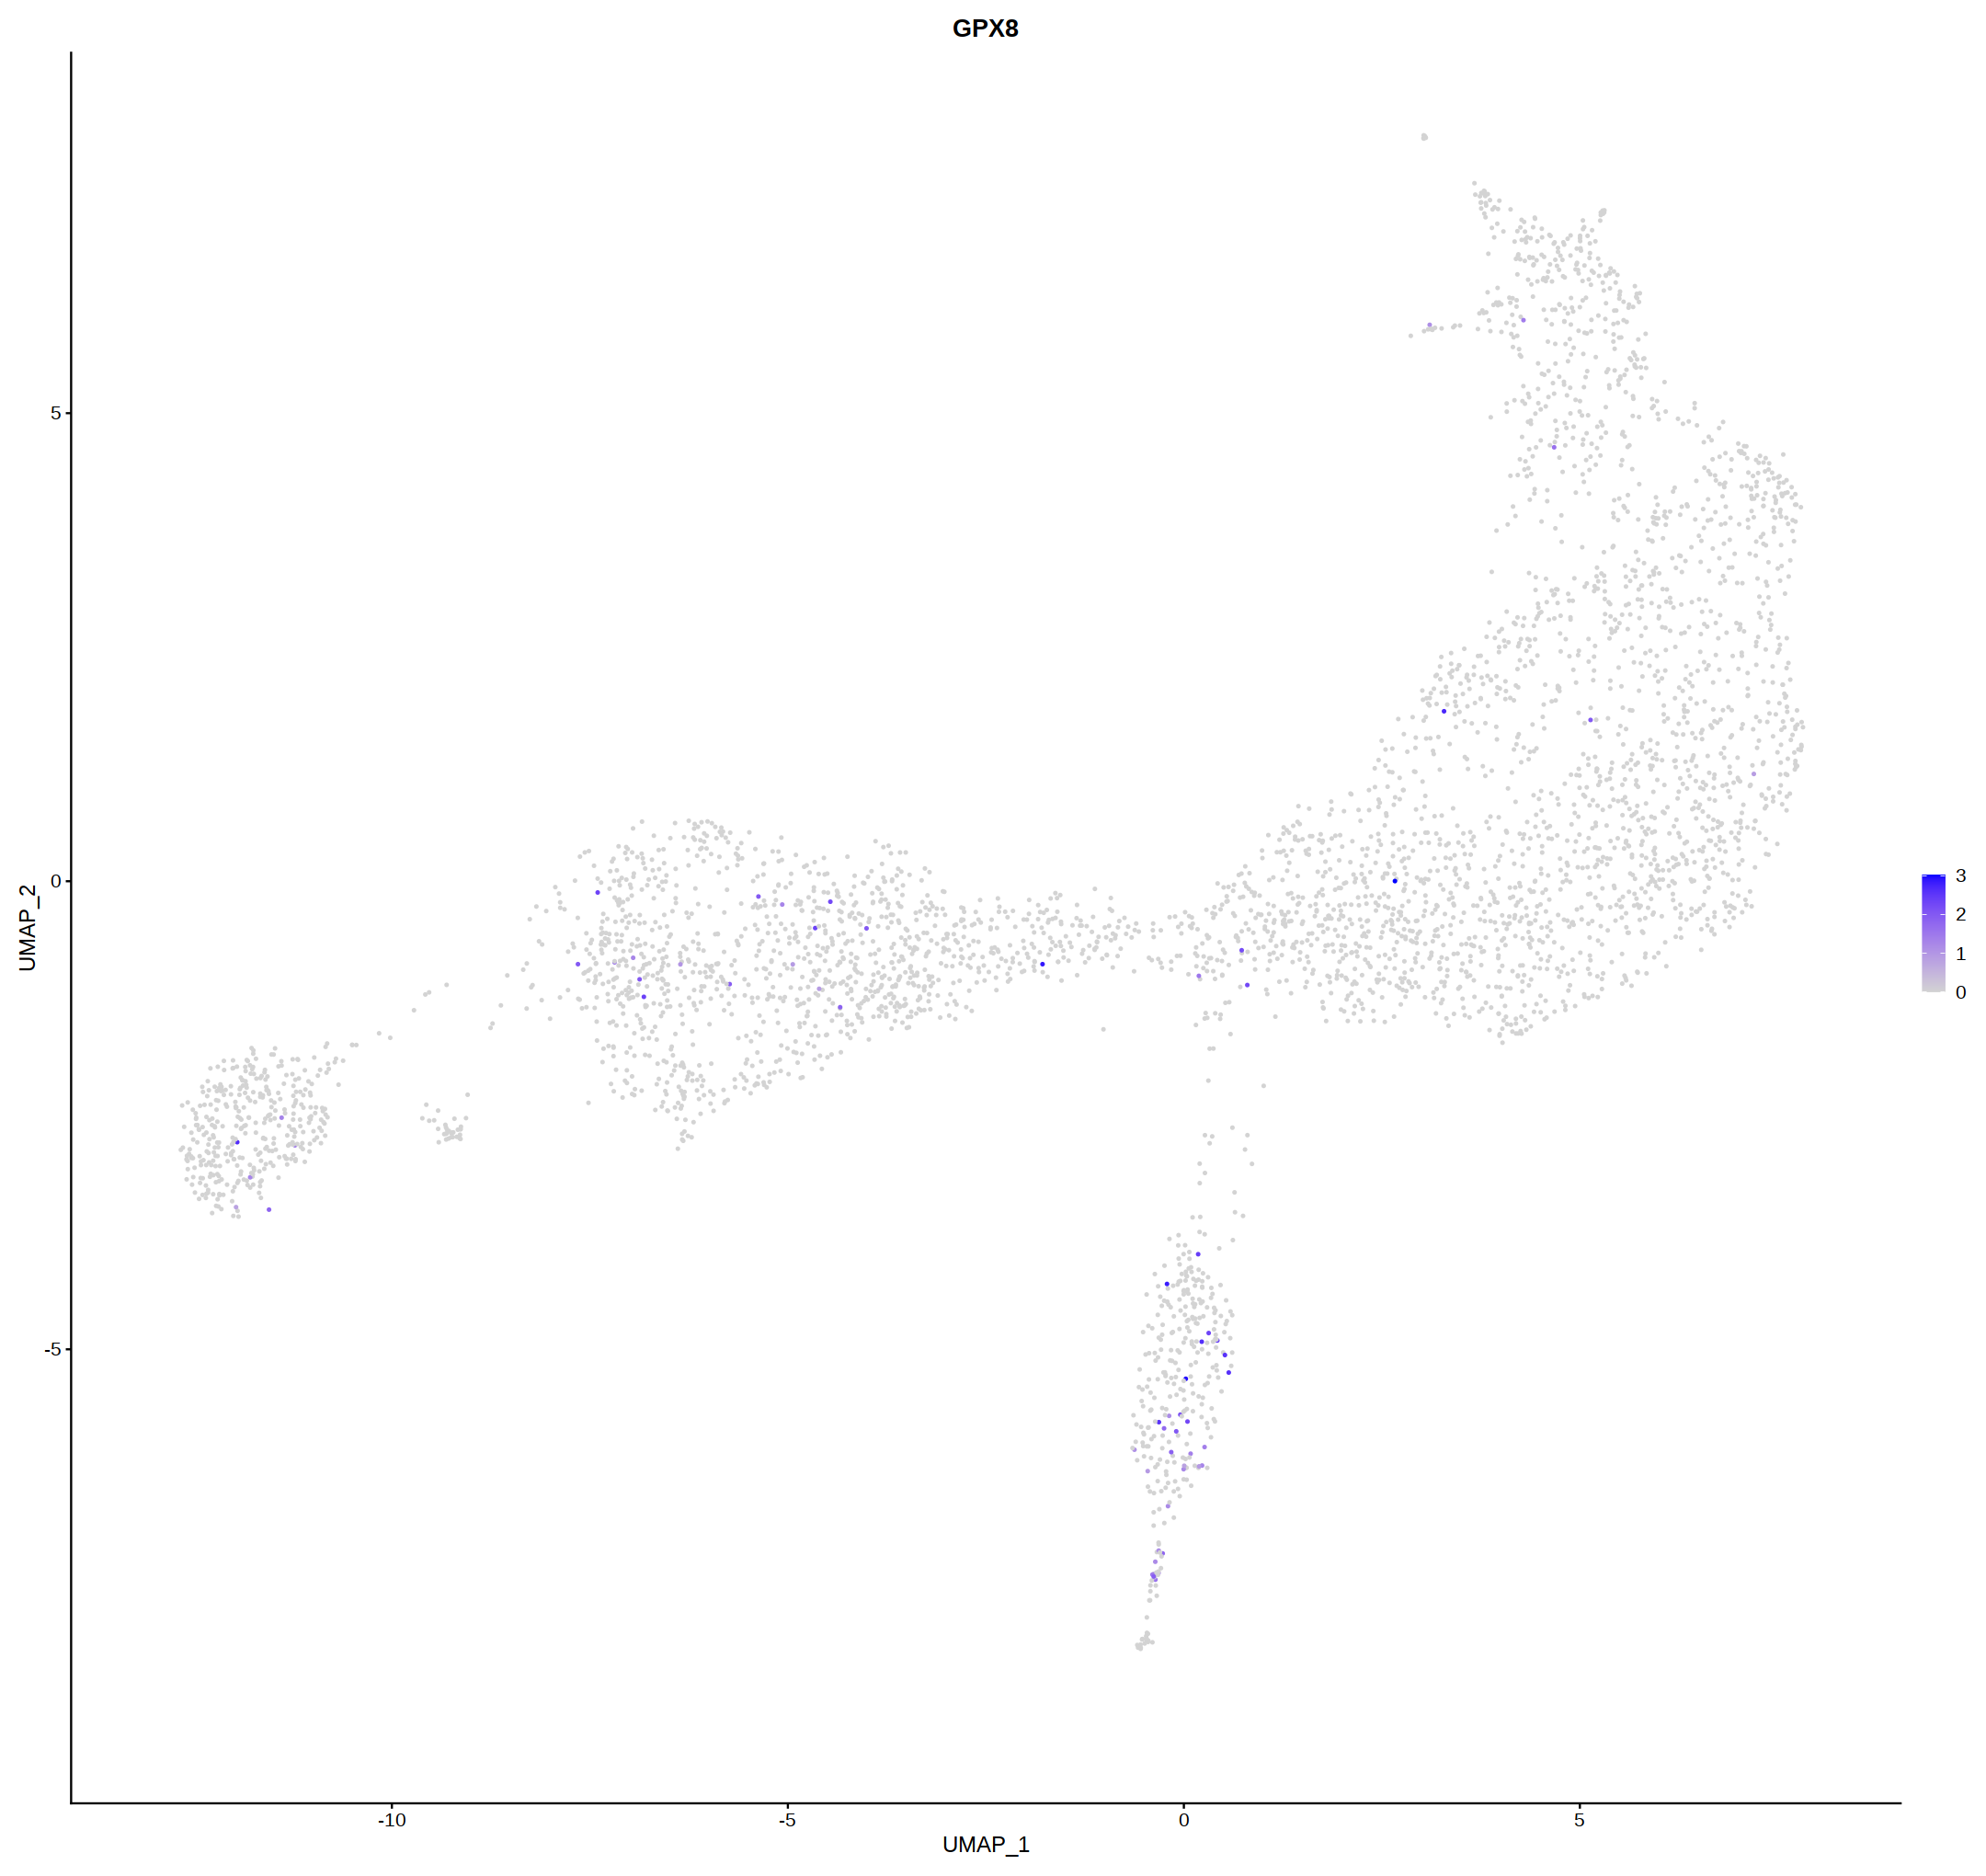

In [69]:
FeaturePlot(embryo.integrated, "GPX8")

In [64]:
saveRDS(embryo.integrated, "/home/adufour/work/rds_storage/embryo.j7.rds")
saveRDS(embryo.integrated.regress, "/home/adufour/work/rds_storage/embryo.j7_ccregress.rds")